<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Neste/Neste_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

     |████████████████████████████████| 727kB 3.3MB/s 
  Created wheel for Ta-Lib: filename=TA_Lib-0.4.17-cp36-cp36m-linux_x86_64.whl size=2405586 sha256=4b578111dac22c9b39184cb03d8f876262deafd2ded821fc53f51fdb27789dcd
  Stored in directory: /root/.cache/pip/wheels/2a/2e/ec/71c565b2e0091e03a2b56abfbfd062f14a01a8d7b20ffe8bd5
Successfully built Ta-Lib


In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "NES1VFIEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-22 10:13:03,686 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-22 10:13:03,687 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AUDJPY
2019-08-22 10:17:03,875 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-22 10:26:13,492 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-22 10:30:28,473 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-22 10:34:35,618 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-22 10:39:18,048 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-22 10:43:54,034 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-22 10:48:24,800 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-22 10:52:56,548 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-22 11:06:16,986 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AUDJPY__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AUDJPY__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AUDJPY to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open       High        Low      Close       Volume
Date                                                                        
2018-01-01 22:00:00  87.860001  88.028000  87.792000  87.987000  1967.810059
2018-01-01 23:00:00  87.989998  87.989998  87.876999  87.945999  6692.810059
2018-01-02 00:00:00  87.949997  88.093002  87.942001  88.077003  3015.949951
2018-01-02 01:00:00  88.077003  88.213997  88.055000  88.138000  4958.649902
2018-01-02 02:00:00  88.137001  88.199997  88.125000  88.160004  3736.630127
...                        ...        ...        ...        ...          ...
2018-12-31 17:00:00  77.300003  77.320999  77.225998  77.235001  5473.870117
2018-12-31 18:00:00  77.232002  77.283997  77.218002  77.259003  3701.399902
2018-12-31 19:00:00  77.259003  77.279999  77.209000  77.224998  3154.629883
2018-12-31 20:00:00  77.225998  77.244003  77.192001  77.216003  3147.850098
2018-12-31 21:00:00  77.214996  77.334000  77.152000  77.174004  1882.890015

[6222 rows x 5 columns]

Open         High          Low        Close        Volume
count  6222.000000  6222.000000  6222.000000  6222.000000   6222.000000
mean     82.536232    82.612144    82.459091    82.534569   6046.020996
std       2.310576     2.308661     2.312368     2.310386   3195.994141
min      77.214996    77.244003    77.152000    77.174004    274.450012
25%      81.288252    81.374001    81.203003    81.285254   3902.119934
50%      82.221001    82.293499    82.153999    82.219002   5722.859863
75%      83.278000    83.341753    83.206751    83.275751   7598.547485
max      89.056000    89.086998    89.021004    89.056999  86182.937500

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open       High        Low      Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  88.136002  88.204002  88.125999  88.157997  5331.959961    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  88.093552  87.051926  88.078003  88.163707  88.114866  88.039210   88.143497   88.123001  88.031704  88.132249  88.157184  88.141148  88.138915  88.132249  88.126666  88.010662               88.236486                88.132249               88.028012               88.288604                88.132249               87.975893               88.340723                88.132249               87.923775               88.392841                88.132249               87.871656  88.114866  88.141880  88.025891               88.219103                88.114866               88.010629               88.271222                88.114866               87.958511               88.323340                88.114866               87.906393               88.375459   
2018-01-04 01:00:00  88.158997  88.182999  88.098000  88.139999  4603.370117    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  88.095875  87.078025  88.094002  88.162783  88.120452  88.041622   88.143497   88.144001  88.047648  88.139998  88.152646  88.140248  88.140638  88.139998  88.148998  88.025653               88.235831                88.139998               88.044166               88.283747                88.139998               87.996250               88.331663                88.139998               87.948334               88.379579                88.139998               87.900418  88.120452  88.142355  88.041009               88.216284                88.120452               88.024619               88.264200                88.120452               87.976703               88.312116                88.120452               87.928787               88.360032   
2018-01-04 02:00:00  88.139000  88.231003  88.

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6172.000000  6172.000000  6172.000000  6172.000000   6172.000000  6172.000000  6172.000000  6172.000000    6172.000000  6172.000000   6172.000000     6172.000000     6172.000000       6172.000000  6172.000000  6172.000000  6172.000000  6172.000000   6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000  6172.000000  6172.000000  6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000   
mean     82.492210    82.568260    82.414848    82.490517   6061.520996    15.901977     2.052171   183.847699      30.440538    11.490441      0.034349        0.972294        0.004051          0.995139     6.548283     2.519929    26.642579     2.052171      2.029812    26.642579    82.499496    82.516145    -0.045515    82.490659    82.496676    82.495835    82.494406    82.492705    82.495501    82.496735    82.490550    82.496738    82.494676    82.496735    82.491784    82.508600               82.701772                82.496735               82.291699               82.804290                82.496735               82.189181               82.906808                82.496735               82.086663               83.009326                82.496735               81.984145    82.496676    82.491858    82.506852               82.701712                82.496676               82.291640               82.804230                82.496676               82.189122               82.906748   
std       2.267289     2.265594     2.268557     2.266978   3201.857178     8.727121     1.509716   104.027997       0.844514     6.924863      0.182138        0.164142        0.063520          0.069554     3.409848     1.112862    14.860675     1.509716      1.457579    14.860675     2.264071     2.253717    82.533323     2.267984     2.262945     2.261778     2.263530     2.264056     2.272963     2.264338     2.267618     2.265010     2.264652     2.264338     2.265979     2.260447                2.263403                 2.264338                2.271855                2.265408                 2.264338                2.278064                2.269058                 2.264338                2.285890                2.274344                 2.264338                2.295316     2.262945     2.265715     2.260992                2.261913                 2.262945                2.270564                2.263872                 2.262945                2.276824                2.267476   
min      77.214996    77.244003    77.

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.922304  0.925442  0.924593  0.924346  0.058871    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.928341  0.842560  0.995563  0.925751  0.927134  0.925696    0.928716    0.927012  0.909253  0.928200  0.924759  0.928205  0.927391  0.928200  0.924207  0.921285                0.920012                 0.928200                0.929140                0.908552                 0.928200                0.928372                0.892927                 0.928200                0.927334                0.876632                 0.928200                0.926315  0.927134  0.925113  0.921971                0.919420                 0.927134                0.927898                0.902394                 0.927134                0.928477                0.885826                 0.927134                0.927976                0.869700                 0.927134   
2018-01-04 01:00:00  0.924246  0.923668  0.922234  0.922831  0.050390    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.928540  0.844870  0.995653  0.925673  0.927613  0.925903    0.928716    0.928821  0.910624  0.928863  0.924378  0.928129  0.927538  0.928863  0.926097  0.922609                0.919956                 0.928863                0.930509                0.908140                 0.928863                0.930083                0.892167                 0.928863                0.929378                0.875534                 0.928863                0.928687  0.927613  0.925154  0.923301                0.919178                 0.927613                0.929085                0.901799                 0.927613                0.930008                0.884889                 0.927613                0.929844                0.868428                 0.927613   
2018-01-04 02:00:00  0.922557  0.927721  

140230

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp7_1gza_
  JVM stdout: /tmp/tmpp7_1gza_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpp7_1gza_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_l60h34
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.759222  0.636945              0.300758  0.460205  0.211789
1  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.748274  0.603430              0.321915  0.457672  0.209464
2  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.744225  0.616528              0.335918  0.462558  0.213960
3  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.738187  0.616091              0.347179  0.455092  0.207109
4  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.733292  0.636339              0.343388  0.465153  0.216367
5  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.712802  0.630495              0.361087  0.465394  0.216591
6  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.707626  0.673860              0.374457  0.470084  0.220979
7  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.698756  0.650531              0.356996  0.472236  0.223007
8              DeepLearning_1_AutoML_20190822_112516  0.656384  0.818142              0.383306  0.519650  0.270036
9  DeepLearning_grid_1_AutoML_20190822_112516_mod...  0.647133  1.720440              0.382783  0.589426  0.347423

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005155
1           CDLCLOSINGMARUBOZU             0.655508           0.655508    0.003379
2               CDLEVENINGSTAR             0.631009           0.631009    0.003253
3                CDLHANGINGMAN             0.596700           0.596700    0.003076
4               CDL3LINESTRIKE             0.574115           0.574115    0.002960
...                        ...                  ...                ...         ...
1035                    T3_8_7             0.146664           0.146664    0.000756
1036  BBANDS_middleband_12_7_2             0.144898           0.144898    0.000747
1037   BBANDS_upperband_14_6_4             0.142919           0.142919    0.000737
1038       CDLRISEFALL3METHODS             0.139899           0.139899    0.000721
1039             CDLHIKKAKEMOD             0.137469           0.137469    0.000709

[1040 rows x 4 columns]

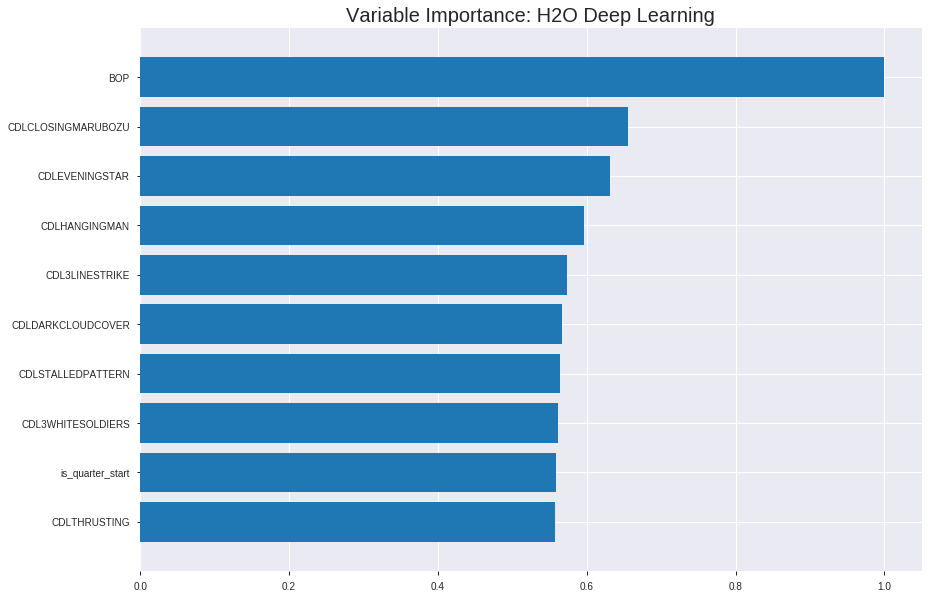

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_112516_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21241425923649965
RMSE: 0.46088421456641326
LogLoss: 0.628486560691719
Mean Per-Class Error: 0.3198964948705423
AUC: 0.7411983656949022
pr_auc: 0.7137021076807211
Gini: 0.4823967313898043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27234820850460995: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1136  1136  0.5      (1136.0/2272.0)
1      367   1680  0.1793   (367.0/2047.0)
Total  1503  2816  0.348    (1503.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.272348     0.690932  280
max f2                       0.0350339    0.826836  381
max f0point5                 0.504172     0.66419   183
max accuracy                 0.452571     0.68025   204
max precision                0.997414     1         0
max recall                   0.0021122    1         398
max specificity              0.997414     1         0
max absolute_mcc             0.401272     0.359869  227
max min_per_class_accuracy   0.42371      0.675176  218
max mean_per_class_accuracy  0.401272     0.680104  227

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 41.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.958951           1.96606   1.96606            0.931818         0.978097   0.931818                    0.978097            0.0200293       0.0200293                  96.6059   96.6059
    2        0.0201436                   0.929457           1.81551   1.89165            0.860465         0.944019   0.896552                    0.961254            0.0180752       0.0381045                  81.551    89.165
    3        0.0300996                   0.911355           1.91365   1.89893            0.906977         0.920456   0.9                         0.947759            0.0190523       0.0571568                  91.3646   89.8925
    4        0.0400556                   0.889675           1.71737   1.8538             0.813953         0.900212   0.878613                    0.935941            0.0170982       0.074255                   71.7374   85.38
    5        0.0500116                   0.873183           1.81551   1.84618            0.860465         0.882559   0.875                       0.925314            0.0180752       0.0923302                  81.551    84.6177
    6        0.100023                    0.7972             1.75826   1.80222            0.833333         0.832196   0.854167                    0.878755            0.0879336       0.180264                   75.8264   80.2221
    7        0.150035                    0.729814           1.48476   1.6964             0.703704         0.762136   0.804012                    0.839882            0.074255        0.254519                   48.4756   69.6399
    8        0.200046                    0.673623           1.45545   1.63616            0.689815         0.701185   0.775463                    0.805208            0.0727894       0.327308                   45.5452   63.6162
    9        0.300069                    0.580117           1.26986   1.51406            0.601852         0.627697   0.717593                    0.746038            0.127015        0.454323                   26.9857   51.4061
    10       0.400093                    0.498611           1.26497   1.45179            0.599537         0.539259   0.688079                    0.694343            0.126527        0.58085                    26.4973   45.1789
    11       0.500116                    0.413544           1.04519   1.37047            0.49537          0.458561   0.649537                    0.647187            0.104543        0.685393                   4.51903   37.0469
    12       0.599907                    0.321024           0.964394  1.30292            0.457077         0.366454   0.617522                    0.600488            0.0962384       0.781632                   -3.56064  30.2921
    13       0.699931                    0.226113           0.698422  1.21653            0.331019         0.272942   0.57658                     0.55368             0.0698583       0.85149                    -30.1578  21.6535
    14       0.799954                    0.1376             0.678885  1.14931            0.321759         0.181851   0.544718                    0.507188            0.0679043       0.919394                   -32.1115  14.9309
    15       0.899977                    0.0548748          0.532363  1.08074            0.252315         0.0933852  0.51222                     0.461198            0.0532487       0.972643                   -46.7637  8.07421
    16       1                           3.41445e-05        0.273508  1                  0.12963          0.0227909  0.473952                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21766837505534273
RMSE: 0.4665494347390668
LogLoss: 0.6346423588959993
Mean Per-Class Error: 0.30223696114114995
AUC: 0.7605063011508278
pr_auc: 0.7429710906852329
Gini: 0.5210126023016557
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.251289278883507: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      307  289  0.4849   (289.0/596.0)
1      95   543  0.1489   (95.0/638.0)
Total  402  832  0.3112   (384.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251289     0.738776  285
max f2                       0.0718093    0.851528  368
max f0point5                 0.423394     0.71711   203
max accuracy                 0.324132     0.696921  249
max precision                0.997958     1         0
max recall                   0.0155861    1         392
max specificity              0.997958     1         0
max absolute_mcc             0.423394     0.398748  203
max min_per_class_accuracy   0.36032      0.691275  231
max mean_per_class_accuracy  0.423394     0.697763  203

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 39.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.948288           1.6366    1.6366             0.846154         0.97147    0.846154                    0.97147             0.0172414       0.0172414                  63.6605   63.6605
    2        0.0202593                   0.921662           1.45063   1.54734            0.75             0.935008   0.8                         0.953968            0.0141066       0.031348                   45.0627   54.7335
    3        0.0299838                   0.890727           1.12827   1.41142            0.583333         0.904299   0.72973                     0.937859            0.0109718       0.0423197                  12.8265   41.1421
    4        0.0405186                   0.874856           1.6366    1.46997            0.846154         0.882465   0.76                        0.923457            0.0172414       0.0595611                  63.6605   46.9969
    5        0.0502431                   0.85475            1.93417   1.55981            1                0.867302   0.806452                    0.912588            0.0188088       0.0783699                  93.4169   55.9814
    6        0.100486                    0.7502             1.59101   1.57541            0.822581         0.800842   0.814516                    0.856715            0.0799373       0.158307                   59.101    57.5412
    7        0.149919                    0.676172           1.61709   1.58916            0.836066         0.709875   0.821622                    0.808297            0.0799373       0.238245                   61.7092   58.9155
    8        0.200162                    0.623601           1.49742   1.56613            0.774194         0.646815   0.809717                    0.767763            0.0752351       0.31348                    49.7421   56.6129
    9        0.299838                    0.529013           1.36807   1.50029            0.707317         0.577237   0.775676                    0.704426            0.136364        0.449843                   36.8071   50.0288
    10       0.400324                    0.441575           1.27905   1.44475            0.66129          0.48308    0.746964                    0.648865            0.128527        0.57837                    27.9047   44.4754
    11       0.5                         0.366106           1.05357   1.36677            0.544715         0.40716    0.706645                    0.600681            0.105016        0.683386                   5.35719   36.6771
    12       0.599676                    0.296125           0.927772  1.2938             0.479675         0.327943   0.668919                    0.555348            0.0924765       0.775862                   -7.22277  29.3802
    13       0.700162                    0.226181           0.92029   1.2402             0.475806         0.261885   0.641204                    0.51323             0.0924765       0.868339                   -7.97098  24.0197
    14       0.799838                    0.147886           0.660448  1.16795            0.341463         0.18927    0.60385                     0.472858            0.0658307       0.934169                   -33.9552  16.7948
    15       0.899514                    0.0717939          0.440299  1.08732            0.227642         0.109388   0.562162                    0.432582            0.0438871       0.978056                   -55.9701  8.73168
    16       1                           0.000925716        0.218374  1                  0.112903         0.0332094  0.517018                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:31:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:31:24  5 min 58.748 sec  388 obs/sec       0.166937  1             721        0.603731         2.29134             -0.461931      0.640768        0.451876           1.58244          0.438527                         0.626256           3.13246               -0.570605        0.653049          0.396162             1.48782            0.418963
    2019-08-22 11:31:50  6 min 24.785 sec  500 obs/sec       2.94489   18            12719      0.587439         2.46149             -0.384094      0.661411        0.487138           1.77425          0.461681                         0.592013           2.13033               -0.403545        0.667067          0.474696             1.33904            0.406807
    2019-08-22 11:32:15  6 min 49.577 sec  520 obs/sec       5.76592   35            24903      0.500875         0.956104            -0.00623343    0.722287        0.587809           2.01401          0.370225                         0.489195           0.796437              0.0416443        0.739035          0.710772             1.48782            0.337115
    2019-08-22 11:32:39  7 min 13.917 sec  531 obs/sec       8.5881    52            37092      0.505127         0.852116            -0.0233912     0.704782        0.615518           2.01401          0.381338                         0.48705            0.72129               0.0500294        0.712239          0.684545             1.6366             0.357374
    2019-08-22 11:33:05  7 min 39.375 sec  537 obs/sec       11.5517   70            49892      0.460884         0.628487            0.148031       0.741198        0.713702           1.96606          0.347997                         0.466549           0.634642              0.128317         0.760506          0.742971             1.6366             0.311183
    2019-08-22 11:33:29  8 min  4.207 sec  543 obs/sec       14.5022   88            62635      0.519664         0.838532            -0.0831436     0.664048        0.619646           2.01401          0.475342                         0.533196           0.929132              -0.138512        0.687862          0.669057             1.48782            0.372771
    2019-08-22 11:33:55  8 min 29.480 sec  550 obs/sec       17.615    107           76079      0.460381         0.635213            0.149889       0.76463         0.723447           2.06196          0.332253                         0.463757           0.655206              0.13872          0.744709          0.718424             1.6366             0.328201
    2019-08-22 11:34:19  8 min 53.634 sec  551 obs/sec       20.4202   124           88195      0.464229         0.663029            0.135621       0.748421        0.692265           1.87015          0.339199                         0.470746           0.658561              0.112567         0.745129          0.734507             1.6366             0.339546
    2019-08-22 11:34:21

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.005155055354150811
CDLCLOSINGMARUBOZU        0.6555076241493225     0.6555076241493225   0.003379178087557642
CDLEVENINGSTAR            0.6310094594955444     0.6310094594955444   0.003252888692692315
CDLHANGINGMAN             0.5967003703117371     0.5967003703117371   0.0030760234387992914
CDL3LINESTRIKE            0.574114978313446      0.574114978313446    0.0029595944928529063
---                       ---                    ---                  ---
T3_8_7                    0.14666369557380676    0.14666369557380676  0.0007560594691272971
BBANDS_middleband_12_7_2  0.14489832520484924    0.14489832520484924  0.0007469588871547435
BBANDS_upperband_14_6_4   0.14291948080062866    0.14291948080062866  0.0007367578347137348
CDLRISEFALL3METHODS       0.13989876210689545    0.13989876210689545  0.0007211858626382219
CDLHIKKAKEMOD             0.13746869564056396    0.13746869564056396  0.0007086587354900174


See the whole table with table.as_data_frame()


('accuracy', 0.7200647249190939)

('F1', 0.6856187290969901)

('auc', 0.7592222539410663)

('logloss', 0.636945481475823)

('mean_per_class_error', 0.29068734735306245)

('rmse', 0.46020522414285825)

('mse', 0.21178884832837838)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


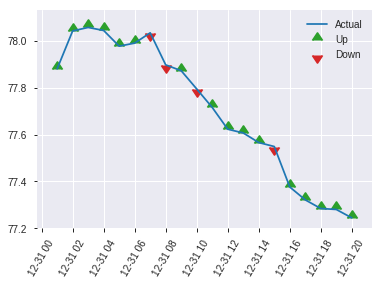


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21178884832837838
RMSE: 0.46020522414285825
LogLoss: 0.636945481475823
Mean Per-Class Error: 0.29068734735306245
AUC: 0.7592222539410663
pr_auc: 0.7208397308583316
Gini: 0.5184445078821327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26576726047355137: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      225  114  0.3363   (114.0/339.0)
1      74   205  0.2652   (74.0/279.0)
Total  299  319  0.3042   (188.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265767     0.685619  229
max f2                       0.00781038   0.811047  392
max f0point5                 0.38793      0.701092  173
max accuracy                 0.38793      0.720065  173
max precision                0.992907     1         0
max recall                   0.00781038   1         392
max specificity              0.992907     1         0
max absolute_mcc             0.38793      0.431745  173
max min_per_class_accuracy   0.303326     0.698925  215
max mean_per_class_accuracy  0.38793      0.709313  173

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 33.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.924132           1.89862   1.89862            0.857143         0.949529   0.857143                    0.949529            0.0215054       0.0215054                  89.8618    89.8618
    2        0.0210356                   0.884512           2.21505   2.04467            1                0.901793   0.923077                    0.927497            0.0215054       0.0430108                  121.505    104.467
    3        0.0307443                   0.861245           2.21505   2.09847            1                0.872263   0.947368                    0.910054            0.0215054       0.0645161                  121.505    109.847
    4        0.0404531                   0.845645           1.84588   2.03785            0.833333         0.854712   0.92                        0.896772            0.0179211       0.0824373                  84.5878    103.785
    5        0.0501618                   0.806491           1.4767    1.92924            0.666667         0.828344   0.870968                    0.883528            0.0143369       0.0967742                  47.6703    92.924
    6        0.100324                    0.690498           1.78633   1.85779            0.806452         0.74447    0.83871                     0.813999            0.0896057       0.18638                    78.6334    85.7787
    7        0.150485                    0.619269           1.78633   1.83397            0.806452         0.660095   0.827957                    0.762698            0.0896057       0.275986                   78.6334    83.3969
    8        0.200647                    0.563505           1.57197   1.76847            0.709677         0.589659   0.798387                    0.719438            0.078853        0.354839                   57.1974    76.847
    9        0.300971                    0.445497           1.39334   1.64343            0.629032         0.506773   0.741935                    0.64855             0.139785        0.494624                   39.334     64.3427
    10       0.399676                    0.36135            1.23462   1.54247            0.557377         0.403906   0.696356                    0.588131            0.121864        0.616487                   23.462     54.2467
    11       0.5                         0.28127            1.00035   1.43369            0.451613         0.321281   0.647249                    0.534589            0.100358        0.716846                   0.0346861  43.3692
    12       0.600324                    0.220594           0.678807  1.30754            0.306452         0.24876    0.590296                    0.486822            0.0681004       0.784946                   -32.1193   30.7538
    13       0.699029                    0.160783           0.871497  1.24597            0.393443         0.184923   0.5625                      0.444193            0.0860215       0.870968                   -12.8503   24.5968
    14       0.799353                    0.11039            0.392993  1.13891            0.177419         0.134237   0.51417                     0.405292            0.0394265       0.910394                   -60.7007   13.8914
    15       0.899676                    0.0502887          0.571627  1.07566            0.258065         0.0818337  0.485612                    0.369222            0.0573477       0.967742                   -42.8373   7.56556
    16       1                           0.000155605        0.32154   1                  0.145161         0.0213416  0.451456    

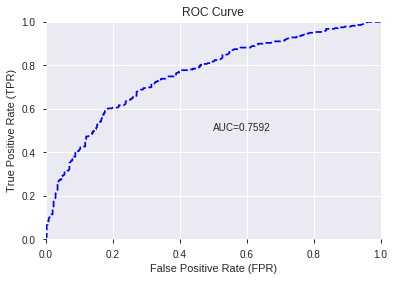

This function is available for GLM models only


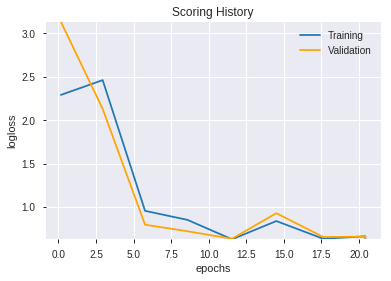

--2019-08-22 12:25:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  50.4MB/s    in 7.0s    

2019-08-22 12:25:39 (49.9 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_112516_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_112516_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_122634_model_8  0.766047  0.587566              0.316427  0.449264  0.201838
1  DeepLearning_grid_1_AutoML_20190822_122634_model_9  0.764207  0.583715              0.310004  0.445670  0.198622
2               DeepLearning_1_AutoML_20190822_122634  0.763679  0.610800              0.325277  0.460408  0.211976
3  DeepLearning_grid_1_AutoML_20190822_122634_model_6  0.761897  0.592235              0.320218  0.449527  0.202074
4  DeepLearning_grid_1_AutoML_20190822_122634_model_2  0.761517  0.592251              0.294224  0.447382  0.200150
5  DeepLearning_grid_1_AutoML_20190822_122634_model_7  0.760216  0.624239              0.331256  0.459676  0.211302
6  DeepLearning_grid_1_AutoML_20190822_122634_model_5  0.759761  0.583201              0.337473  0.447008  0.199816
7  DeepLearning_grid_1_AutoML_20190822_122634_model_4  0.755733  0.615981              0.297142  0.456900  0.208758
8  DeepLearning_grid_1_AutoML_20190822_122634_model_3  0.750077  0.636337              0.339170  0.456925  0.208780
9  DeepLearning_grid_1_AutoML_20190822_122634_model_1  0.734154  0.750577              0.332445  0.471227  0.222055

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.056934
1    CDLCLOSINGMARUBOZU             0.770772           0.770772    0.043883
2                   SUB             0.551179           0.551179    0.031381
3                   DIV             0.538211           0.538211    0.030642
4                TRANGE             0.531931           0.531931    0.030285
5          HT_TRENDMODE             0.528574           0.528574    0.030094
6             PLUS_DI_8             0.508292           0.508292    0.028939
7           CDLLONGLINE             0.456552           0.456552    0.025993
8        STOCHRSI_fastk             0.456539           0.456539    0.025992
9          STOCHF_fastk             0.415532           0.415532    0.023658
10        CDLHANGINGMAN             0.398531           0.398531    0.022690
11          CDLMARUBOZU             0.391887           0.391887    0.022312
12            CDLHAMMER             0.374061           0.374061    0.021297
13         CDLENGULFING             0.369746           0.369746    0.021051
14              WILLR_8             0.354937           0.354937    0.020208
15   CDLEVENINGDOJISTAR             0.340994           0.340994    0.019414
16                 SINH             0.334312           0.334312    0.019034
17                 COSH             0.326973           0.326973    0.018616
18       is_month_start             0.326556           0.326556    0.018592
19      CDLSHOOTINGSTAR             0.326190           0.326190    0.018571
20                  EXP             0.319316           0.319316    0.018180
21         CDLTHRUSTING             0.310460           0.310460    0.017676
22    CDLDARKCLOUDCOVER             0.309997           0.309997    0.017649
23          CDLDOJISTAR             0.307035           0.307035    0.017481
24       CDL3LINESTRIKE             0.306796           0.306796    0.017467
25   CDLIDENTICAL3CROWS             0.305965           0.305965    0.017420
26    CDL3WHITESOLDIERS             0.302118           0.302118    0.017201
27            CDLINNECK             0.301349           0.301349    0.017157
28  CDLGAPSIDESIDEWHITE             0.297550           0.297550    0.016941
29    CDLGRAVESTONEDOJI             0.294919           0.294919    0.016791
30     CDLDRAGONFLYDOJI             0.293133           0.293133    0.016689
31          CDLPIERCING             0.290193           0.290193    0.016522
32            CDLTAKURI             0.289013           0.289013    0.016455
33       CDLMORNINGSTAR             0.284533           0.284533    0.016199
34      CDLHOMINGPIGEON             0.282661           0.282661    0.016093
35      CDLUNIQUE3RIVER             0.276390           0.276390    0.015736
36         CDLTASUKIGAP             0.272757           0.272757    0.015529
37      CDLLADDERBOTTOM             0.272520           0.272520    0.015516
38         is_month_end             0.271127           0.271127    0.015436
39     is_quarter_start             0.270837           0.270837    0.015420
40            CDLONNECK             0.266511           0.266511    0.015173
41   CDLMORNINGDOJISTAR             0.262518           0.262518    0.014946
42     CDLSTICKSANDWICH             0.262487           0.262487    0.014944
43       CDLEVENINGSTAR             0.251457           0.251457    0.014316
44       CDLMATCHINGLOW             0.250161           0.250161    0.014243
45    CDLINVERTEDHAMMER             0.247960           0.247960    0.014117
46      CDLADVANCEBLOCK             0.246963           0.246963    0.014061
47           CDL3INSIDE             0.229916           0.229916    0.013090
48   CDLSEPARATINGLINES             0.195075           0.195075    0.011106
49    CDLSTALLEDPATTERN             0.190818           0.190818    0.010864

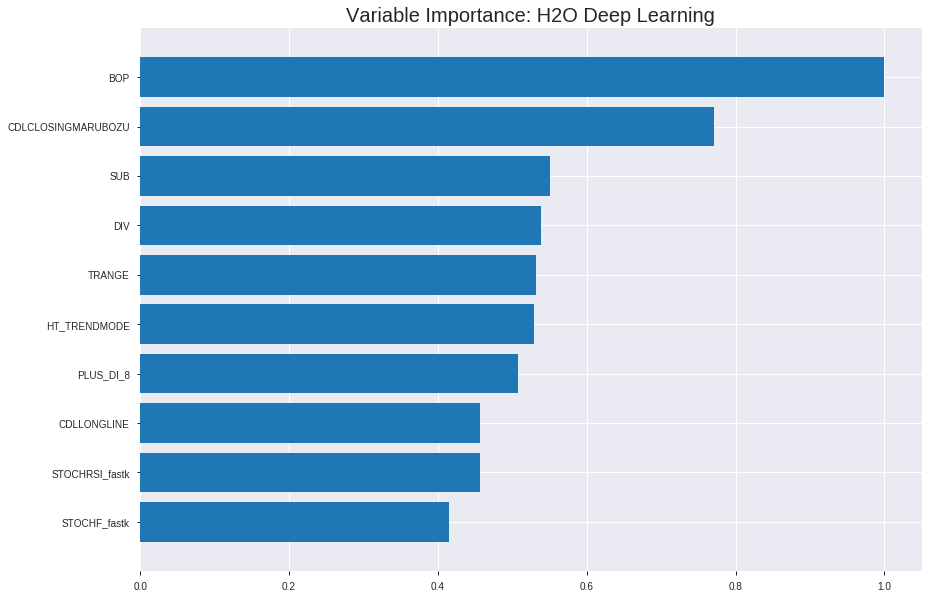

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_122634_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19600350021043178
RMSE: 0.44272282549065817
LogLoss: 0.5715769882189999
Mean Per-Class Error: 0.2987833879191122
AUC: 0.7723132271892222
pr_auc: 0.7452468473718331
Gini: 0.5446264543784445
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44119200819779425: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1065  1207  0.5312   (1207.0/2272.0)
1      220   1827  0.1075   (220.0/2047.0)
Total  1285  3034  0.3304   (1427.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441192     0.71915   239
max f2                       0.256922     0.835227  312
max f0point5                 0.540248     0.680697  178
max accuracy                 0.496034     0.697615  206
max precision                0.995747     1         0
max recall                   0.0649642    1         382
max specificity              0.995747     1         0
max absolute_mcc             0.490203     0.406641  211
max min_per_class_accuracy   0.517575     0.691744  191
max mean_per_class_accuracy  0.494648     0.701217  207

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.943933           2.01401   2.01401            0.954545         0.960942  0.954545                    0.960942            0.0205178       0.0205178                  101.401   101.401
    2        0.0201436                   0.927415           2.01178   2.01291            0.953488         0.93699   0.954023                    0.949103            0.0200293       0.0405471                  101.178   101.291
    3        0.0300996                   0.90375            1.76644   1.93139            0.837209         0.91432   0.915385                    0.937598            0.0175867       0.0581339                  76.6442   93.1386
    4        0.0400556                   0.888322           1.91365   1.92698            0.906977         0.894457  0.913295                    0.926875            0.0190523       0.0771861                  91.3646   92.6976
    5        0.0500116                   0.875097           1.86458   1.91455            0.883721         0.881282  0.907407                    0.917799            0.0185638       0.0957499                  86.4578   91.4554
    6        0.100023                    0.769947           1.84618   1.88037            0.875            0.819116  0.891204                    0.868458            0.0923302       0.18808                    84.6177   88.0366
    7        0.150035                    0.710769           1.50429   1.75501            0.712963         0.737454  0.83179                     0.82479             0.075232        0.263312                   50.4293   75.5008
    8        0.200046                    0.663703           1.5629    1.70698            0.740741         0.687083  0.809028                    0.790363            0.0781632       0.341475                   56.2901   70.6981
    9        0.300069                    0.599598           1.29428   1.56941            0.613426         0.6304    0.743827                    0.737042            0.129458        0.470933                   29.4278   56.9414
    10       0.400093                    0.554837           1.23567   1.48598            0.585648         0.576938  0.704282                    0.697016            0.123596        0.594529                   23.5669   48.5977
    11       0.500116                    0.512571           1.06961   1.4027             0.506944         0.532136  0.664815                    0.66404             0.106986        0.701514                   6.96107   40.2704
    12       0.599907                    0.486759           1.0672    1.34689            0.5058           0.498509  0.638364                    0.636505            0.106497        0.808012                   6.7197    34.6894
    13       0.699931                    0.441533           0.800987  1.26888            0.37963          0.469459  0.601389                    0.612633            0.0801172       0.888129                   -19.9013  26.8882
    14       0.799954                    0.338812           0.561668  1.18045            0.266204         0.395621  0.559479                    0.585499            0.0561798       0.944309                   -43.8332  18.0454
    15       0.899977                    0.184096           0.376073  1.09106            0.178241         0.263678  0.517108                    0.549732            0.037616        0.981925                   -62.3927  9.10556
    16       1                           0.00347399         0.18071   1                  0.0856481        0.107581  0.473952                    0.505506         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.200566660055199
RMSE: 0.44784669258039517
LogLoss: 0.5869553601242622
Mean Per-Class Error: 0.29294302665628746
AUC: 0.766874513475416
pr_auc: 0.7546505150491984
Gini: 0.533749026950832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4558286962105479: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      310  286  0.4799   (286.0/596.0)
1      95   543  0.1489   (95.0/638.0)
Total  405  829  0.3088   (381.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455829     0.740286  231
max f2                       0.174648     0.856331  351
max f0point5                 0.522894     0.725979  181
max accuracy                 0.520907     0.705024  183
max precision                0.998188     1         0
max recall                   0.0392111    1         391
max specificity              0.998188     1         0
max absolute_mcc             0.520907     0.41619   183
max min_per_class_accuracy   0.502863     0.694357  196
max mean_per_class_accuracy  0.520907     0.707057  183

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.942509           1.6366    1.6366             0.846154         0.965027  0.846154                    0.965027            0.0172414       0.0172414                  63.6605   63.6605
    2        0.0202593                   0.933874           1.93417   1.77944            1                0.938499  0.92                        0.952294            0.0188088       0.0360502                  93.4169   77.9436
    3        0.0299838                   0.899837           1.28945   1.62052            0.666667         0.913064  0.837838                    0.93957             0.0125392       0.0485893                  28.9446   62.052
    4        0.0405186                   0.888504           1.78539   1.66339            0.923077         0.893436  0.86                        0.927575            0.0188088       0.0673981                  78.5387   66.3386
    5        0.0502431                   0.876812           1.45063   1.62221            0.75             0.882797  0.83871                     0.918909            0.0141066       0.0815047                  45.0627   62.2206
    6        0.100486                    0.755964           1.7158    1.669              0.887097         0.827031  0.862903                    0.87297             0.0862069       0.167712                   71.5795   66.9001
    7        0.149919                    0.699158           1.55368   1.63098            0.803279         0.728274  0.843243                    0.825259            0.0768025       0.244514                   55.3677   63.0975
    8        0.200162                    0.634647           1.37264   1.56613            0.709677         0.664317  0.809717                    0.784861            0.0689655       0.31348                    37.2636   56.6129
    9        0.299838                    0.580726           1.43097   1.5212             0.739837         0.604782  0.786486                    0.724997            0.142633        0.456113                   43.0971   52.1198
    10       0.400324                    0.539518           1.31024   1.46825            0.677419         0.561362  0.759109                    0.683922            0.131661        0.587774                   31.0244   46.8246
    11       0.5                         0.504498           1.05357   1.38558            0.544715         0.520292  0.71637                     0.651302            0.105016        0.69279                    5.35719   38.558
    12       0.599676                    0.483657           0.896322  1.30426            0.463415         0.492829  0.674324                    0.624962            0.0893417       0.782132                   -10.3678  30.4257
    13       0.700162                    0.443206           0.857898  1.2402             0.443548         0.465926  0.641204                    0.602137            0.0862069       0.868339                   -14.2102  24.0197
    14       0.799838                    0.345588           0.644723  1.16599            0.333333         0.39934   0.602837                    0.576864            0.0642633       0.932602                   -35.5277  16.5989
    15       0.899514                    0.223618           0.377399  1.0786             0.195122         0.293018  0.557658                    0.545411            0.0376176       0.970219                   -62.2601  7.86043
    16       1                           0.00901024         0.296365  1                  0.153226         0.127688  0.517018                    0.503436           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:37:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:37:15  3 min  6.037 sec  534 obs/sec       0.22621   1             977        0.59864          1.13871             -0.437383      0.731074        0.695838           1.91811          0.373235                         0.568421           1.01467               -0.293908        0.745945          0.73634              1.48782            0.324959
    2019-08-22 12:37:39  3 min 30.097 sec  1100 obs/sec      5.97986   27            25827      0.44661          0.580693            0.199987       0.765074        0.739717           2.06196          0.342209                         0.448465           0.587725              0.194584         0.768171          0.757044             1.78539            0.32577
    2019-08-22 12:38:03  3 min 54.386 sec  1245 obs/sec      13.0845   59            56512      0.442807         0.572963            0.213553       0.76934         0.740061           2.06196          0.329937                         0.450658           0.593738              0.186687         0.764058          0.746697             1.48782            0.324149
    2019-08-22 12:38:27  4 min 18.466 sec  1329 obs/sec      20.6363   93            89128      0.442723         0.571577            0.213852       0.772313        0.745247           2.01401          0.330401                         0.447847           0.586955              0.196803         0.766875          0.754651             1.6366             0.308752
    2019-08-22 12:38:51  4 min 42.759 sec  1403 obs/sec      28.9009   130           124823     0.439688         0.567088            0.224594       0.774315        0.743158           2.06196          0.318824                         0.449603           0.601408              0.190491         0.766317          0.751585             1.6366             0.308752
    2019-08-22 12:39:16  5 min  7.154 sec  1463 obs/sec      37.5735   169           162280     0.443591         0.576543            0.210767       0.777637        0.752044           2.06196          0.322297                         0.449299           0.601225              0.191585         0.766034          0.751894             1.6366             0.32577
    2019-08-22 12:39:40  5 min 31.462 sec  1506 obs/sec      46.2973   208           199958     0.436638         0.558372            0.235313       0.781043        0.758498           2.06196          0.315582                         0.454309           0.604607              0.173456         0.760717          0.747925             1.6366             0.324149
    2019-08-22 12:39:42  5 min 33.914 sec  1505 obs/sec      46.2973   208           199958     0.442723         0.571577            0.213852       0.772313        0.745247           2.01401          0.330401                         0.447847           0.586955              0.196803         0.766875          0.754651             1.6366             0.308752

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05693365837168559
CDLCLOSINGMARUBOZU  0.7707722187042236     0.7707722187042236   0.043882882182092395
SUB                 0.5511786341667175     0.5511786341667175   0.03138061605942016
DIV                 0.5382105112075806     0.5382105112075806   0.030642293377142648
TRANGE              0.5319305658340454     0.5319305658340454   0.03028475311265295
---                 ---                    ---                  ---
CDLINVERTEDHAMMER   0.24795953929424286    0.24795953929424286  0.014117243700178972
CDLADVANCEBLOCK     0.24696309864521027    0.24696309864521027  0.01406051268867929
CDL3INSIDE          0.2299155443906784     0.2299155443906784   0.013089933058678997
CDLSEPARATINGLINES  0.19507476687431335    0.19507476687431335  0.011106320134158364
CDLSTALLEDPATTERN   0.1908179372549057     0.1908179372549057   0.010863963250860536


See the whole table with table.as_data_frame()


('accuracy', 0.7071197411003236)

('F1', 0.6927710843373494)

('auc', 0.7660470919106374)

('logloss', 0.5875660011654584)

('mean_per_class_error', 0.29612712912741457)

('rmse', 0.44926367068878154)

('mse', 0.20183784580075792)

deeplearning prediction progress: |███████████████████████████████████████| 100%


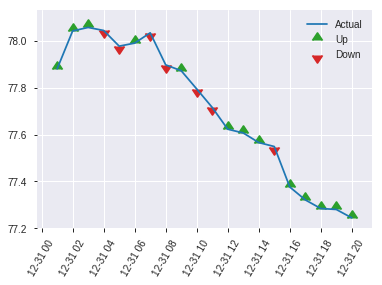


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20183784580075792
RMSE: 0.44926367068878154
LogLoss: 0.5875660011654584
Mean Per-Class Error: 0.29612712912741457
AUC: 0.7660470919106374
pr_auc: 0.7116072335533862
Gini: 0.5320941838212747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4745233153593927: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      184  155  0.4572   (155.0/339.0)
1      49   230  0.1756   (49.0/279.0)
Total  233  385  0.3301   (204.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474523     0.692771  234
max f2                       0.34837      0.825632  307
max f0point5                 0.564155     0.690454  146
max accuracy                 0.564155     0.70712   146
max precision                0.99704      1         0
max recall                   0.104131     1         381
max specificity              0.99704      1         0
max absolute_mcc             0.564155     0.408024  146
max min_per_class_accuracy   0.504455     0.696165  198
max mean_per_class_accuracy  0.500044     0.703873  203

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 49.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.939351           2.21505   2.21505            1                0.95226   1                           0.95226             0.0250896       0.0250896                  121.505   121.505
    2        0.0210356                   0.91438            1.84588   2.04467            0.833333         0.928419  0.923077                    0.941256            0.0179211       0.0430108                  84.5878   104.467
    3        0.0307443                   0.890719           1.4767    1.86531            0.666667         0.902786  0.842105                    0.929108            0.0143369       0.0573477                  47.6703   86.5308
    4        0.0404531                   0.866714           1.4767    1.77204            0.666667         0.877897  0.8                         0.916817            0.0143369       0.0716846                  47.6703   77.2043
    5        0.0501618                   0.860841           1.84588   1.78633            0.833333         0.86428   0.806452                    0.906649            0.0179211       0.0896057                  84.5878   78.6334
    6        0.100324                    0.74133            1.85779   1.82206            0.83871          0.797368  0.822581                    0.852008            0.09319         0.182796                   85.7787   82.206
    7        0.150485                    0.68347            1.50052   1.71488            0.677419         0.71024   0.774194                    0.804752            0.0752688       0.258065                   50.052    71.488
    8        0.200647                    0.65042            1.57197   1.67915            0.709677         0.667736  0.758065                    0.770498            0.078853        0.336918                   57.1974   67.9154
    9        0.300971                    0.573438           1.67915   1.67915            0.758065         0.609061  0.758065                    0.716686            0.168459        0.505376                   67.9154   67.9154
    10       0.399676                    0.529437           1.05306   1.52453            0.47541          0.549813  0.688259                    0.675474            0.103943        0.609319                   5.30583   52.4531
    11       0.5                         0.497089           1.10753   1.44086            0.5              0.513637  0.650485                    0.643002            0.111111        0.72043                    10.7527   44.086
    12       0.600324                    0.478499           0.785987  1.33142            0.354839         0.487127  0.601078                    0.616953            0.078853        0.799283                   -21.4013  33.142
    13       0.699029                    0.442397           0.762559  1.2511             0.344262         0.463763  0.564815                    0.595322            0.0752688       0.874552                   -23.7441  25.1095
    14       0.799353                    0.368862           0.714533  1.18375            0.322581         0.413108  0.534413                    0.572453            0.0716846       0.946237                   -28.5467  18.3753
    15       0.899676                    0.208732           0.250087  1.07964            0.112903         0.298217  0.48741                     0.541873            0.0250896       0.971326                   -74.9913  7.96395
    16       1                           0.0234395          0.285813  1                  0.129032         0.121205  0.451456                    0.49967             0

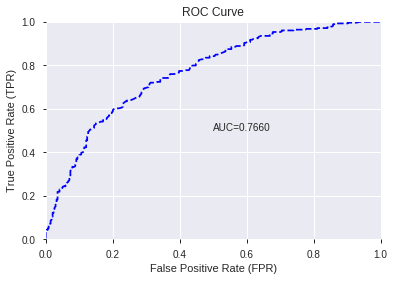

This function is available for GLM models only


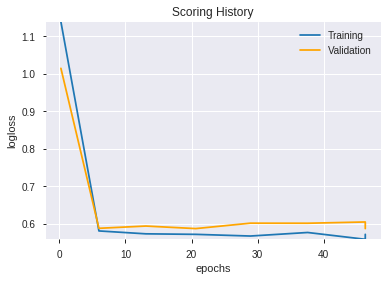

--2019-08-22 12:43:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_122634_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_122634_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'DIV',
 'TRANGE',
 'HT_TRENDMODE',
 'PLUS_DI_8',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'CDLENGULFING',
 'WILLR_8',
 'CDLEVENINGDOJISTAR',
 'SINH',
 'COSH',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'EXP',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'CDLDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'CDLINNECK',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLPIERCING',
 'CDLTAKURI',
 'CDLMORNINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'CDLLADDERBOTTOM',
 'is_month_end',
 'is_quarter_start',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'CDL3INSIDE',
 'CDLSEPARATINGLINES',
 'CDLSTALLEDPATTERN']

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124448_model_1  0.769314  0.572519              0.302741  0.440714  0.194229

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.706489           1.000000    0.183608
1    CDLCLOSINGMARUBOZU             0.326077           0.461546    0.084744
2             PLUS_DI_8             0.222934           0.315552    0.057938
3          STOCHF_fastk             0.206774           0.292679    0.053738
4             CDLHAMMER             0.165863           0.234771    0.043106
5             CDLTAKURI             0.131418           0.186016    0.034154
6                   SUB             0.122648           0.173602    0.031875
7         CDLHANGINGMAN             0.116440           0.164815    0.030262
8       CDLSHOOTINGSTAR             0.112220           0.158842    0.029165
9        STOCHRSI_fastk             0.109037           0.154336    0.028337
10               TRANGE             0.104804           0.148344    0.027237
11    CDLDARKCLOUDCOVER             0.103210           0.146089    0.026823
12   CDLEVENINGDOJISTAR             0.096444           0.136511    0.025065
13          CDLMARUBOZU             0.079254           0.112180    0.020597
14            CDLONNECK             0.071502           0.101208    0.018583
15              WILLR_8             0.069381           0.098206    0.018031
16    CDL3WHITESOLDIERS             0.068988           0.097649    0.017929
17                  DIV             0.068237           0.096586    0.017734
18     CDLSTICKSANDWICH             0.065082           0.092121    0.016914
19      CDLLADDERBOTTOM             0.060362           0.085439    0.015687
20      CDLHOMINGPIGEON             0.060334           0.085400    0.015680
21          CDLPIERCING             0.055625           0.078734    0.014456
22         CDLENGULFING             0.054233           0.076764    0.014094
23       CDLMORNINGSTAR             0.049210           0.069654    0.012789
24   CDLMORNINGDOJISTAR             0.046929           0.066425    0.012196
25      CDLUNIQUE3RIVER             0.043893           0.062129    0.011407
26            CDLINNECK             0.042132           0.059636    0.010950
27   CDLIDENTICAL3CROWS             0.041477           0.058708    0.010779
28    CDLGRAVESTONEDOJI             0.040589           0.057452    0.010549
29         CDLTASUKIGAP             0.038012           0.053804    0.009879
30       CDL3LINESTRIKE             0.037950           0.053716    0.009863
31       CDLEVENINGSTAR             0.035259           0.049907    0.009163
32          CDLLONGLINE             0.029032           0.041093    0.007545
33          CDLDOJISTAR             0.027488           0.038907    0.007144
34           CDL3INSIDE             0.025498           0.036091    0.006627
35      CDLADVANCEBLOCK             0.024632           0.034865    0.006402
36  CDLGAPSIDESIDEWHITE             0.024071           0.034071    0.006256
37       CDLMATCHINGLOW             0.023804           0.033693    0.006186
38                 COSH             0.020574           0.029121    0.005347
39                  EXP             0.020280           0.028705    0.005270
40                 SINH             0.020048           0.028376    0.005210
41    CDLSTALLEDPATTERN             0.019746           0.027949    0.005132
42       is_month_start             0.017339           0.024542    0.004506
43   CDLSEPARATINGLINES             0.013338           0.018880    0.003466
44         HT_TRENDMODE             0.011879           0.016814    0.003087
45     CDLDRAGONFLYDOJI             0.005697           0.008064    0.001481
46         CDLTHRUSTING             0.005288           0.007484    0.001374
47         is_month_end             0.003322           0.004702    0.000863
48     is_quarter_start             0.002172           0.003075    0.000565
49    CDLINVERTEDHAMMER             0.000788           0.001115    0.000205

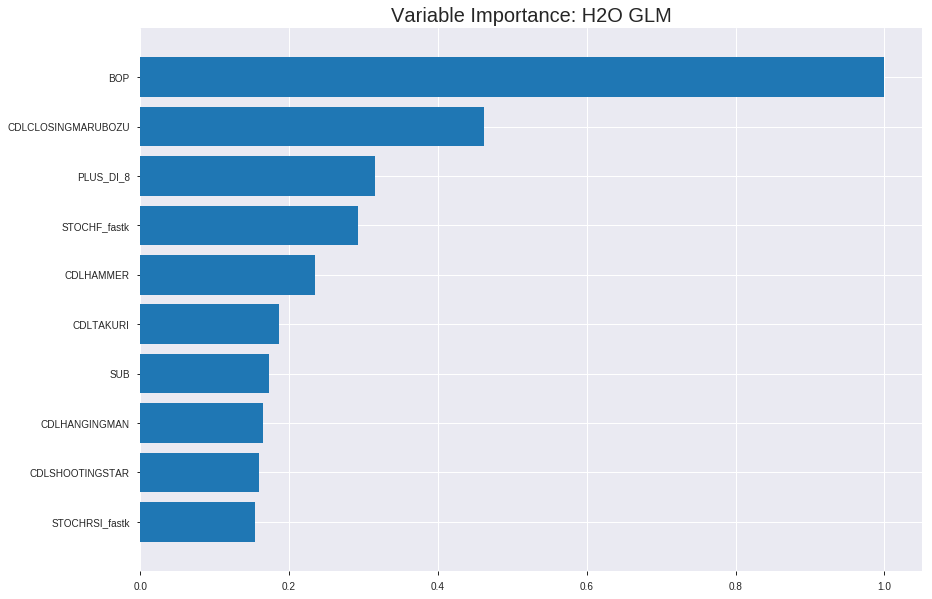

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124448_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1964662567110015
RMSE: 0.4432451429074001
LogLoss: 0.5736498632156859
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5975.678574739547
Residual deviance: 4955.1875184570945
AIC: 5057.1875184570945
AUC: 0.7643124256039412
pr_auc: 0.7417787958516405
Gini: 0.5286248512078824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36216386288527724: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1144  1128  0.4965   (1128.0/2272.0)
1      282   1765  0.1378   (282.0/2047.0)
Total  1426  2893  0.3265   (1410.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362164     0.714575  259
max f2                       0.100448     0.829401  369
max f0point5                 0.559911     0.679252  160
max accuracy                 0.508389     0.690438  188
max precision                0.984803     1         0
max recall                   0.0571817    1         387
max specificity              0.984803     1         0
max absolute_mcc             0.362164     0.38835   259
max min_per_class_accuracy   0.489643     0.6875    197
max mean_per_class_accuracy  0.467913     0.69139   207

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.90796            2.10992   2.10992            1                0.935087  1                           0.935087            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.889326           1.91365   2.01291            0.906977         0.897308  0.954023                    0.916414            0.0190523       0.0405471                  91.3646   101.291
    3        0.0300996                   0.876497           1.91365   1.98008            0.906977         0.882776  0.938462                    0.905288            0.0190523       0.0595994                  91.3646   98.0076
    4        0.0400556                   0.862975           2.01178   1.98796            0.953488         0.869794  0.942197                    0.896466            0.0200293       0.0796287                  101.178   98.7956
    5        0.0500116                   0.851236           1.96271   1.98293            0.930233         0.857633  0.939815                    0.888735            0.0195408       0.0991695                  96.2713   98.2931
    6        0.100023                    0.760935           1.70942   1.84618            0.810185         0.804413  0.875                       0.846574            0.085491        0.18466                    70.9423   84.6177
    7        0.150035                    0.713053           1.5629    1.75175            0.740741         0.73697   0.830247                    0.810039            0.0781632       0.262824                   56.2901   75.1752
    8        0.200046                    0.675912           1.49452   1.68745            0.708333         0.694828  0.799769                    0.781236            0.0747435       0.337567                   49.4525   68.7445
    9        0.300069                    0.611486           1.31381   1.5629             0.622685         0.643038  0.740741                    0.73517             0.131412        0.468979                   31.3814   56.2901
    10       0.400093                    0.55193            1.24055   1.48231            0.587963         0.58092   0.702546                    0.696608            0.124084        0.593063                   24.0553   48.2314
    11       0.500116                    0.480849           1.05496   1.39684            0.5              0.516881  0.662037                    0.660662            0.10552         0.698583                   5.49585   39.6843
    12       0.599907                    0.41436            0.974184  1.32654            0.461717         0.447149  0.628715                    0.625145            0.0972154       0.795799                   -2.58156  32.6536
    13       0.699931                    0.336843           0.884016  1.2633             0.418981         0.3761    0.598743                    0.589556            0.0884221       0.884221                   -11.5984  26.3298
    14       0.799954                    0.261001           0.5519    1.17435            0.261574         0.298359  0.556585                    0.553146            0.0552027       0.939424                   -44.81    17.4347
    15       0.899977                    0.160641           0.361421  1.084              0.171296         0.21701   0.513764                    0.515788            0.0361505       0.975574                   -63.8579  8.3999
    16       1                           0.013709           0.244203  1                  0.115741         0.097531  0.473952                    0.473952          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19825287338465425
RMSE: 0.4452559638956611
LogLoss: 0.5815435192939105
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1718.4207619926892
Residual deviance: 1435.2494056173712
AIC: 1537.2494056173712
AUC: 0.7696976709936673
pr_auc: 0.754614465764292
Gini: 0.5393953419873345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33356869315017407: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      281  315  0.5285   (315.0/596.0)
1      74   564  0.116    (74.0/638.0)
Total  355  879  0.3152   (389.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333569     0.743573  270
max f2                       0.122442     0.856719  362
max f0point5                 0.48287      0.726384  200
max accuracy                 0.48287      0.713128  200
max precision                0.989297     1         0
max recall                   0.0278624    1         396
max specificity              0.989297     1         0
max absolute_mcc             0.48287      0.427045  200
max min_per_class_accuracy   0.471416     0.709732  205
max mean_per_class_accuracy  0.48287      0.713624  200

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.90304            1.48782   1.48782            0.769231         0.941742  0.769231                    0.941742            0.015674        0.015674                   48.7823   48.7823
    2        0.0202593                   0.889198           1.61181   1.54734            0.833333         0.896222  0.8                         0.919893            0.015674        0.031348                   61.1808   54.7335
    3        0.0299838                   0.873826           1.77299   1.62052            0.916667         0.8822    0.837838                    0.907668            0.0172414       0.0485893                  77.2989   62.052
    4        0.0405186                   0.860162           1.78539   1.66339            0.923077         0.869055  0.86                        0.897629            0.0188088       0.0673981                  78.5387   66.3386
    5        0.0502431                   0.844005           1.45063   1.62221            0.75             0.852368  0.83871                     0.888869            0.0141066       0.0815047                  45.0627   62.2206
    6        0.100486                    0.750128           1.6846    1.6534             0.870968         0.795348  0.854839                    0.842108            0.0846395       0.166144                   68.4599   65.3403
    7        0.149919                    0.694412           1.55368   1.62052            0.803279         0.718106  0.837838                    0.801221            0.0768025       0.242947                   55.3677   62.052
    8        0.200162                    0.658901           1.49742   1.58962            0.774194         0.677205  0.821862                    0.770092            0.0752351       0.318182                   49.7421   58.9621
    9        0.299838                    0.598373           1.39952   1.52643            0.723577         0.627358  0.789189                    0.722642            0.139498        0.45768                    39.9521   52.6425
    10       0.400324                    0.539525           1.31024   1.47216            0.677419         0.571247  0.761134                    0.68464             0.131661        0.589342                   31.0244   47.2161
    11       0.5                         0.477808           1.16365   1.41066            0.601626         0.509404  0.729335                    0.649707            0.115987        0.705329                   16.3647   41.0658
    12       0.599676                    0.409068           0.754798  1.30164            0.390244         0.440937  0.672973                    0.615006            0.0752351       0.780564                   -24.5202  30.1644
    13       0.700162                    0.342211           0.904692  1.24467            0.467742         0.374568  0.643519                    0.580498            0.0909091       0.871473                   -9.53079  24.4674
    14       0.799838                    0.267681           0.550373  1.15815            0.284553         0.302322  0.598784                    0.545832            0.0548589       0.926332                   -44.9627  15.815
    15       0.899514                    0.175882           0.550373  1.0908             0.284553         0.229159  0.563964                    0.510741            0.0548589       0.981191                   -44.9627  9.08018
    16       1                           0.00476676         0.187178  1                  0.0967742        0.101547  0.517018                    0.469623            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:44:49  0.000 sec   2            .2E2      51            1.3683029018767774  1.3772648452146852
     2019-08-22 12:44:49  0.066 sec   4            .12E2     51            1.360015778882494   1.3689399612270474
     2019-08-22 12:44:49  0.126 sec   6            .76E1     51            1.348043321909268   1.3568809762830307
     2019-08-22 12:44:49  0.179 sec   8            .47E1     51            1.331655935182693   1.3403135814856202
     2019-08-22 12:44:50  0.231 sec   10           .29E1     51            1.3108066634771673  1.3191273896149067
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:44:50  0.898 sec   36           .6E-2     51            1.1464760795407571  1.1635081171289392
     2019-08-22 12:44:50  0.921 sec   37           .37E-2    51            1.1460235612016476  1.1641179595249511
     2019-08-22 12:44:50  0.949 sec   38           .23E-2    51            1.1457490426137904  1.1649835141964608
     2019-08-22 12:44:50  0.971 sec   39           .14E-2    51            1.1455635618655216  1.165932936057974
     2019-08-22 12:44:50  1.000 sec   40           .9E-3     51            1.1454117338013277  1.1668785717415326


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7103559870550162)

('F1', 0.6970172684458398)

('auc', 0.7693141328596652)

('logloss', 0.5725190931327565)

('mean_per_class_error', 0.29601611317283605)

('rmse', 0.44071420275167306)

('mse', 0.1942290085070428)

glm prediction progress: |████████████████████████████████████████████████| 100%


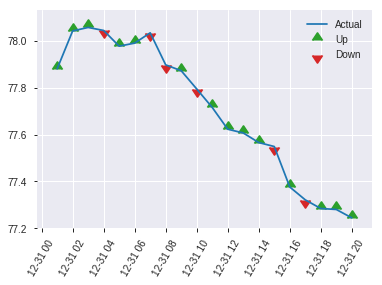


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1942290085070428
RMSE: 0.44071420275167306
LogLoss: 0.5725190931327565
Null degrees of freedom: 617
Residual degrees of freedom: 567
Null deviance: 852.1522922482045
Residual deviance: 707.6335991120872
AIC: 809.6335991120872
AUC: 0.7693141328596652
pr_auc: 0.7398311886776643
Gini: 0.5386282657193304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37890225461649113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      203  136  0.4012   (136.0/339.0)
1      57   222  0.2043   (57.0/279.0)
Total  260  358  0.3123   (193.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378902     0.697017  238
max f2                       0.10533      0.813679  370
max f0point5                 0.589081     0.698351  128
max accuracy                 0.589081     0.710356  128
max precision                0.98537      1         0
max recall                   0.0581466    1         390
max specificity              0.98537      1         0
max absolute_mcc             0.589081     0.417882  128
max min_per_class_accuracy   0.454415     0.693215  203
max mean_per_class_accuracy  0.425589     0.703984  217

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.897197           2.21505   2.21505            1                0.921067   1                           0.921067            0.0250896       0.0250896                  121.505    121.505
    2        0.0210356                   0.884269           2.21505   2.21505            1                0.88989    1                           0.906678            0.0215054       0.046595                   121.505    121.505
    3        0.0307443                   0.872503           1.84588   2.09847            0.833333         0.879003   0.947368                    0.897938            0.0179211       0.0645161                  84.5878    109.847
    4        0.0404531                   0.849869           1.84588   2.03785            0.833333         0.865301   0.92                        0.890105            0.0179211       0.0824373                  84.5878    103.785
    5        0.0501618                   0.822922           1.84588   2.00069            0.833333         0.838091   0.903226                    0.880038            0.0179211       0.100358                   84.5878    100.069
    6        0.100324                    0.741641           1.78633   1.89351            0.806452         0.776651   0.854839                    0.828344            0.0896057       0.189964                   78.6334    89.3514
    7        0.150485                    0.700164           2.00069   1.92924            0.903226         0.719817   0.870968                    0.792169            0.100358        0.290323                   100.069    92.924
    8        0.200647                    0.667879           1.42907   1.8042             0.645161         0.683576   0.814516                    0.76502             0.0716846       0.362007                   42.9067    80.4197
    9        0.300971                    0.589226           1.46479   1.69106            0.66129          0.631732   0.763441                    0.720591            0.146953        0.508961                   46.4794    69.1063
    10       0.399676                    0.512614           1.08937   1.54247            0.491803         0.545651   0.696356                    0.677387            0.107527        0.616487                   8.93707    54.2467
    11       0.5                         0.435427           1.00035   1.43369            0.451613         0.478515   0.647249                    0.637484            0.100358        0.716846                   0.0346861  43.3692
    12       0.600324                    0.3712             0.928894  1.34933            0.419355         0.400374   0.609164                    0.597859            0.09319         0.810036                   -7.11065   34.9332
    13       0.699029                    0.317485           0.726247  1.26135            0.327869         0.346674   0.569444                    0.562391            0.0716846       0.88172                    -27.3753   26.135
    14       0.799353                    0.256363           0.32154   1.1434             0.145161         0.284127   0.516194                    0.527467            0.0322581       0.913978                   -67.846    14.3398
    15       0.899676                    0.146842           0.5359    1.07566            0.241935         0.210622   0.485612                    0.492135            0.0537634       0.967742                   -46.41     7.56556
    16       1                           0.00869816         0.32154   1                  0.145161         0.0923764  0.451456    

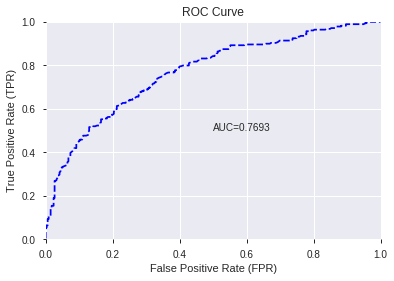

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


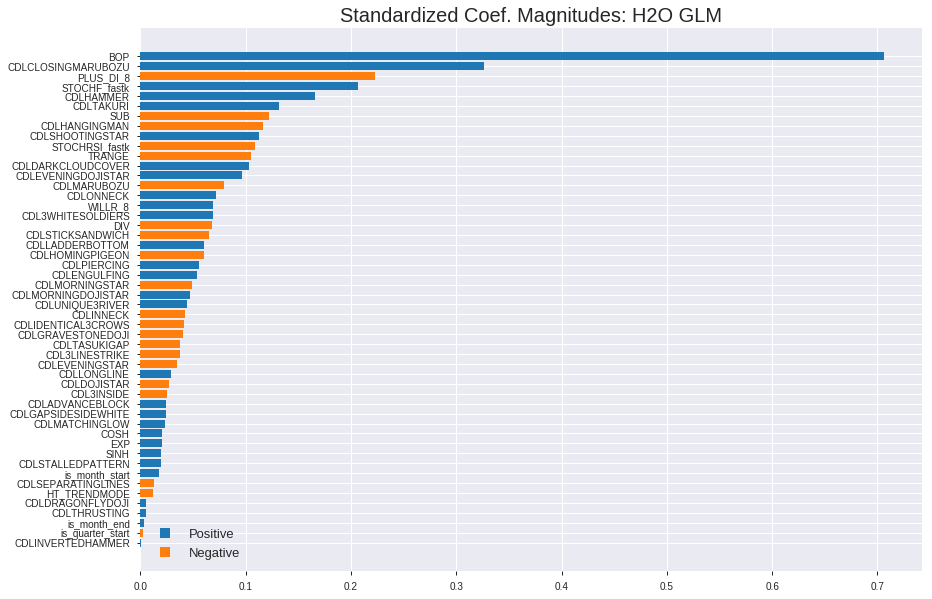

'log_likelihood'
--2019-08-22 12:45:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124448_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124448_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'CDLHAMMER',
 'CDLTAKURI',
 'SUB',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLMARUBOZU',
 'CDLONNECK',
 'WILLR_8',
 'CDL3WHITESOLDIERS',
 'DIV',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLHOMINGPIGEON',
 'CDLPIERCING',
 'CDLENGULFING',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'CDLIDENTICAL3CROWS',
 'CDLGRAVESTONEDOJI',
 'CDLTASUKIGAP',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLLONGLINE',
 'CDLDOJISTAR',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDLMATCHINGLOW',
 'COSH',
 'EXP',
 'SINH',
 'CDLSTALLEDPATTERN',
 'is_month_start',
 'CDLSEPARATINGLINES',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTHRUSTING',
 'is_month_end',
 'is_quarter_start',
 'CDLINVERTEDHAMMER']

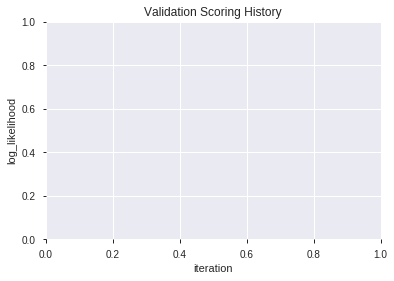

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124600_model_3  0.776847  0.571361              0.308307  0.440130  0.193715
1               XGBoost_3_AutoML_20190822_124600  0.775520  0.573694              0.289260  0.441402  0.194835
2  XGBoost_grid_1_AutoML_20190822_124600_model_2  0.774003  0.577173              0.304723  0.442686  0.195971
3  XGBoost_grid_1_AutoML_20190822_124600_model_6  0.773623  0.573415              0.309782  0.441155  0.194618
4  XGBoost_grid_1_AutoML_20190822_124600_model_1  0.771656  0.575090              0.298411  0.442244  0.195580
5               XGBoost_1_AutoML_20190822_124600  0.769208  0.574826              0.291163  0.442206  0.195546
6  XGBoost_grid_1_AutoML_20190822_124600_model_4  0.766523  0.578753              0.298522  0.443915  0.197060
7               XGBoost_2_AutoML_20190822_124600  0.762204  0.579357              0.314936  0.444679  0.197740
8  XGBoost_grid_1_AutoML_20190822_124600_model_7  0.761289  0.578950              0.334317  0.444697  0.197756
9  XGBoost_grid_1_AutoML_20190822_124600_model_5  0.755347  0.590027              0.322422  0.448331  0.201001

variable  relative_importance  scaled_importance  percentage
0                  BOP          3961.562988           1.000000    0.339331
1         STOCHF_fastk          1013.510681           0.255836    0.086813
2            PLUS_DI_8           935.131775           0.236051    0.080099
3       STOCHRSI_fastk           919.226318           0.232036    0.078737
4                  DIV           862.230286           0.217649    0.073855
5   CDLCLOSINGMARUBOZU           626.027222           0.158025    0.053623
6                 COSH           623.575745           0.157406    0.053413
7              WILLR_8           581.434814           0.146769    0.049803
8               TRANGE           539.769470           0.136252    0.046234
9                  SUB           465.500488           0.117504    0.039873
10                 EXP           282.933380           0.071420    0.024235
11           CDLHAMMER           207.610672           0.052406    0.017783
12         CDLLONGLINE           125.035065           0.031562    0.010710
13        CDLENGULFING            98.362762           0.024829    0.008425
14                SINH            77.972847           0.019682    0.006679
15    CDLDRAGONFLYDOJI            77.964104           0.019680    0.006678
16           CDLTAKURI            72.108124           0.018202    0.006176
17        HT_TRENDMODE            51.705925           0.013052    0.004429
18       CDLHANGINGMAN            49.948067           0.012608    0.004278
19     CDLSHOOTINGSTAR            42.807606           0.010806    0.003667
20   CDLGRAVESTONEDOJI            38.597454           0.009743    0.003306
21     CDLADVANCEBLOCK             9.137257           0.002306    0.000783
22         CDLMARUBOZU             8.244114           0.002081    0.000706
23        is_month_end             4.239392           0.001070    0.000363

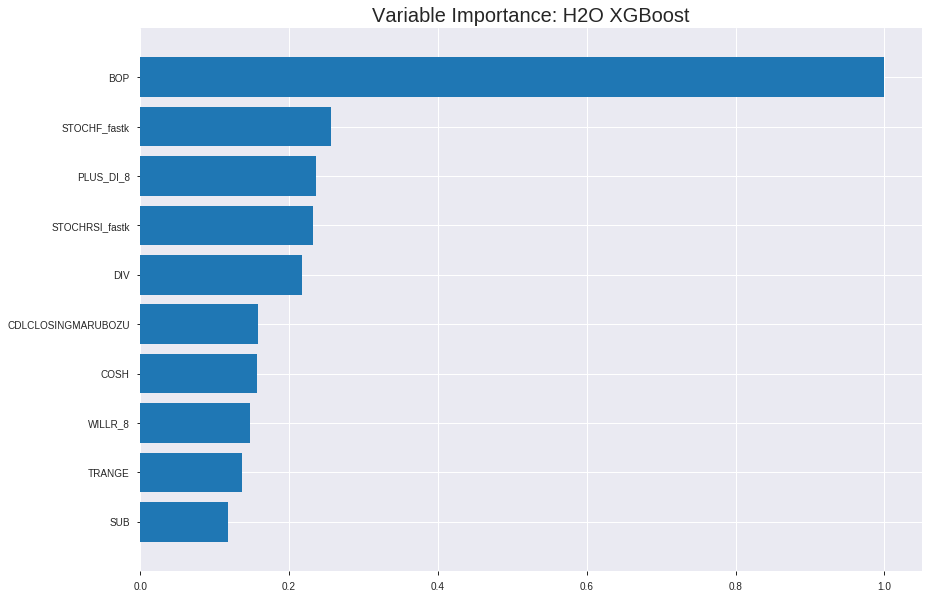

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124600_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17490246739438536
RMSE: 0.418213423259447
LogLoss: 0.5221815710357055
Mean Per-Class Error: 0.26425415585845313
AUC: 0.8231933583671054
pr_auc: 0.8062587325505556
Gini: 0.6463867167342108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4211069196462631: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1320  952   0.419    (952.0/2272.0)
1      265   1782  0.1295   (265.0/2047.0)
Total  1585  2734  0.2818   (1217.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421107     0.745451  236
max f2                       0.28115      0.850204  294
max f0point5                 0.563454     0.738698  159
max accuracy                 0.527002     0.734661  181
max precision                0.953403     1         0
max recall                   0.0880215    1         381
max specificity              0.953403     1         0
max absolute_mcc             0.476852     0.472889  209
max min_per_class_accuracy   0.509529     0.729313  190
max mean_per_class_accuracy  0.493336     0.735746  200

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.935945           2.10992    2.10992            1                0.944566   1                           0.944566            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.911095           2.10992    2.10992            1                0.923279   1                           0.934045            0.0210064       0.0425012                  110.992   110.992
    3        0.0300996                   0.896519           2.06085    2.09369            0.976744         0.90401    0.992308                    0.924111            0.0205178       0.0630191                  106.085   109.369
    4        0.0400556                   0.874842           2.01178    2.07333            0.953488         0.885863   0.982659                    0.914604            0.0200293       0.0830484                  101.178   107.333
    5        0.0500116                   0.858426           2.06085    2.07084            0.976744         0.867196   0.981481                    0.905166            0.0205178       0.103566                   106.085   107.084
    6        0.100023                    0.754933           1.87548    1.97316            0.888889         0.806445   0.935185                    0.855805            0.0937958       0.197362                   87.5482   97.3163
    7        0.150035                    0.693779           1.79734    1.91455            0.851852         0.723952   0.907407                    0.811854            0.0898876       0.28725                    79.7337   91.4554
    8        0.200046                    0.652402           1.67035    1.8535             0.791667         0.673774   0.878472                    0.777334            0.0835369       0.370787                   67.0351   85.3503
    9        0.300069                    0.593142           1.39684    1.70128            0.662037         0.620294   0.806327                    0.724987            0.139717        0.510503                   39.6843   70.1283
    10       0.400093                    0.547645           1.28939    1.59831            0.611111         0.56972    0.757523                    0.68617             0.128969        0.639472                   28.9394   59.8311
    11       0.500116                    0.504126           1.04519    1.48769            0.49537          0.526147   0.705093                    0.654166            0.104543        0.744016                   4.51903   48.7687
    12       0.599907                    0.444061           0.939917   1.39657            0.445476         0.475353   0.661907                    0.624421            0.0937958       0.837811                   -6.00834  39.6568
    13       0.699931                    0.351302           0.820523   1.31425            0.388889         0.402084   0.622891                    0.592648            0.0820713       0.919883                   -17.9477  31.4249
    14       0.799954                    0.246407           0.449334   1.2061             0.212963         0.299594   0.571635                    0.556006            0.0449438       0.964827                   -55.0666  20.6103
    15       0.899977                    0.143267           0.28816    1.10408            0.136574         0.193063   0.523283                    0.515669            0.0288227       0.993649                   -71.184   10.4083
    16       1                           0.031855           0.0634929  1                  0.0300926        0.0989657  0.473952 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19782608071047697
RMSE: 0.4447764390235582
LogLoss: 0.5786839350405326
Mean Per-Class Error: 0.3015111190591404
AUC: 0.7688863583766384
pr_auc: 0.7649104814811253
Gini: 0.5377727167532769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35452701151371: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      276  320  0.5369   (320.0/596.0)
1      62   576  0.0972   (62.0/638.0)
Total  338  896  0.3096   (382.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354527     0.750978  274
max f2                       0.21478      0.85312   334
max f0point5                 0.506558     0.71134   189
max accuracy                 0.462929     0.700162  215
max precision                0.950064     1         0
max recall                   0.0998983    1         384
max specificity              0.950064     1         0
max absolute_mcc             0.378656     0.410103  263
max min_per_class_accuracy   0.486703     0.688088  202
max mean_per_class_accuracy  0.462929     0.698489  215

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.928681           1.78539   1.78539            0.923077         0.938082  0.923077                    0.938082            0.0188088       0.0188088                  78.5387   78.5387
    2        0.0202593                   0.90853            1.77299   1.77944            0.916667         0.915715  0.92                        0.927346            0.0172414       0.0360502                  77.2989   77.9436
    3        0.0299838                   0.861015           1.77299   1.77734            0.916667         0.890857  0.918919                    0.915511            0.0172414       0.0532915                  77.2989   77.7345
    4        0.0405186                   0.842437           1.78539   1.77944            0.923077         0.851205  0.92                        0.898792            0.0188088       0.0721003                  78.5387   77.9436
    5        0.0502431                   0.824605           1.61181   1.74699            0.833333         0.831567  0.903226                    0.88578             0.015674        0.0877743                  61.1808   74.6992
    6        0.100486                    0.7468             1.62221   1.6846             0.83871          0.785885  0.870968                    0.835833            0.0815047       0.169279                   62.2206   68.4599
    7        0.149919                    0.68083            1.52197   1.63098            0.786885         0.70927   0.843243                    0.794101            0.0752351       0.244514                   52.1969   63.0975
    8        0.200162                    0.641477           1.49742   1.59745            0.774194         0.659142  0.825911                    0.760225            0.0752351       0.319749                   49.7421   59.7452
    9        0.299838                    0.583905           1.3209    1.50552            0.682927         0.610421  0.778378                    0.710425            0.131661        0.451411                   32.0896   50.5516
    10       0.400324                    0.531641           1.26345   1.44475            0.653226         0.556495  0.746964                    0.671787            0.126959        0.57837                    26.3449   44.4754
    11       0.5                         0.487837           1.05357   1.36677            0.544715         0.510356  0.706645                    0.639605            0.105016        0.683386                   5.35719   36.6771
    12       0.599676                    0.441549           0.959222  1.29903            0.495935         0.465991  0.671622                    0.610748            0.0956113       0.778997                   -4.07778  29.903
    13       0.700162                    0.378537           1.01388   1.25811            0.524194         0.411713  0.650463                    0.582183            0.101881        0.880878                   1.38791   25.8105
    14       0.799838                    0.2706             0.566098  1.17187            0.292683         0.326644  0.605876                    0.550337            0.0564263       0.937304                   -43.3902  17.1868
    15       0.899514                    0.1852             0.377399  1.08383            0.195122         0.228136  0.56036                     0.514634            0.0376176       0.974922                   -62.2601  8.38318
    16       1                           0.0449944          0.24957   1                  0.129032         0.132327  0.517018                    0.476217          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:46:14  4.500 sec   0                  0.5              0.693147            0.5             0                  1                0.526048                         0.5                0.693147              0.5               0                    1                  0.482982
    2019-08-22 12:46:14  4.729 sec   5                  0.477933         0.649644            0.777982        0.758228           2.10992          0.321602                         0.48123            0.656059              0.763353          0.760081             1.79601            0.318476
    2019-08-22 12:46:14  4.889 sec   10                 0.464104         0.622295            0.782563        0.763608           2.10992          0.311878                         0.470344           0.634479              0.768851          0.761043             1.6366             0.313614
    2019-08-22 12:46:14  5.080 sec   15                 0.452906         0.599705            0.789709        0.77078            2.10992          0.325307                         0.461439           0.616501              0.770547          0.765819             1.78539            0.322528
    2019-08-22 12:46:15  5.231 sec   20                 0.44552          0.584091            0.793217        0.775058           2.10992          0.313962                         0.455817           0.604683              0.770385          0.764922             1.78539            0.321718
    2019-08-22 12:46:15  5.365 sec   25                 0.440086         0.572186            0.797           0.779014           2.10992          0.306552                         0.452304           0.597002              0.770939          0.765361             1.78539            0.318476
    2019-08-22 12:46:15  5.500 sec   30                 0.436135         0.56325             0.800324        0.783689           2.10992          0.303774                         0.449957           0.5918                0.772643          0.767438             1.78539            0.320908
    2019-08-22 12:46:15  5.656 sec   35                 0.433428         0.55667             0.801798        0.785205           2.10992          0.3047                           0.448255           0.587693              0.773147          0.768443             1.78539            0.309562
    2019-08-22 12:46:15  5.798 sec   40                 0.430516         0.550152            0.805204        0.78982            2.10992          0.305626                         0.446947           0.584627              0.773356          0.766001             1.78539            0.316856
    2019-08-22 12:46:15  5.947 sec   45                 0.428106         0.544666            0.808523        0.793126           2.10992          0.287798                         0.446141           0.582611              0.773122          0.765948             1.78539            0.311994
    2019-08-22 12:46:16  6.115 sec   50                 0.426128         0.54004             0.811009        0.794368           2.10992          0.287335                         0.445361           0.580629              0.772558          0.767061             1.78539            0.307942
    2019-08-22 12:46:16  6.269 sec   55                 0.424487         0.536252            0.813402        0.798653           2.10992          0.30169                          0.445345           0.580336              0.771988          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                3961.56298828125       1.0                    0.3393307337140761
STOCHF_fastk       1013.5106811523438     0.2558360637330323     0.086813039217051
PLUS_DI_8          935.1317749023438      0.23605121959907466    0.08009943354065652
STOCHRSI_fastk     919.226318359375       0.23203627484367914    0.07873703939098667
DIV                862.2302856445312      0.21764901585437507    0.07385500024201168
---                ---                    ---                    ---
CDLSHOOTINGSTAR    42.8076057434082       0.010805736490884513   0.0036667184917728085
CDLGRAVESTONEDOJI  38.59745407104492      0.009742986337771365   0.003306094702562177
CDLADVANCEBLOCK    9.137256622314453      0.002306477683011349   0.0007826587644713834
CDLMARUBOZU        8.24411392211914       0.002081025581697466   0.0007061559375151634
is_month_end       4.239392280578613      0.0010701312318191617  0.00036312841606354424


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7168284789644013)

('F1', 0.7032640949554896)

('auc', 0.7768473583489285)

('logloss', 0.5713614355344383)

('mean_per_class_error', 0.28537444095537157)

('rmse', 0.4401303144055879)

('mse', 0.19371469365876165)

xgboost prediction progress: |████████████████████████████████████████████| 100%


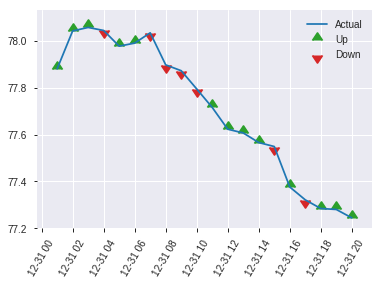


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19371469365876165
RMSE: 0.4401303144055879
LogLoss: 0.5713614355344383
Mean Per-Class Error: 0.28537444095537157
AUC: 0.7768473583489285
pr_auc: 0.7223182362910333
Gini: 0.553694716697857
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930119127035141: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  158  0.4661   (158.0/339.0)
1      42   237  0.1505   (42.0/279.0)
Total  223  395  0.3236   (200.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393012     0.703264  240
max f2                       0.247655     0.820481  319
max f0point5                 0.566999     0.694037  131
max accuracy                 0.505695     0.716828  176
max precision                0.947338     1         0
max recall                   0.107217     1         384
max specificity              0.947338     1         0
max absolute_mcc             0.505695     0.428451  176
max min_per_class_accuracy   0.48862      0.707965  184
max mean_per_class_accuracy  0.479995     0.714626  193

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 46.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.919889           1.89862   1.89862            0.857143         0.936237  0.857143                    0.936237            0.0215054       0.0215054                  89.8618   89.8618
    2        0.0210356                   0.890391           1.84588   1.87428            0.833333         0.909558  0.846154                    0.923924            0.0179211       0.0394265                  84.5878   87.4276
    3        0.0307443                   0.871122           1.84588   1.86531            0.833333         0.880053  0.842105                    0.91007             0.0179211       0.0573477                  84.5878   86.5308
    4        0.0404531                   0.854822           1.4767    1.77204            0.666667         0.863777  0.8                         0.898959            0.0143369       0.0716846                  47.6703   77.2043
    5        0.0501618                   0.832715           1.84588   1.78633            0.833333         0.846055  0.806452                    0.88872             0.0179211       0.0896057                  84.5878   78.6334
    6        0.100324                    0.720908           1.92924   1.85779            0.870968         0.784882  0.83871                     0.836801            0.0967742       0.18638                    92.924    85.7787
    7        0.150485                    0.662294           1.85779   1.85779            0.83871          0.692593  0.83871                     0.788731            0.09319         0.27957                    85.7787   85.7787
    8        0.200647                    0.625922           1.71488   1.82206            0.774194         0.644814  0.822581                    0.752752            0.0860215       0.365591                   71.488    82.206
    9        0.300971                    0.566882           1.42907   1.69106            0.645161         0.59392   0.763441                    0.699808            0.143369        0.508961                   42.9067   69.1063
    10       0.399676                    0.525907           1.05306   1.5335             0.47541          0.546968  0.692308                    0.662062            0.103943        0.612903                   5.30583   53.3499
    11       0.5                         0.481037           1.21471   1.46953            0.548387         0.505193  0.66343                     0.630587            0.121864        0.734767                   21.4707   46.9534
    12       0.600324                    0.418471           0.785987  1.3553             0.354839         0.453402  0.61186                     0.600976            0.078853        0.81362                    -21.4013  35.5302
    13       0.699029                    0.34755            0.798872  1.27673            0.360656         0.385321  0.576389                    0.570525            0.078853        0.892473                   -20.1128  27.6732
    14       0.799353                    0.261728           0.500173  1.17927            0.225806         0.298909  0.532389                    0.536436            0.0501792       0.942652                   -49.9827  17.927
    15       0.899676                    0.176404           0.32154   1.08362            0.145161         0.215874  0.489209                    0.50069             0.0322581       0.97491                    -67.846   8.36234
    16       1                           0.0355273          0.250087  1                  0.112903         0.126175  0.451456                    0.463117           

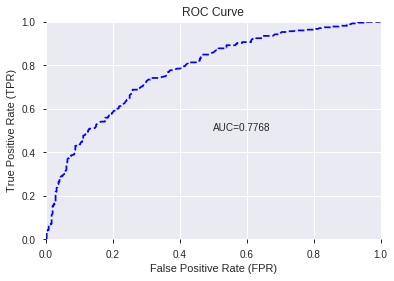

This function is available for GLM models only


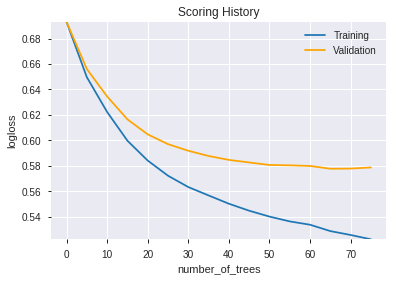

--2019-08-22 12:46:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124600_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124600_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'STOCHRSI_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'COSH',
 'WILLR_8',
 'TRANGE',
 'SUB',
 'EXP',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLENGULFING',
 'SINH',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_end']

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124743_model_1  0.765138  0.592442              0.317791  0.450515  0.202964

variable  relative_importance  scaled_importance    percentage
0                          BOP         2.523295e-01           1.000000  4.355860e-02
1           CDLCLOSINGMARUBOZU         1.559915e-01           0.618206  2.692817e-02
2                  CDLLONGLINE         1.002608e-01           0.397341  1.730761e-02
3                    CDLHAMMER         9.120108e-02           0.361437  1.574367e-02
4                 STOCHF_fastk         8.991479e-02           0.356339  1.552162e-02
...                        ...                  ...                ...           ...
1035   BBANDS_upperband_12_1_2         4.302504e-06           0.000017  7.427236e-07
1036  BBANDS_middleband_30_1_3         3.153838e-06           0.000012  5.444341e-07
1037  BBANDS_middleband_30_1_2         2.883671e-06           0.000011  4.977963e-07
1038  BBANDS_middleband_20_7_4         2.538200e-06           0.000010  4.381591e-07
1039   BBANDS_upperband_20_3_2         6.998159e-07           0.000003  1.208063e-07

[1040 rows x 4 columns]

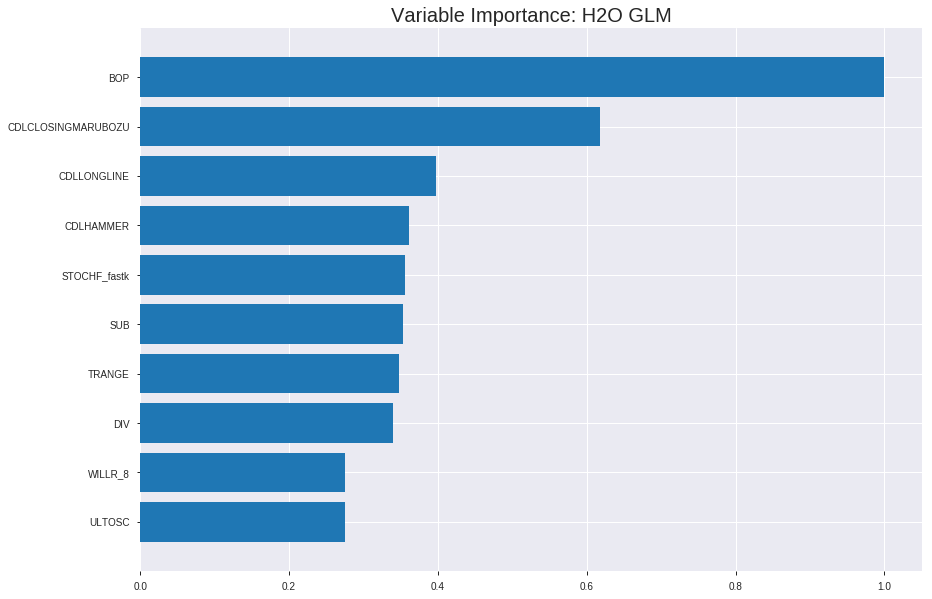

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124743_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19647083521857467
RMSE: 0.44325030763505924
LogLoss: 0.5759729803042888
Null degrees of freedom: 4318
Residual degrees of freedom: 3278
Null deviance: 5975.678574739547
Residual deviance: 4975.254603868447
AIC: 7057.254603868447
AUC: 0.7711506275071042
pr_auc: 0.7472615941190835
Gini: 0.5423012550142083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.369580404448792: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1048  1224  0.5387   (1224.0/2272.0)
1      218   1829  0.1065   (218.0/2047.0)
Total  1266  3053  0.3339   (1442.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36958      0.717255  264
max f2                       0.19952      0.832577  342
max f0point5                 0.546986     0.6838    162
max accuracy                 0.489332     0.69831   194
max precision                0.944034     1         0
max recall                   0.0792732    1         389
max specificity              0.944034     1         0
max absolute_mcc             0.44172      0.40228   225
max min_per_class_accuracy   0.492589     0.695423  192
max mean_per_class_accuracy  0.489332     0.698638  194

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.850651           1.96606   1.96606            0.931818         0.874176  0.931818                    0.874176            0.0200293       0.0200293                  96.6059   96.6059
    2        0.0201436                   0.821069           2.10992   2.03716            1                0.835874  0.965517                    0.855245            0.0210064       0.0410357                  110.992   103.716
    3        0.0300996                   0.799874           2.01178   2.02877            0.953488         0.811259  0.961538                    0.840696            0.0200293       0.061065                   101.178   102.877
    4        0.0400556                   0.783886           1.96271   2.01235            0.930233         0.792429  0.953757                    0.828699            0.0195408       0.0806058                  96.2713   101.235
    5        0.0500116                   0.768288           1.71737   1.95363            0.813953         0.775139  0.925926                    0.818036            0.0170982       0.097704                   71.7374   95.3627
    6        0.100023                    0.711995           1.76803   1.86083            0.837963         0.739756  0.881944                    0.778896            0.0884221       0.186126                   76.8032   86.083
    7        0.150035                    0.671198           1.60197   1.77454            0.759259         0.690662  0.841049                    0.749485            0.0801172       0.266243                   60.1974   77.4544
    8        0.200046                    0.637343           1.43592   1.68989            0.680556         0.654626  0.800926                    0.72577             0.0718124       0.338056                   43.5916   68.9887
    9        0.300069                    0.582144           1.29428   1.55802            0.613426         0.609534  0.738426                    0.687025            0.129458        0.467513                   29.4278   55.8017
    10       0.400093                    0.534559           1.27963   1.48842            0.606481         0.558253  0.70544                     0.654832            0.127992        0.595506                   27.9626   48.8419
    11       0.500116                    0.487048           1.12334   1.4154             0.532407         0.510337  0.670833                    0.625933            0.11236         0.707865                   12.3335   41.5403
    12       0.599907                    0.432491           0.959498  1.33957            0.454756         0.459281  0.63489                     0.598211            0.0957499       0.803615                   -4.05018  33.9565
    13       0.699931                    0.373471           0.830291  1.26679            0.393519         0.404617  0.600397                    0.570546            0.0830484       0.886663                   -16.9709  26.6788
    14       0.799954                    0.304704           0.556784  1.17801            0.263889         0.338745  0.558321                    0.541562            0.0556913       0.942355                   -44.3216  17.8012
    15       0.899977                    0.209817           0.390725  1.09051            0.185185         0.26021   0.516851                    0.510293            0.0390816       0.981436                   -60.9275  9.05128
    16       1                           0.0253314          0.185595  1                  0.087963         0.146972  0.473952                    0.473952          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21090148786803797
RMSE: 0.4592401200548989
LogLoss: 0.6074549317726117
Null degrees of freedom: 1233
Residual degrees of freedom: 193
Null deviance: 1718.4207619926892
Residual deviance: 1499.1987716148055
AIC: 3581.1987716148055
AUC: 0.7624879026319665
pr_auc: 0.7423969068320561
Gini: 0.5249758052639331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30268367586357325: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      264  332  0.557    (332.0/596.0)
1      68   570  0.1066   (68.0/638.0)
Total  332  902  0.3241   (400.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302684     0.74026   276
max f2                       0.185045     0.857729  342
max f0point5                 0.458933     0.714286  177
max accuracy                 0.420389     0.696921  202
max precision                0.908633     1         0
max recall                   0.109502     1         376
max specificity              0.908633     1         0
max absolute_mcc             0.420389     0.393806  202
max min_per_class_accuracy   0.418823     0.694631  203
max mean_per_class_accuracy  0.420389     0.697011  202

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 42.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.831101           1.48782   1.48782            0.769231         0.850943  0.769231                    0.850943            0.015674        0.015674                   48.7823   48.7823
    2        0.0202593                   0.793647           1.61181   1.54734            0.833333         0.815679  0.8                         0.834016            0.015674        0.031348                   61.1808   54.7335
    3        0.0299838                   0.777439           1.61181   1.56825            0.833333         0.786192  0.810811                    0.818506            0.015674        0.0470219                  61.1808   56.8245
    4        0.0405186                   0.754912           1.6366    1.58602            0.846154         0.769317  0.82                        0.805716            0.0172414       0.0642633                  63.6605   58.6019
    5        0.0502431                   0.731356           1.28945   1.52862            0.666667         0.744119  0.790323                    0.793794            0.0125392       0.0768025                  28.9446   52.8618
    6        0.100486                    0.656002           1.6846    1.60661            0.870968         0.689293  0.830645                    0.741544            0.0846395       0.161442                   68.4599   60.6608
    7        0.149919                    0.611025           1.61709   1.61007            0.836066         0.632177  0.832432                    0.705482            0.0799373       0.241379                   61.7092   61.0065
    8        0.200162                    0.573577           1.34144   1.54264            0.693548         0.593319  0.797571                    0.677328            0.0673981       0.308777                   34.144    54.2637
    9        0.299838                    0.516151           1.5096    1.53165            0.780488         0.54295   0.791892                    0.632656            0.15047         0.459248                   50.9596   53.1653
    10       0.400324                    0.46694            1.21665   1.45258            0.629032         0.491685  0.751012                    0.597271            0.122257        0.581505                   21.6655   45.2585
    11       0.5                         0.42147            1.08502   1.37931            0.560976         0.445083  0.713128                    0.566932            0.10815         0.689655                   8.50218   37.931
    12       0.599676                    0.37277            0.880597  1.29642            0.455285         0.39838   0.67027                     0.538916            0.0877743       0.777429                   -11.9403  29.6416
    13       0.700162                    0.317552           0.873496  1.23572            0.451613         0.344542  0.638889                    0.51102             0.0877743       0.865204                   -12.6504  23.5719
    14       0.799838                    0.261524           0.676173  1.16599            0.349593         0.291434  0.602837                    0.483655            0.0673981       0.932602                   -32.3827  16.5989
    15       0.899514                    0.177514           0.518923  1.09429            0.268293         0.223978  0.565766                    0.45488             0.0517241       0.984326                   -48.1077  9.42868
    16       1                           0.0359917          0.155981  1                  0.0806452        0.124559  0.517018                    0.421687          


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:47:54  0.000 sec         2            .2E2      1034          1.3592399329311389  1.3719235790854099
     2019-08-22 12:48:00  5.777 sec         4            .14E2     1038          1.35252211242507    1.3649684034598584
     2019-08-22 12:48:06  11.780 sec        6            .11E2     1041          1.344219239508856   1.356747391100821
     2019-08-22 12:48:11  17.383 sec        8            .76E1     1041          1.334106317016743   1.3468533321448453
     2019-08-22 12:48:17  23.098 sec        10           .56E1     1041          1.3220300601883312  1.3351456172762548
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-22 12:49:26  1 min 31.781 sec  34           .12E0     1041          1.1428645142036575  1.216078254656768
     2019-08-22 12:49:31  1 min 37.605 sec  36           .9E-1     1041          1.1351053011710506  1.2190604911131306
     2019-08-22 12:49:37  1 min 43.161 sec  38           .65E-1    1041          1.1284853195774116  1.2234250749883826
     2019-08-22 12:49:43  1 min 48.765 sec  40           .47E-1    1041          1.1228419853862506  1.2287990394756347
     2019-08-22 12:49:48  1 min 54.603 sec  42           .35E-1    1041          1.1180303435702799  1.2348240622068192


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7103559870550162)

('F1', 0.6952662721893491)

('auc', 0.7651378183778983)

('logloss', 0.5924421080516755)

('mean_per_class_error', 0.29749103942652333)

('rmse', 0.45051474326842056)

('mse', 0.20296353390221086)

glm prediction progress: |████████████████████████████████████████████████| 100%


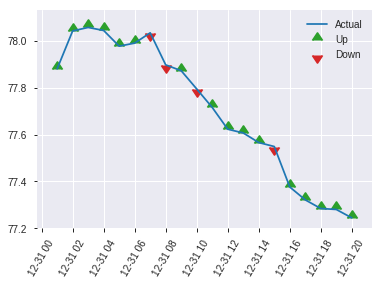


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20296353390221086
RMSE: 0.45051474326842056
LogLoss: 0.5924421080516755
Null degrees of freedom: 617
Residual degrees of freedom: -423
Null deviance: 852.1522922482045
Residual deviance: 732.258445551871
AIC: 2814.258445551871
AUC: 0.7651378183778983
pr_auc: 0.7339944665009032
Gini: 0.5302756367557966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29931259587441283: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      177  162  0.4779   (162.0/339.0)
1      44   235  0.1577   (44.0/279.0)
Total  221  397  0.3333   (206.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299313     0.695266  261
max f2                       0.211947     0.81139   330
max f0point5                 0.464681     0.696143  142
max accuracy                 0.464681     0.710356  142
max precision                0.896564     1         0
max recall                   0.0757819    1         388
max specificity              0.896564     1         0
max absolute_mcc             0.464681     0.415839  142
max min_per_class_accuracy   0.375568     0.688172  203
max mean_per_class_accuracy  0.36308      0.702509  214

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 38.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.790232           2.21505   2.21505            1                0.822844  1                           0.822844            0.0250896       0.0250896                  121.505   121.505
    2        0.0210356                   0.744535           2.21505   2.21505            1                0.77185   1                           0.799308            0.0215054       0.046595                   121.505   121.505
    3        0.0307443                   0.717095           2.21505   2.21505            1                0.730875  1                           0.777698            0.0215054       0.0681004                  121.505   121.505
    4        0.0404531                   0.698708           1.4767    2.03785            0.666667         0.708036  0.92                        0.760979            0.0143369       0.0824373                  47.6703   103.785
    5        0.0501618                   0.682034           1.4767    1.92924            0.666667         0.689394  0.870968                    0.747124            0.0143369       0.0967742                  47.6703   92.924
    6        0.100324                    0.623504           2.00069   1.96497            0.903226         0.648001  0.887097                    0.697563            0.100358        0.197133                   100.069   96.4967
    7        0.150485                    0.582136           1.64343   1.85779            0.741935         0.602297  0.83871                     0.665807            0.0824373       0.27957                    64.3427   85.7787
    8        0.200647                    0.554105           1.57197   1.78633            0.709677         0.569898  0.806452                    0.64183             0.078853        0.358423                   57.1974   78.6334
    9        0.300971                    0.474125           1.42907   1.66724            0.645161         0.507698  0.752688                    0.597119            0.143369        0.501792                   42.9067   66.7245
    10       0.399676                    0.423059           1.12568   1.5335             0.508197         0.449238  0.692308                    0.560598            0.111111        0.612903                   12.5683   53.3499
    11       0.5                         0.368693           1.03607   1.43369            0.467742         0.392992  0.647249                    0.526969            0.103943        0.716846                   3.60735   43.3692
    12       0.600324                    0.318857           0.785987  1.32545            0.354839         0.345557  0.598383                    0.496652            0.078853        0.795699                   -21.4013  32.545
    13       0.699029                    0.273809           0.726247  1.24084            0.327869         0.295699  0.560185                    0.468277            0.0716846       0.867384                   -27.3753  24.084
    14       0.799353                    0.226368           0.64308   1.16582            0.290323         0.249578  0.526316                    0.440829            0.0645161       0.9319                     -35.692   16.5818
    15       0.899676                    0.158802           0.357267  1.07566            0.16129          0.195101  0.485612                    0.413427            0.0358423       0.967742                   -64.2733  7.56556
    16       1                           0.0240411          0.32154   1                  0.145161         0.10389   0.451456                    0.382373            

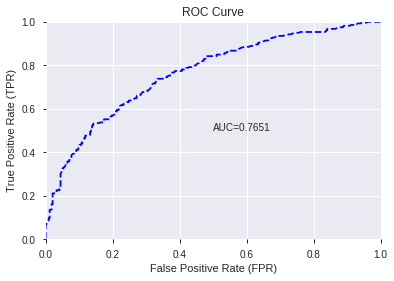

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


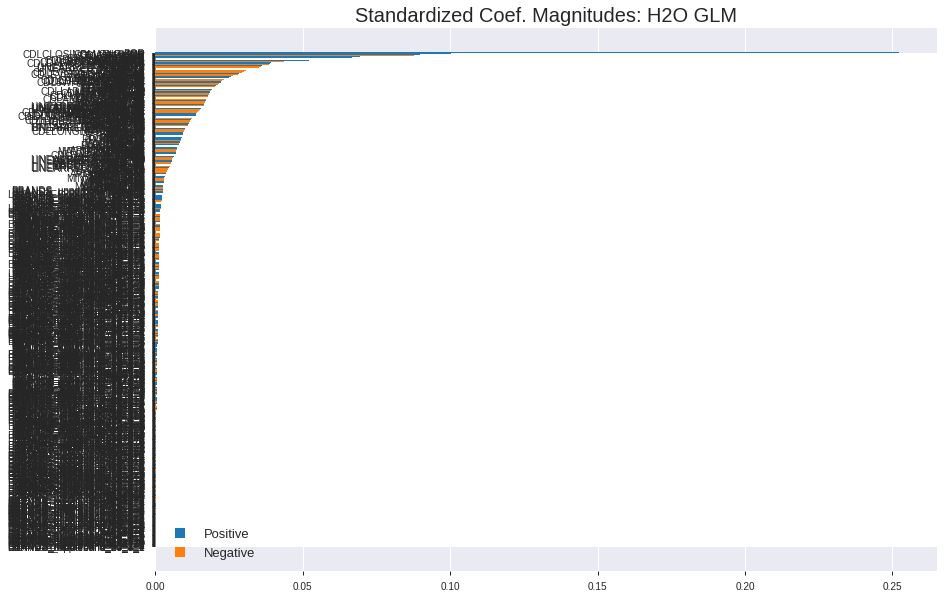

'log_likelihood'
--2019-08-22 12:50:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.88.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.88.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124743_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124743_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

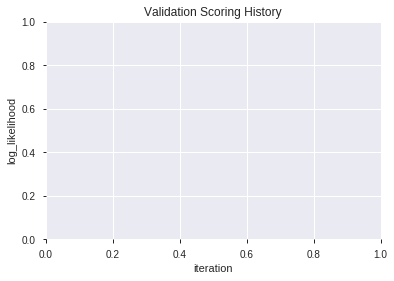

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_125123_model_6  0.780833  0.572752              0.311463  0.440256  0.193825
1               XGBoost_3_AutoML_20190822_125123  0.776065  0.574039              0.275462  0.441418  0.194850
2  XGBoost_grid_1_AutoML_20190822_125123_model_1  0.774997  0.573306              0.303264  0.441404  0.194838
3  XGBoost_grid_1_AutoML_20190822_125123_model_2  0.773887  0.576970              0.286104  0.442813  0.196083
4  XGBoost_grid_1_AutoML_20190822_125123_model_7  0.771624  0.568432              0.307467  0.439889  0.193503
5               XGBoost_2_AutoML_20190822_125123  0.768389  0.575648              0.301044  0.442730  0.196010
6               XGBoost_1_AutoML_20190822_125123  0.767770  0.575820              0.295477  0.442802  0.196074
7  XGBoost_grid_1_AutoML_20190822_125123_model_4  0.765899  0.579184              0.313366  0.444266  0.197372
8  XGBoost_grid_1_AutoML_20190822_125123_model_3  0.758207  0.585574              0.317379  0.447365  0.200135
9  XGBoost_grid_1_AutoML_20190822_125123_model_5  0.736522  0.600784              0.355077  0.454054  0.206165

variable  relative_importance  scaled_importance  percentage
0                        BOP          4496.040527           1.000000    0.248929
1         CDLCLOSINGMARUBOZU           557.624451           0.124026    0.030874
2                     TRANGE           501.890320           0.111629    0.027788
3               STOCHF_fastk           478.201080           0.106360    0.026476
4                        DIV           467.940460           0.104078    0.025908
..                       ...                  ...                ...         ...
324  BBANDS_lowerband_24_1_5             3.230815           0.000719    0.000179
325  BBANDS_upperband_14_2_5             3.118382           0.000694    0.000173
326  BBANDS_upperband_20_6_2             2.573142           0.000572    0.000142
327       LINEARREG_SLOPE_30             1.420109           0.000316    0.000079
328            days_in_month             1.152276           0.000256    0.000064

[329 rows x 4 columns]

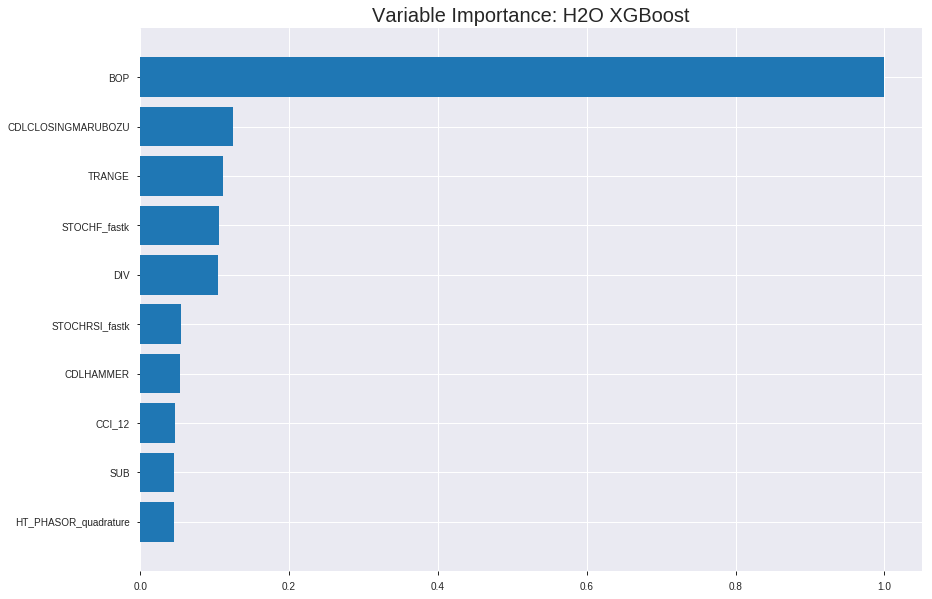

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_125123_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15600769249660215
RMSE: 0.39497809116025934
LogLoss: 0.48113553287258826
Mean Per-Class Error: 0.20923655022465026
AUC: 0.8810631712846694
pr_auc: 0.8779934429127898
Gini: 0.7621263425693388
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4843472594564611: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1647  625   0.2751   (625.0/2272.0)
1      327   1720  0.1597   (327.0/2047.0)
Total  1974  2345  0.2204   (952.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484347     0.783242  207
max f2                       0.303976     0.868689  290
max f0point5                 0.588933     0.80664   146
max accuracy                 0.524651     0.79185   183
max precision                0.955404     1         0
max recall                   0.161012     1         353
max specificity              0.955404     1         0
max absolute_mcc             0.524651     0.582249  183
max min_per_class_accuracy   0.513937     0.786028  189
max mean_per_class_accuracy  0.524651     0.790763  183

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.924629           2.10992   2.10992            1                0.936086  1                           0.936086            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.906512           2.10992   2.10992            1                0.915819  1                           0.926069            0.0210064       0.0425012                  110.992   110.992
    3        0.0300996                   0.882259           2.10992   2.10992            1                0.894886  1                           0.915754            0.0210064       0.0635076                  110.992   110.992
    4        0.0400556                   0.863426           2.10992   2.10992            1                0.87211   1                           0.904906            0.0210064       0.0845139                  110.992   110.992
    5        0.0500116                   0.841014           2.10992   2.10992            1                0.85242   1                           0.894458            0.0210064       0.10552                    110.992   110.992
    6        0.100023                    0.755635           2.06108   2.0855             0.976852         0.791374  0.988426                    0.842916            0.103078        0.208598                   106.108   108.55
    7        0.150035                    0.697336           2.022     2.06433            0.958333         0.723281  0.978395                    0.803037            0.101124        0.309722                   102.2     106.433
    8        0.200046                    0.658088           1.89502   2.022              0.898148         0.676051  0.958333                    0.771291            0.0947728       0.404494                   89.5018   102.2
    9        0.300069                    0.598699           1.60686   1.88362            0.761574         0.627012  0.892747                    0.723198            0.160723        0.565217                   60.6858   88.3622
    10       0.400093                    0.554102           1.31381   1.74117            0.622685         0.577065  0.825231                    0.686665            0.131412        0.696629                   31.3814   74.117
    11       0.500116                    0.505062           1.02077   1.59709            0.483796         0.530419  0.756944                    0.655416            0.102101        0.79873                    2.077     59.709
    12       0.599907                    0.446697           0.86159   1.47474            0.408353         0.477653  0.698958                    0.625846            0.0859795       0.884709                   -13.841   47.4743
    13       0.699931                    0.355695           0.586088  1.34775            0.277778         0.402842  0.638769                    0.593977            0.0586224       0.943332                   -41.3912  34.775
    14       0.799954                    0.2438             0.424914  1.23236            0.201389         0.297229  0.584081                    0.556873            0.0425012       0.985833                   -57.5086  23.2362
    15       0.899977                    0.152992           0.141638  1.11114            0.0671296        0.19683   0.526627                    0.516858            0.0141671       1                          -85.8362  11.114
    16       1                           0.0492285          0         1                  0                0.112529  0.473952                    0.476416            0   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20050043499129785
RMSE: 0.4477727492727733
LogLoss: 0.5845990813323945
Mean Per-Class Error: 0.29718499505585827
AUC: 0.7683879994109107
pr_auc: 0.7569888179628126
Gini: 0.5367759988218215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27670809626579285: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      248  348  0.5839   (348.0/596.0)
1      50   588  0.0784   (50.0/638.0)
Total  298  936  0.3225   (398.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.276708     0.747141  297
max f2                       0.184932     0.859654  346
max f0point5                 0.524643     0.712376  169
max accuracy                 0.422779     0.705835  229
max precision                0.931726     1         0
max recall                   0.100702     1         386
max specificity              0.931726     1         0
max absolute_mcc             0.421667     0.413335  230
max min_per_class_accuracy   0.473905     0.694357  200
max mean_per_class_accuracy  0.422779     0.702815  229

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.899355           1.78539   1.78539            0.923077         0.917669  0.923077                    0.917669            0.0188088       0.0188088                  78.5387   78.5387
    2        0.0202593                   0.870699           1.61181   1.70207            0.833333         0.88469   0.88                        0.901839            0.015674        0.0344828                  61.1808   70.2069
    3        0.0299838                   0.855976           1.61181   1.6728             0.833333         0.86564   0.864865                    0.890099            0.015674        0.0501567                  61.1808   67.2795
    4        0.0405186                   0.830866           1.93417   1.74075            1                0.84333   0.9                         0.877939            0.0203762       0.0705329                  93.4169   74.0752
    5        0.0502431                   0.796741           1.61181   1.7158             0.833333         0.811691  0.887097                    0.865117            0.015674        0.0862069                  61.1808   71.5795
    6        0.100486                    0.702394           1.52862   1.62221            0.790323         0.749191  0.83871                     0.807154            0.0768025       0.163009                   52.8618   62.2206
    7        0.149919                    0.651053           1.58538   1.61007            0.819672         0.675671  0.832432                    0.7638              0.0783699       0.241379                   58.5385   61.0065
    8        0.200162                    0.622905           1.34144   1.54264            0.693548         0.636848  0.797571                    0.731934            0.0673981       0.308777                   34.144    54.2637
    9        0.299838                    0.573624           1.43097   1.50552            0.739837         0.598207  0.778378                    0.687479            0.142633        0.451411                   43.0971   50.5516
    10       0.400324                    0.524543           1.31024   1.4565             0.677419         0.54788   0.753036                    0.652438            0.131661        0.583072                   31.0244   45.65
    11       0.5                         0.477681           1.02212   1.36991            0.528455         0.502152  0.708266                    0.622478            0.101881        0.684953                   2.2122    36.9906
    12       0.599676                    0.416364           1.10075   1.32517            0.569106         0.448883  0.685135                    0.593624            0.109718        0.794671                   10.0747   32.5167
    13       0.700162                    0.331435           0.764309  1.24467            0.395161         0.377701  0.643519                    0.562635            0.0768025       0.871473                   -23.5691  24.4674
    14       0.799838                    0.24203            0.723348  1.17971            0.373984         0.285489  0.609929                    0.528097            0.0721003       0.943574                   -27.6652  17.9706
    15       0.899514                    0.169823           0.393124  1.09254            0.203252         0.202285  0.564865                    0.491993            0.039185        0.982759                   -60.6876  9.25443
    16       1                           0.0528711          0.17158   1                  0.0887097        0.129852  0.517018                    0.455603           


Scoring History: 


timestamp            duration          number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:53:42  1 min 22.620 sec  0                  0.5              0.693147            0.5             0                  1                0.526048                         0.5                0.693147              0.5               0                    1                  0.482982
    2019-08-22 12:53:44  1 min 24.586 sec  5                  0.475616         0.645205            0.801987        0.776095           2.07155          0.287335                         0.480698           0.65502               0.754594          0.706062             1.64111            0.333063
    2019-08-22 12:53:45  1 min 25.171 sec  10                 0.458659         0.612054            0.812224        0.794617           2.10992          0.306321                         0.469489           0.632862              0.759905          0.749365             1.78539            0.322528
    2019-08-22 12:53:45  1 min 25.731 sec  15                 0.44606          0.586996            0.821926        0.805121           2.10992          0.289419                         0.461713           0.617191              0.765339          0.756533             1.78539            0.316856
    2019-08-22 12:53:46  1 min 26.356 sec  20                 0.436721         0.567626            0.825669        0.8124             2.10992          0.282241                         0.456172           0.605437              0.766095          0.758105             1.78539            0.316856
    2019-08-22 12:53:47  1 min 26.923 sec  25                 0.429661         0.552732            0.831391        0.819805           2.10992          0.279                            0.452935           0.598264              0.766685          0.75742              1.78539            0.327391
    2019-08-22 12:53:47  1 min 27.500 sec  30                 0.423904         0.540365            0.838074        0.826309           2.10992          0.260245                         0.451054           0.593739              0.765763          0.758556             1.93417            0.323339
    2019-08-22 12:53:48  1 min 28.072 sec  35                 0.418586         0.529332            0.845448        0.835173           2.10992          0.248437                         0.44886            0.588866              0.768985          0.759881             1.78539            0.312804
    2019-08-22 12:53:48  1 min 28.672 sec  40                 0.413158         0.51794             0.85299         0.841727           2.10992          0.248669                         0.448783           0.588299              0.766195          0.755954             1.78539            0.313614
    2019-08-22 12:53:49  1 min 29.241 sec  45                 0.409417         0.509777            0.856709        0.849357           2.10992          0.236629                         0.448426           0.587192              0.765541          0.754338             1.78539            0.290924
    2019-08-22 12:53:50  1 min 29.807 sec  50                 0.404872         0.50084             0.865368        0.859933           2.10992          0.244038                         0.448496           0.587028              0.767245          0.757085             1.78539            0.299028
    2019-08-22 12:53:50  1 min 30.379 sec  55                 0.40169          0.494288            0.869884        0.865391           2.10992          0.23686  

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      4496.04052734375       1.0                     0.24892905726957548
CDLCLOSINGMARUBOZU       557.6244506835938      0.1240256726540312      0.030873593770992955
TRANGE                   501.89031982421875     0.11162940297620813     0.02778780204643303
STOCHF_fastk             478.2010803222656      0.10636049150668704     0.026476216881488296
DIV                      467.9404602050781      0.10407834568198081     0.025908124472792476
---                      ---                    ---                     ---
BBANDS_lowerband_24_1_5  3.2308146953582764     0.0007185910971463226   0.00017887820437494404
BBANDS_upperband_14_2_5  3.1183815002441406     0.0006935839393081434   0.0001726531961492946
BBANDS_upperband_20_6_2  2.5731420516967773     0.0005723129131171296   0.00014246531392545154
LINEARREG_SLOPE_30       1.4201093912124634     0.00031585778254793905  7.862618004091705e-05
days_in_month            1.1522763967514038     0.00025628692395977267  6.379726237182559e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7249190938511327)

('F1', 0.7036496350364965)

('auc', 0.7808333597657034)

('logloss', 0.5727520551060882)

('mean_per_class_error', 0.28294794937672474)

('rmse', 0.4402555058958407)

('mse', 0.19382491047160263)

xgboost prediction progress: |████████████████████████████████████████████| 100%


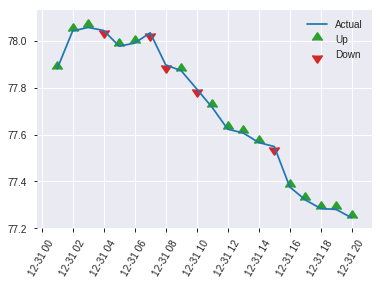


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19382491047160263
RMSE: 0.4402555058958407
LogLoss: 0.5727520551060882
Mean Per-Class Error: 0.28294794937672474
AUC: 0.7808333597657034
pr_auc: 0.7344041022758832
Gini: 0.5616667195314069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3530532866716385: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      174  165  0.4867   (165.0/339.0)
1      38   241  0.1362   (38.0/279.0)
Total  212  406  0.3285   (203.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353053     0.70365   258
max f2                       0.201825     0.816697  338
max f0point5                 0.569673     0.716648  115
max accuracy                 0.533313     0.724919  143
max precision                0.927309     1         0
max recall                   0.112549     1         390
max specificity              0.927309     1         0
max absolute_mcc             0.533313     0.443955  143
max min_per_class_accuracy   0.454385     0.705015  195
max mean_per_class_accuracy  0.44156      0.717052  205

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 44.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.878128           1.89862   1.89862            0.857143         0.908883  0.857143                    0.908883            0.0215054       0.0215054                  89.8618   89.8618
    2        0.0210356                   0.857419           2.21505   2.04467            1                0.868821  0.923077                    0.890393            0.0215054       0.0430108                  121.505   104.467
    3        0.0307443                   0.839638           1.10753   1.74873            0.5              0.852811  0.789474                    0.878525            0.0107527       0.0537634                  10.7527   74.8727
    4        0.0404531                   0.801446           1.84588   1.77204            0.833333         0.812242  0.8                         0.862617            0.0179211       0.0716846                  84.5878   77.2043
    5        0.0501618                   0.77049            2.21505   1.85779            1                0.792127  0.83871                     0.848974            0.0215054       0.09319                    121.505   85.7787
    6        0.100324                    0.689247           1.92924   1.89351            0.870968         0.725825  0.854839                    0.787399            0.0967742       0.189964                   92.924    89.3514
    7        0.150485                    0.636807           1.92924   1.90542            0.870968         0.657142  0.860215                    0.74398             0.0967742       0.286738                   92.924    90.5423
    8        0.200647                    0.601725           1.71488   1.85779            0.774194         0.62209   0.83871                     0.713508            0.0860215       0.37276                    71.488    85.7787
    9        0.300971                    0.552116           1.42907   1.71488            0.645161         0.574949  0.774194                    0.667321            0.143369        0.516129                   42.9067   71.488
    10       0.399676                    0.50635            1.12568   1.56937            0.508197         0.52728   0.708502                    0.632736            0.111111        0.62724                    12.5683   56.937
    11       0.5                         0.447133           1.0718    1.46953            0.483871         0.476395  0.66343                     0.601367            0.107527        0.734767                   7.18002   46.9534
    12       0.600324                    0.385479           0.75026   1.34933            0.33871          0.418931  0.609164                    0.570879            0.0752688       0.810036                   -24.974   34.9332
    13       0.699029                    0.320119           0.61731   1.24597            0.278689         0.353401  0.5625                      0.54017             0.0609319       0.870968                   -38.269   24.5968
    14       0.799353                    0.241481           0.571627  1.16133            0.258065         0.285295  0.524291                    0.508182            0.0573477       0.928315                   -42.8373  16.1334
    15       0.899676                    0.171973           0.464447  1.08362            0.209677         0.210931  0.489209                    0.475035            0.046595        0.97491                    -53.5553  8.36234
    16       1                           0.0706532          0.250087  1                  0.112903         0.134772  0.451456                    0.440899           

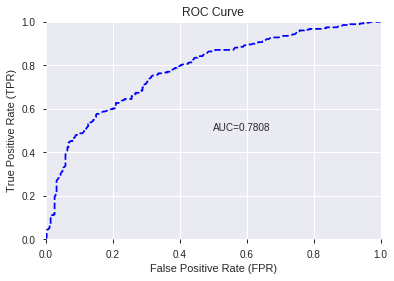

This function is available for GLM models only


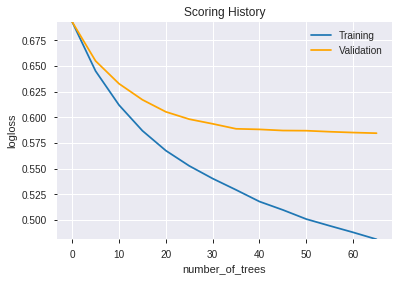

--2019-08-22 12:54:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_125123_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_125123_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125512_model_5  0.772999  0.597650              0.310416  0.450066  0.202559
1  DeepLearning_grid_1_AutoML_20190822_125512_model_8  0.766581  0.586381              0.338313  0.445877  0.198807
2  DeepLearning_grid_1_AutoML_20190822_125512_model_6  0.764271  0.587564              0.323263  0.446386  0.199260
3  DeepLearning_grid_1_AutoML_20190822_125512_model_9  0.762014  0.594842              0.311796  0.449663  0.202197
4               DeepLearning_1_AutoML_20190822_125512  0.756722  0.613457              0.339376  0.461866  0.213320
5  DeepLearning_grid_1_AutoML_20190822_125512_model_3  0.753233  0.636622              0.328639  0.457795  0.209576
6  DeepLearning_grid_1_AutoML_20190822_125512_model_4  0.751747  0.618337              0.342849  0.453653  0.205801
7  DeepLearning_grid_1_AutoML_20190822_125512_model_2  0.749543  0.617878              0.363704  0.455441  0.207426
8  DeepLearning_grid_1_AutoML_20190822_125512_model_7  0.739546  0.611312              0.322010  0.456109  0.208036
9  DeepLearning_grid_1_AutoML_20190822_125512_model_1  0.698211  0.791673              0.356567  0.494224  0.244257

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.057662
1    CDLCLOSINGMARUBOZU             0.747736           0.747736    0.043116
2                TRANGE             0.594771           0.594771    0.034296
3                   DIV             0.530975           0.530975    0.030617
4             PLUS_DI_8             0.493576           0.493576    0.028461
5                   SUB             0.486327           0.486327    0.028043
6          HT_TRENDMODE             0.471617           0.471617    0.027194
7           CDLLONGLINE             0.451465           0.451465    0.026032
8                  SINH             0.437060           0.437060    0.025202
9        STOCHRSI_fastk             0.432184           0.432184    0.024921
10                  EXP             0.430555           0.430555    0.024827
11         STOCHF_fastk             0.423605           0.423605    0.024426
12                 COSH             0.416159           0.416159    0.023997
13            CDLHAMMER             0.414430           0.414430    0.023897
14         CDLENGULFING             0.412086           0.412086    0.023762
15        CDLHANGINGMAN             0.405845           0.405845    0.023402
16              WILLR_8             0.352549           0.352549    0.020329
17            CDLTAKURI             0.344783           0.344783    0.019881
18          CDLMARUBOZU             0.334916           0.334916    0.019312
19      CDLSHOOTINGSTAR             0.314397           0.314397    0.018129
20       is_month_start             0.306700           0.306700    0.017685
21       CDLMORNINGSTAR             0.293648           0.293648    0.016932
22         is_month_end             0.292586           0.292586    0.016871
23    CDL3WHITESOLDIERS             0.284090           0.284090    0.016381
24   CDLEVENINGDOJISTAR             0.282488           0.282488    0.016289
25     CDLDRAGONFLYDOJI             0.281364           0.281364    0.016224
26         CDLTHRUSTING             0.279171           0.279171    0.016098
27    CDLDARKCLOUDCOVER             0.275530           0.275530    0.015888
28    CDLGRAVESTONEDOJI             0.274667           0.274667    0.015838
29       CDL3LINESTRIKE             0.272867           0.272867    0.015734
30     is_quarter_start             0.272699           0.272699    0.015724
31      CDLUNIQUE3RIVER             0.270393           0.270393    0.015591
32      CDLADVANCEBLOCK             0.267367           0.267367    0.015417
33      CDLLADDERBOTTOM             0.267240           0.267240    0.015410
34  CDLGAPSIDESIDEWHITE             0.266993           0.266993    0.015395
35   CDLMORNINGDOJISTAR             0.264092           0.264092    0.015228
36      CDLHOMINGPIGEON             0.259409           0.259409    0.014958
37            CDLINNECK             0.256532           0.256532    0.014792
38            CDLONNECK             0.255921           0.255921    0.014757
39   CDLIDENTICAL3CROWS             0.254649           0.254649    0.014684
40          CDLPIERCING             0.253435           0.253435    0.014614
41          CDLDOJISTAR             0.250023           0.250023    0.014417
42     CDLSTICKSANDWICH             0.249460           0.249460    0.014384
43       CDLMATCHINGLOW             0.244893           0.244893    0.014121
44         CDLTASUKIGAP             0.240395           0.240395    0.013862
45    CDLINVERTEDHAMMER             0.234445           0.234445    0.013519
46       CDLEVENINGSTAR             0.232137           0.232137    0.013385
47           CDL3INSIDE             0.230919           0.230919    0.013315
48    CDLSTALLEDPATTERN             0.218618           0.218618    0.012606
49   CDLSEPARATINGLINES             0.214638           0.214638    0.012376

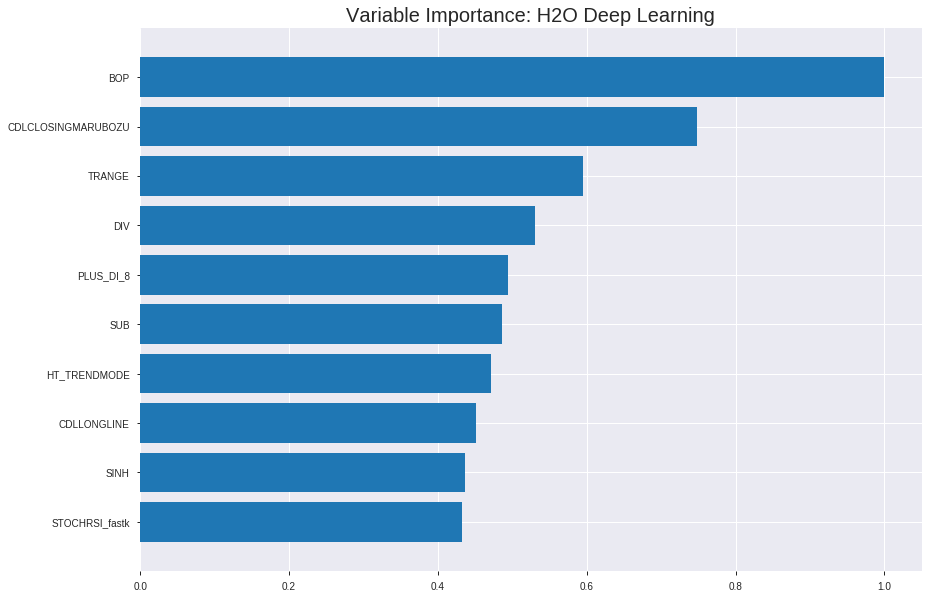

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125512_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1980665078871179
RMSE: 0.4450466356317256
LogLoss: 0.5767014939500278
Mean Per-Class Error: 0.3067311876879253
AUC: 0.7676460570948898
pr_auc: 0.7424672858552372
Gini: 0.5352921141897795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4620030427380035: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1138  1134  0.4991   (1134.0/2272.0)
1      270   1777  0.1319   (270.0/2047.0)
Total  1408  2911  0.3251   (1404.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462003     0.716821  236
max f2                       0.252555     0.833544  314
max f0point5                 0.597014     0.677275  164
max accuracy                 0.563085     0.693679  183
max precision                0.997799     1         0
max recall                   0.058239     1         381
max specificity              0.997799     1         0
max absolute_mcc             0.462003     0.393046  236
max min_per_class_accuracy   0.558901     0.691461  185
max mean_per_class_accuracy  0.563085     0.693269  183

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 53.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.990555           2.06196   2.06196            0.977273         0.994222   0.977273                    0.994222            0.0210064       0.0210064                  106.196   106.196
    2        0.0201436                   0.984103           1.91365   1.98866            0.906977         0.986919   0.942529                    0.990612            0.0190523       0.0400586                  91.3646   98.8657
    3        0.0300996                   0.973874           1.96271   1.98008            0.930233         0.97862    0.938462                    0.986645            0.0195408       0.0595994                  96.2713   98.0076
    4        0.0400556                   0.960327           2.01178   1.98796            0.953488         0.9675     0.942197                    0.981887            0.0200293       0.0796287                  101.178   98.7956
    5        0.0500116                   0.946882           1.91365   1.97316            0.906977         0.953729   0.935185                    0.976281            0.0190523       0.098681                   91.3646   97.3163
    6        0.100023                    0.851294           1.84618   1.90967            0.875            0.897215   0.905093                    0.936748            0.0923302       0.191011                   84.6177   90.967
    7        0.150035                    0.767769           1.44568   1.75501            0.685185         0.810373   0.83179                     0.894623            0.0723009       0.263312                   44.5684   75.5008
    8        0.200046                    0.700531           1.40661   1.66791            0.666667         0.728378   0.790509                    0.853062            0.0703468       0.333659                   40.6611   66.7909
    9        0.300069                    0.640421           1.30893   1.54825            0.62037          0.667721   0.733796                    0.791281            0.130923        0.464582                   30.893    54.8249
    10       0.400093                    0.596284           1.28451   1.48231            0.608796         0.618029   0.702546                    0.747968            0.128481        0.593063                   28.451    48.2314
    11       0.500116                    0.554414           1.09892   1.40563            0.520833         0.573708   0.666204                    0.713116            0.109917        0.70298                    9.89151   40.5634
    12       0.599907                    0.512158           0.964394  1.33224            0.457077         0.534652   0.631416                    0.68343             0.0962384       0.799218                   -3.56064  33.2236
    13       0.699931                    0.436646           0.86448   1.26539            0.409722         0.478959   0.599735                    0.65421             0.086468        0.885686                   -13.552   26.5392
    14       0.799954                    0.324596           0.571436  1.17862            0.270833         0.382944   0.558611                    0.620292            0.0571568       0.942843                   -42.8564  17.8622
    15       0.899977                    0.17797            0.395609  1.0916             0.1875           0.25149    0.517366                    0.579303            0.0395701       0.982413                   -60.4391  9.15984
    16       1                           0.00229959         0.175826  1                  0.0833333        0.0936671  0.473952                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19831814658434035
RMSE: 0.44532925637593174
LogLoss: 0.5876870296532235
Mean Per-Class Error: 0.28858271443899763
AUC: 0.770064536828596
pr_auc: 0.758047093927388
Gini: 0.540129073657192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44011272905610505: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      288  308  0.5168   (308.0/596.0)
1      70   568  0.1097   (70.0/638.0)
Total  358  876  0.3063   (378.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440113     0.75033   253
max f2                       0.195992     0.857027  350
max f0point5                 0.569304     0.73162   176
max accuracy                 0.569304     0.709076  176
max precision                0.998873     1         0
max recall                   0.0266728    1         395
max specificity              0.998873     1         0
max absolute_mcc             0.569304     0.425832  176
max min_per_class_accuracy   0.54549      0.696309  192
max mean_per_class_accuracy  0.569304     0.711417  176

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 53.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.989085           1.6366    1.6366             0.846154         0.993239  0.846154                    0.993239            0.0172414       0.0172414                  63.6605    63.6605
    2        0.0202593                   0.98184            1.77299   1.70207            0.916667         0.98529   0.88                        0.989423            0.0172414       0.0344828                  77.2989    70.2069
    3        0.0299838                   0.970862           1.93417   1.77734            1                0.976586  0.918919                    0.98526             0.0188088       0.0532915                  93.4169    77.7345
    4        0.0405186                   0.965067           1.33904   1.66339            0.692308         0.968447  0.86                        0.980889            0.0141066       0.0673981                  33.904     66.3386
    5        0.0502431                   0.949011           1.61181   1.6534             0.833333         0.957875  0.854839                    0.976434            0.015674        0.0830721                  61.1808    65.3403
    6        0.100486                    0.84535            1.62221   1.6378             0.83871          0.894532  0.846774                    0.935483            0.0815047       0.164577                   62.2206    63.7805
    7        0.149919                    0.736164           1.55368   1.61007            0.803279         0.792298  0.832432                    0.888271            0.0768025       0.241379                   55.3677    61.0065
    8        0.200162                    0.677892           1.46623   1.57396            0.758065         0.705439  0.813765                    0.842378            0.0736677       0.315047                   46.6225    57.396
    9        0.299838                    0.62753            1.43097   1.52643            0.739837         0.649929  0.789189                    0.778401            0.142633        0.45768                    43.0971    52.6425
    10       0.400324                    0.584595           1.35704   1.48391            0.701613         0.606952  0.767206                    0.735366            0.136364        0.594044                   35.7038    48.3907
    11       0.5                         0.547687           0.990672  1.38558            0.512195         0.56529   0.71637                     0.701461            0.0987461       0.69279                    -0.932793  38.558
    12       0.599676                    0.514197           0.849147  1.29642            0.439024         0.531718  0.67027                     0.673247            0.0846395       0.777429                   -15.0853   29.6416
    13       0.700162                    0.445043           1.04508   1.26034            0.540323         0.485253  0.65162                     0.646266            0.105016        0.882445                   4.50753    26.0344
    14       0.799838                    0.352696           0.534648  1.16991            0.276423         0.404475  0.604863                    0.616134            0.0532915       0.935737                   -46.5352   16.9908
    15       0.899514                    0.225265           0.377399  1.08209            0.195122         0.296812  0.559459                    0.58075             0.0376176       0.973354                   -62.2601   8.20893
    16       1                           0.0136477          0.265168  1                  0.137097         0.131952  0.517018                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:00:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:00:30  2 min 56.331 sec  1011 obs/sec      0.436907  1             1887       0.471471         0.633472            0.108442       0.746596        0.719049           2.01401          0.347766                         0.455488           0.60431               0.169159         0.759954          0.747736             1.78539            0.344408
    2019-08-22 13:00:44  3 min  9.920 sec  2235 obs/sec      7.31906   17            31611      0.445069         0.577787            0.205499       0.762812        0.737206           2.06196          0.34383                          0.446796           0.589066              0.200566         0.771166          0.756843             1.78539            0.316856
    2019-08-22 13:00:58  3 min 23.626 sec  2530 obs/sec      15.5353   36            67097      0.445047         0.576701            0.205578       0.767646        0.742467           2.06196          0.325075                         0.445329           0.587687              0.205807         0.770065          0.758047             1.6366             0.306321
    2019-08-22 13:01:11  3 min 37.510 sec  2668 obs/sec      24.1424   56            104271     0.438638         0.562481            0.228293       0.773945        0.750087           2.10992          0.319055                         0.448461           0.596238              0.194596         0.767759          0.750075             1.6366             0.322528
    2019-08-22 13:01:25  3 min 50.921 sec  2771 obs/sec      32.8351   76            141815     0.435869         0.55622             0.238003       0.779171        0.760551           2.10992          0.315351                         0.448542           0.592896              0.194306         0.770823          0.75258              1.6366             0.311183
    2019-08-22 13:01:38  4 min  4.156 sec  2864 obs/sec      41.871    97            180841     0.434579         0.551586            0.24251        0.784807        0.765546           2.06196          0.318129                         0.447468           0.593926              0.198161         0.770026          0.750575             1.6366             0.30389
    2019-08-22 13:01:39  4 min  5.532 sec  2863 obs/sec      41.871    97            180841     0.445047         0.576701            0.205578       0.767646        0.742467           2.06196          0.325075                         0.445329           0.587687              0.205807         0.770065          0.758047             1.6366             0.306321

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05766212574164804
CDLCLOSINGMARUBOZU  0.7477362155914307     0.7477362155914307   0.043116059685017125
TRANGE              0.5947714447975159     0.5947714447975159   0.03429578583745604
DIV                 0.5309749245643616     0.5309749245643616   0.0306171428658923
PLUS_DI_8           0.4935759902000427     0.4935759902000427   0.028460640809973306
---                 ---                    ---                  ---
CDLINVERTEDHAMMER   0.23444542288780212    0.23444542288780212  0.013518621454110296
CDLEVENINGSTAR      0.23213665187358856    0.23213665187358856  0.01338549280958004
CDL3INSIDE          0.23091904819011688    0.23091904819011688  0.013315283192880204
CDLSTALLEDPATTERN   0.21861772239208221    0.21861772239208221  0.01260596259792495
CDLSEPARATINGLINES  0.21463797986507416    0.21463797986507416  0.012376482183913226


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7135922330097088)

('F1', 0.7004470938897169)

('auc', 0.7729988052568697)

('logloss', 0.5976498893218257)

('mean_per_class_error', 0.29065562850889703)

('rmse', 0.4500655775049466)

('mse', 0.20255902405486106)

deeplearning prediction progress: |███████████████████████████████████████| 100%


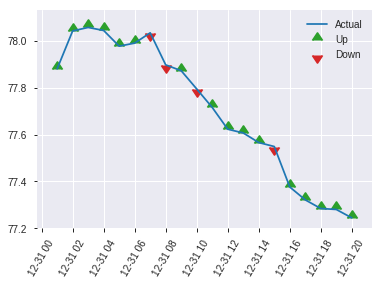


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20255902405486106
RMSE: 0.4500655775049466
LogLoss: 0.5976498893218257
Mean Per-Class Error: 0.29065562850889703
AUC: 0.7729988052568697
pr_auc: 0.714655100499263
Gini: 0.5459976105137394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4839856116817947: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      182  157  0.4631   (157.0/339.0)
1      44   235  0.1577   (44.0/279.0)
Total  226  392  0.3252   (201.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483986     0.700447  238
max f2                       0.200301     0.820452  357
max f0point5                 0.595813     0.694564  153
max accuracy                 0.595813     0.713592  153
max precision                0.998889     1         0
max recall                   0.11972      1         376
max specificity              0.998889     1         0
max absolute_mcc             0.595813     0.418866  153
max min_per_class_accuracy   0.551271     0.698925  188
max mean_per_class_accuracy  0.551271     0.709344  188

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.987915           1.89862   1.89862            0.857143         0.9918    0.857143                    0.9918              0.0215054       0.0215054                  89.8618    89.8618
    2        0.0210356                   0.980358           1.4767    1.70389            0.666667         0.98303   0.769231                    0.987752            0.0143369       0.0358423                  47.6703    70.3888
    3        0.0307443                   0.959957           1.84588   1.74873            0.833333         0.969484  0.789474                    0.981983            0.0179211       0.0537634                  84.5878    74.8727
    4        0.0404531                   0.93617            1.84588   1.77204            0.833333         0.952605  0.8                         0.974932            0.0179211       0.0716846                  84.5878    77.2043
    5        0.0501618                   0.924817           2.21505   1.85779            1                0.931625  0.83871                     0.96655             0.0215054       0.09319                    121.505    85.7787
    6        0.100324                    0.830263           1.64343   1.75061            0.741935         0.87509   0.790323                    0.92082             0.0824373       0.175627                   64.3427    75.0607
    7        0.150485                    0.732652           1.78633   1.76252            0.806452         0.777148  0.795699                    0.872929            0.0896057       0.265233                   78.6334    76.2516
    8        0.200647                    0.684545           1.92924   1.8042             0.870968         0.703312  0.814516                    0.830525            0.0967742       0.362007                   92.924     80.4197
    9        0.300971                    0.627702           1.39334   1.66724            0.629032         0.650899  0.752688                    0.77065             0.139785        0.501792                   39.334     66.7245
    10       0.399676                    0.577408           1.12568   1.5335             0.508197         0.598249  0.692308                    0.728073            0.111111        0.612903                   12.5683    53.3499
    11       0.5                         0.537628           1.00035   1.42652            0.451613         0.557914  0.644013                    0.693931            0.100358        0.713262                   0.0346861  42.6523
    12       0.600324                    0.503217           0.928894  1.34336            0.419355         0.520023  0.606469                    0.664868            0.09319         0.806452                   -7.11065   34.3361
    13       0.699029                    0.445286           0.762559  1.26135            0.344262         0.475396  0.569444                    0.638114            0.0752688       0.88172                    -23.7441   26.135
    14       0.799353                    0.352785           0.5359    1.1703             0.241935         0.407451  0.52834                     0.609165            0.0537634       0.935484                   -46.41     17.0302
    15       0.899676                    0.222465           0.42872   1.08761            0.193548         0.29153   0.491007                    0.573745            0.0430108       0.978495                   -57.128    8.76073
    16       1                           0.0159471          0.21436   1                  0.0967742        0.124677  0.451456                    0

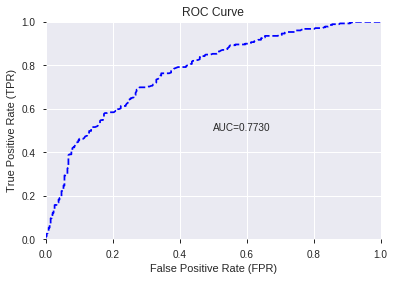

This function is available for GLM models only


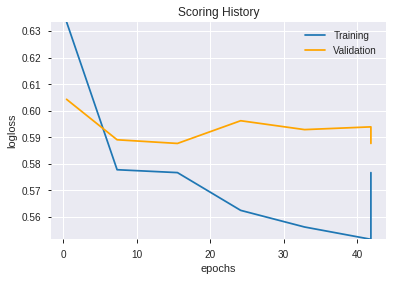

--2019-08-22 13:13:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125512_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125512_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'DIV',
 'PLUS_DI_8',
 'SUB',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'SINH',
 'STOCHRSI_fastk',
 'EXP',
 'STOCHF_fastk',
 'COSH',
 'CDLHAMMER',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'WILLR_8',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'CDLSHOOTINGSTAR',
 'is_month_start',
 'CDLMORNINGSTAR',
 'is_month_end',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'CDLGRAVESTONEDOJI',
 'CDL3LINESTRIKE',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'CDLADVANCEBLOCK',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'CDLINNECK',
 'CDLONNECK',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGSTAR',
 'CDL3INSIDE',
 'CDLSTALLEDPATTERN',
 'CDLSEPARATINGLINES']

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_131404_model_1  0.769314  0.572519              0.302741  0.440714  0.194229

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.706489           1.000000    0.183608
1    CDLCLOSINGMARUBOZU             0.326077           0.461546    0.084744
2             PLUS_DI_8             0.222934           0.315552    0.057938
3          STOCHF_fastk             0.206774           0.292679    0.053738
4             CDLHAMMER             0.165863           0.234771    0.043106
5             CDLTAKURI             0.131418           0.186016    0.034154
6                   SUB             0.122648           0.173602    0.031875
7         CDLHANGINGMAN             0.116440           0.164815    0.030262
8       CDLSHOOTINGSTAR             0.112220           0.158842    0.029165
9        STOCHRSI_fastk             0.109037           0.154336    0.028337
10               TRANGE             0.104804           0.148344    0.027237
11    CDLDARKCLOUDCOVER             0.103210           0.146089    0.026823
12   CDLEVENINGDOJISTAR             0.096444           0.136511    0.025065
13          CDLMARUBOZU             0.079254           0.112180    0.020597
14            CDLONNECK             0.071502           0.101208    0.018583
15              WILLR_8             0.069381           0.098206    0.018031
16    CDL3WHITESOLDIERS             0.068988           0.097649    0.017929
17                  DIV             0.068237           0.096586    0.017734
18     CDLSTICKSANDWICH             0.065082           0.092121    0.016914
19      CDLLADDERBOTTOM             0.060362           0.085439    0.015687
20      CDLHOMINGPIGEON             0.060334           0.085400    0.015680
21          CDLPIERCING             0.055625           0.078734    0.014456
22         CDLENGULFING             0.054233           0.076764    0.014094
23       CDLMORNINGSTAR             0.049210           0.069654    0.012789
24   CDLMORNINGDOJISTAR             0.046929           0.066425    0.012196
25      CDLUNIQUE3RIVER             0.043893           0.062129    0.011407
26            CDLINNECK             0.042132           0.059636    0.010950
27   CDLIDENTICAL3CROWS             0.041477           0.058708    0.010779
28    CDLGRAVESTONEDOJI             0.040589           0.057452    0.010549
29         CDLTASUKIGAP             0.038012           0.053804    0.009879
30       CDL3LINESTRIKE             0.037950           0.053716    0.009863
31       CDLEVENINGSTAR             0.035259           0.049907    0.009163
32          CDLLONGLINE             0.029032           0.041093    0.007545
33          CDLDOJISTAR             0.027488           0.038907    0.007144
34           CDL3INSIDE             0.025498           0.036091    0.006627
35      CDLADVANCEBLOCK             0.024632           0.034865    0.006402
36  CDLGAPSIDESIDEWHITE             0.024071           0.034071    0.006256
37       CDLMATCHINGLOW             0.023804           0.033693    0.006186
38                 COSH             0.020574           0.029121    0.005347
39                  EXP             0.020280           0.028705    0.005270
40                 SINH             0.020048           0.028376    0.005210
41    CDLSTALLEDPATTERN             0.019746           0.027949    0.005132
42       is_month_start             0.017339           0.024542    0.004506
43   CDLSEPARATINGLINES             0.013338           0.018880    0.003466
44         HT_TRENDMODE             0.011879           0.016814    0.003087
45     CDLDRAGONFLYDOJI             0.005697           0.008064    0.001481
46         CDLTHRUSTING             0.005288           0.007484    0.001374
47         is_month_end             0.003322           0.004702    0.000863
48     is_quarter_start             0.002172           0.003075    0.000565
49    CDLINVERTEDHAMMER             0.000788           0.001115    0.000205

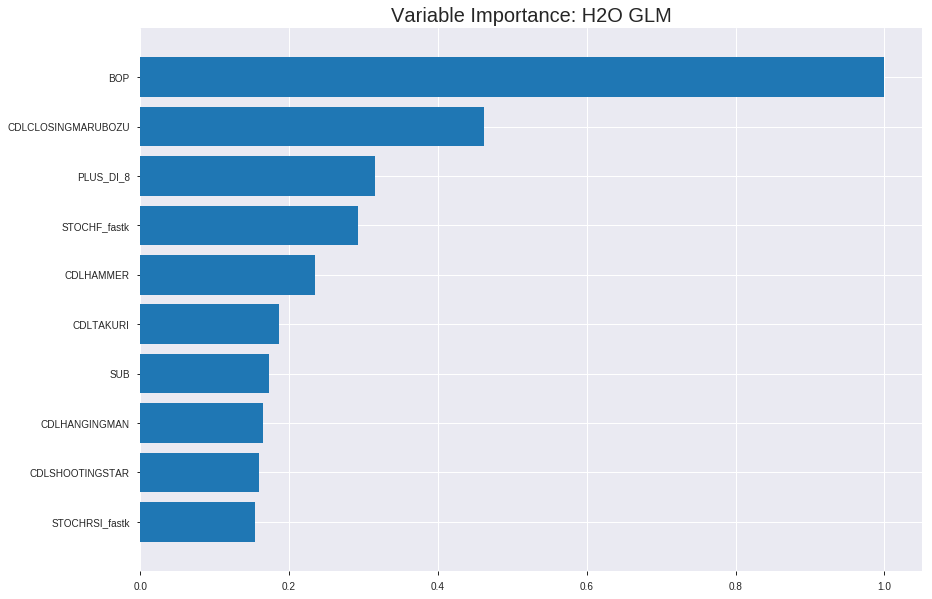

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131404_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1964662567110015
RMSE: 0.4432451429074001
LogLoss: 0.5736498632156859
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5975.678574739547
Residual deviance: 4955.1875184570945
AIC: 5057.1875184570945
AUC: 0.7643124256039412
pr_auc: 0.7417787958516405
Gini: 0.5286248512078824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36216386288527724: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1144  1128  0.4965   (1128.0/2272.0)
1      282   1765  0.1378   (282.0/2047.0)
Total  1426  2893  0.3265   (1410.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362164     0.714575  259
max f2                       0.100448     0.829401  369
max f0point5                 0.559911     0.679252  160
max accuracy                 0.508389     0.690438  188
max precision                0.984803     1         0
max recall                   0.0571817    1         387
max specificity              0.984803     1         0
max absolute_mcc             0.362164     0.38835   259
max min_per_class_accuracy   0.489643     0.6875    197
max mean_per_class_accuracy  0.467913     0.69139   207

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.90796            2.10992   2.10992            1                0.935087  1                           0.935087            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.889326           1.91365   2.01291            0.906977         0.897308  0.954023                    0.916414            0.0190523       0.0405471                  91.3646   101.291
    3        0.0300996                   0.876497           1.91365   1.98008            0.906977         0.882776  0.938462                    0.905288            0.0190523       0.0595994                  91.3646   98.0076
    4        0.0400556                   0.862975           2.01178   1.98796            0.953488         0.869794  0.942197                    0.896466            0.0200293       0.0796287                  101.178   98.7956
    5        0.0500116                   0.851236           1.96271   1.98293            0.930233         0.857633  0.939815                    0.888735            0.0195408       0.0991695                  96.2713   98.2931
    6        0.100023                    0.760935           1.70942   1.84618            0.810185         0.804413  0.875                       0.846574            0.085491        0.18466                    70.9423   84.6177
    7        0.150035                    0.713053           1.5629    1.75175            0.740741         0.73697   0.830247                    0.810039            0.0781632       0.262824                   56.2901   75.1752
    8        0.200046                    0.675912           1.49452   1.68745            0.708333         0.694828  0.799769                    0.781236            0.0747435       0.337567                   49.4525   68.7445
    9        0.300069                    0.611486           1.31381   1.5629             0.622685         0.643038  0.740741                    0.73517             0.131412        0.468979                   31.3814   56.2901
    10       0.400093                    0.55193            1.24055   1.48231            0.587963         0.58092   0.702546                    0.696608            0.124084        0.593063                   24.0553   48.2314
    11       0.500116                    0.480849           1.05496   1.39684            0.5              0.516881  0.662037                    0.660662            0.10552         0.698583                   5.49585   39.6843
    12       0.599907                    0.41436            0.974184  1.32654            0.461717         0.447149  0.628715                    0.625145            0.0972154       0.795799                   -2.58156  32.6536
    13       0.699931                    0.336843           0.884016  1.2633             0.418981         0.3761    0.598743                    0.589556            0.0884221       0.884221                   -11.5984  26.3298
    14       0.799954                    0.261001           0.5519    1.17435            0.261574         0.298359  0.556585                    0.553146            0.0552027       0.939424                   -44.81    17.4347
    15       0.899977                    0.160641           0.361421  1.084              0.171296         0.21701   0.513764                    0.515788            0.0361505       0.975574                   -63.8579  8.3999
    16       1                           0.013709           0.244203  1                  0.115741         0.097531  0.473952                    0.473952          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19825287338465425
RMSE: 0.4452559638956611
LogLoss: 0.5815435192939105
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1718.4207619926892
Residual deviance: 1435.2494056173712
AIC: 1537.2494056173712
AUC: 0.7696976709936673
pr_auc: 0.754614465764292
Gini: 0.5393953419873345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33356869315017407: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      281  315  0.5285   (315.0/596.0)
1      74   564  0.116    (74.0/638.0)
Total  355  879  0.3152   (389.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333569     0.743573  270
max f2                       0.122442     0.856719  362
max f0point5                 0.48287      0.726384  200
max accuracy                 0.48287      0.713128  200
max precision                0.989297     1         0
max recall                   0.0278624    1         396
max specificity              0.989297     1         0
max absolute_mcc             0.48287      0.427045  200
max min_per_class_accuracy   0.471416     0.709732  205
max mean_per_class_accuracy  0.48287      0.713624  200

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.90304            1.48782   1.48782            0.769231         0.941742  0.769231                    0.941742            0.015674        0.015674                   48.7823   48.7823
    2        0.0202593                   0.889198           1.61181   1.54734            0.833333         0.896222  0.8                         0.919893            0.015674        0.031348                   61.1808   54.7335
    3        0.0299838                   0.873826           1.77299   1.62052            0.916667         0.8822    0.837838                    0.907668            0.0172414       0.0485893                  77.2989   62.052
    4        0.0405186                   0.860162           1.78539   1.66339            0.923077         0.869055  0.86                        0.897629            0.0188088       0.0673981                  78.5387   66.3386
    5        0.0502431                   0.844005           1.45063   1.62221            0.75             0.852368  0.83871                     0.888869            0.0141066       0.0815047                  45.0627   62.2206
    6        0.100486                    0.750128           1.6846    1.6534             0.870968         0.795348  0.854839                    0.842108            0.0846395       0.166144                   68.4599   65.3403
    7        0.149919                    0.694412           1.55368   1.62052            0.803279         0.718106  0.837838                    0.801221            0.0768025       0.242947                   55.3677   62.052
    8        0.200162                    0.658901           1.49742   1.58962            0.774194         0.677205  0.821862                    0.770092            0.0752351       0.318182                   49.7421   58.9621
    9        0.299838                    0.598373           1.39952   1.52643            0.723577         0.627358  0.789189                    0.722642            0.139498        0.45768                    39.9521   52.6425
    10       0.400324                    0.539525           1.31024   1.47216            0.677419         0.571247  0.761134                    0.68464             0.131661        0.589342                   31.0244   47.2161
    11       0.5                         0.477808           1.16365   1.41066            0.601626         0.509404  0.729335                    0.649707            0.115987        0.705329                   16.3647   41.0658
    12       0.599676                    0.409068           0.754798  1.30164            0.390244         0.440937  0.672973                    0.615006            0.0752351       0.780564                   -24.5202  30.1644
    13       0.700162                    0.342211           0.904692  1.24467            0.467742         0.374568  0.643519                    0.580498            0.0909091       0.871473                   -9.53079  24.4674
    14       0.799838                    0.267681           0.550373  1.15815            0.284553         0.302322  0.598784                    0.545832            0.0548589       0.926332                   -44.9627  15.815
    15       0.899514                    0.175882           0.550373  1.0908             0.284553         0.229159  0.563964                    0.510741            0.0548589       0.981191                   -44.9627  9.08018
    16       1                           0.00476676         0.187178  1                  0.0967742        0.101547  0.517018                    0.469623            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:14:04  0.000 sec   2            .2E2      51            1.3683029018767774  1.3772648452146852
     2019-08-22 13:14:04  0.031 sec   4            .12E2     51            1.360015778882494   1.3689399612270474
     2019-08-22 13:14:04  0.063 sec   6            .76E1     51            1.348043321909268   1.3568809762830307
     2019-08-22 13:14:04  0.091 sec   8            .47E1     51            1.331655935182693   1.3403135814856202
     2019-08-22 13:14:05  0.120 sec   10           .29E1     51            1.3108066634771673  1.3191273896149067
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:14:05  0.392 sec   36           .6E-2     51            1.1464760795407571  1.1635081171289392
     2019-08-22 13:14:05  0.405 sec   37           .37E-2    51            1.1460235612016476  1.1641179595249511
     2019-08-22 13:14:05  0.414 sec   38           .23E-2    51            1.1457490426137904  1.1649835141964608
     2019-08-22 13:14:05  0.423 sec   39           .14E-2    51            1.1455635618655216  1.165932936057974
     2019-08-22 13:14:05  0.434 sec   40           .9E-3     51            1.1454117338013277  1.1668785717415326


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7103559870550162)

('F1', 0.6970172684458398)

('auc', 0.7693141328596652)

('logloss', 0.5725190931327565)

('mean_per_class_error', 0.29601611317283605)

('rmse', 0.44071420275167306)

('mse', 0.1942290085070428)

glm prediction progress: |████████████████████████████████████████████████| 100%


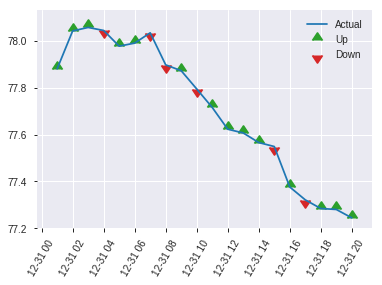


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1942290085070428
RMSE: 0.44071420275167306
LogLoss: 0.5725190931327565
Null degrees of freedom: 617
Residual degrees of freedom: 567
Null deviance: 852.1522922482045
Residual deviance: 707.6335991120872
AIC: 809.6335991120872
AUC: 0.7693141328596652
pr_auc: 0.7398311886776643
Gini: 0.5386282657193304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37890225461649113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      203  136  0.4012   (136.0/339.0)
1      57   222  0.2043   (57.0/279.0)
Total  260  358  0.3123   (193.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378902     0.697017  238
max f2                       0.10533      0.813679  370
max f0point5                 0.589081     0.698351  128
max accuracy                 0.589081     0.710356  128
max precision                0.98537      1         0
max recall                   0.0581466    1         390
max specificity              0.98537      1         0
max absolute_mcc             0.589081     0.417882  128
max min_per_class_accuracy   0.454415     0.693215  203
max mean_per_class_accuracy  0.425589     0.703984  217

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.897197           2.21505   2.21505            1                0.921067   1                           0.921067            0.0250896       0.0250896                  121.505    121.505
    2        0.0210356                   0.884269           2.21505   2.21505            1                0.88989    1                           0.906678            0.0215054       0.046595                   121.505    121.505
    3        0.0307443                   0.872503           1.84588   2.09847            0.833333         0.879003   0.947368                    0.897938            0.0179211       0.0645161                  84.5878    109.847
    4        0.0404531                   0.849869           1.84588   2.03785            0.833333         0.865301   0.92                        0.890105            0.0179211       0.0824373                  84.5878    103.785
    5        0.0501618                   0.822922           1.84588   2.00069            0.833333         0.838091   0.903226                    0.880038            0.0179211       0.100358                   84.5878    100.069
    6        0.100324                    0.741641           1.78633   1.89351            0.806452         0.776651   0.854839                    0.828344            0.0896057       0.189964                   78.6334    89.3514
    7        0.150485                    0.700164           2.00069   1.92924            0.903226         0.719817   0.870968                    0.792169            0.100358        0.290323                   100.069    92.924
    8        0.200647                    0.667879           1.42907   1.8042             0.645161         0.683576   0.814516                    0.76502             0.0716846       0.362007                   42.9067    80.4197
    9        0.300971                    0.589226           1.46479   1.69106            0.66129          0.631732   0.763441                    0.720591            0.146953        0.508961                   46.4794    69.1063
    10       0.399676                    0.512614           1.08937   1.54247            0.491803         0.545651   0.696356                    0.677387            0.107527        0.616487                   8.93707    54.2467
    11       0.5                         0.435427           1.00035   1.43369            0.451613         0.478515   0.647249                    0.637484            0.100358        0.716846                   0.0346861  43.3692
    12       0.600324                    0.3712             0.928894  1.34933            0.419355         0.400374   0.609164                    0.597859            0.09319         0.810036                   -7.11065   34.9332
    13       0.699029                    0.317485           0.726247  1.26135            0.327869         0.346674   0.569444                    0.562391            0.0716846       0.88172                    -27.3753   26.135
    14       0.799353                    0.256363           0.32154   1.1434             0.145161         0.284127   0.516194                    0.527467            0.0322581       0.913978                   -67.846    14.3398
    15       0.899676                    0.146842           0.5359    1.07566            0.241935         0.210622   0.485612                    0.492135            0.0537634       0.967742                   -46.41     7.56556
    16       1                           0.00869816         0.32154   1                  0.145161         0.0923764  0.451456    

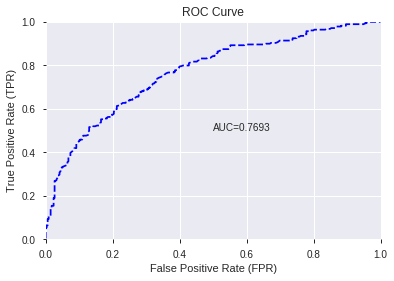

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


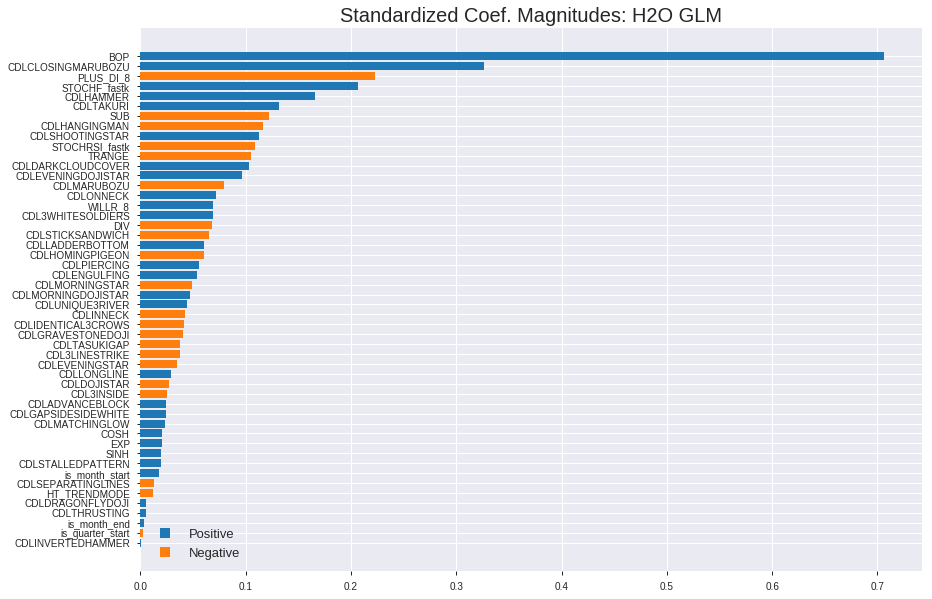

'log_likelihood'
--2019-08-22 13:14:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131404_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131404_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'CDLHAMMER',
 'CDLTAKURI',
 'SUB',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLMARUBOZU',
 'CDLONNECK',
 'WILLR_8',
 'CDL3WHITESOLDIERS',
 'DIV',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLHOMINGPIGEON',
 'CDLPIERCING',
 'CDLENGULFING',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'CDLIDENTICAL3CROWS',
 'CDLGRAVESTONEDOJI',
 'CDLTASUKIGAP',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLLONGLINE',
 'CDLDOJISTAR',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDLMATCHINGLOW',
 'COSH',
 'EXP',
 'SINH',
 'CDLSTALLEDPATTERN',
 'is_month_start',
 'CDLSEPARATINGLINES',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTHRUSTING',
 'is_month_end',
 'is_quarter_start',
 'CDLINVERTEDHAMMER']

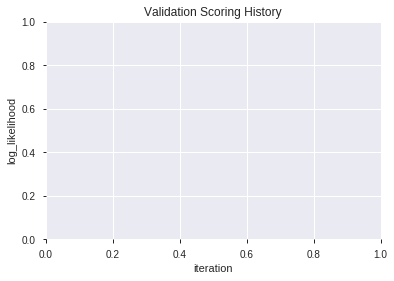

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_131513_model_3  0.776847  0.571361              0.308307  0.440130  0.193715
1               XGBoost_3_AutoML_20190822_131513  0.775520  0.573694              0.289260  0.441402  0.194835
2  XGBoost_grid_1_AutoML_20190822_131513_model_2  0.774003  0.577173              0.304723  0.442686  0.195971
3  XGBoost_grid_1_AutoML_20190822_131513_model_6  0.773623  0.573415              0.309782  0.441155  0.194618
4  XGBoost_grid_1_AutoML_20190822_131513_model_1  0.771656  0.575090              0.298411  0.442244  0.195580
5               XGBoost_1_AutoML_20190822_131513  0.769208  0.574826              0.291163  0.442206  0.195546
6  XGBoost_grid_1_AutoML_20190822_131513_model_4  0.766523  0.578753              0.298522  0.443915  0.197060
7               XGBoost_2_AutoML_20190822_131513  0.762204  0.579357              0.314936  0.444679  0.197740
8  XGBoost_grid_1_AutoML_20190822_131513_model_7  0.761289  0.578950              0.334317  0.444697  0.197756
9  XGBoost_grid_1_AutoML_20190822_131513_model_5  0.756140  0.588539              0.305786  0.447799  0.200524

variable  relative_importance  scaled_importance  percentage
0                  BOP          3961.562988           1.000000    0.339331
1         STOCHF_fastk          1013.510681           0.255836    0.086813
2            PLUS_DI_8           935.131775           0.236051    0.080099
3       STOCHRSI_fastk           919.226318           0.232036    0.078737
4                  DIV           862.230286           0.217649    0.073855
5   CDLCLOSINGMARUBOZU           626.027222           0.158025    0.053623
6                 COSH           623.575745           0.157406    0.053413
7              WILLR_8           581.434814           0.146769    0.049803
8               TRANGE           539.769470           0.136252    0.046234
9                  SUB           465.500488           0.117504    0.039873
10                 EXP           282.933380           0.071420    0.024235
11           CDLHAMMER           207.610672           0.052406    0.017783
12         CDLLONGLINE           125.035065           0.031562    0.010710
13        CDLENGULFING            98.362762           0.024829    0.008425
14                SINH            77.972847           0.019682    0.006679
15    CDLDRAGONFLYDOJI            77.964104           0.019680    0.006678
16           CDLTAKURI            72.108124           0.018202    0.006176
17        HT_TRENDMODE            51.705925           0.013052    0.004429
18       CDLHANGINGMAN            49.948067           0.012608    0.004278
19     CDLSHOOTINGSTAR            42.807606           0.010806    0.003667
20   CDLGRAVESTONEDOJI            38.597454           0.009743    0.003306
21     CDLADVANCEBLOCK             9.137257           0.002306    0.000783
22         CDLMARUBOZU             8.244114           0.002081    0.000706
23        is_month_end             4.239392           0.001070    0.000363

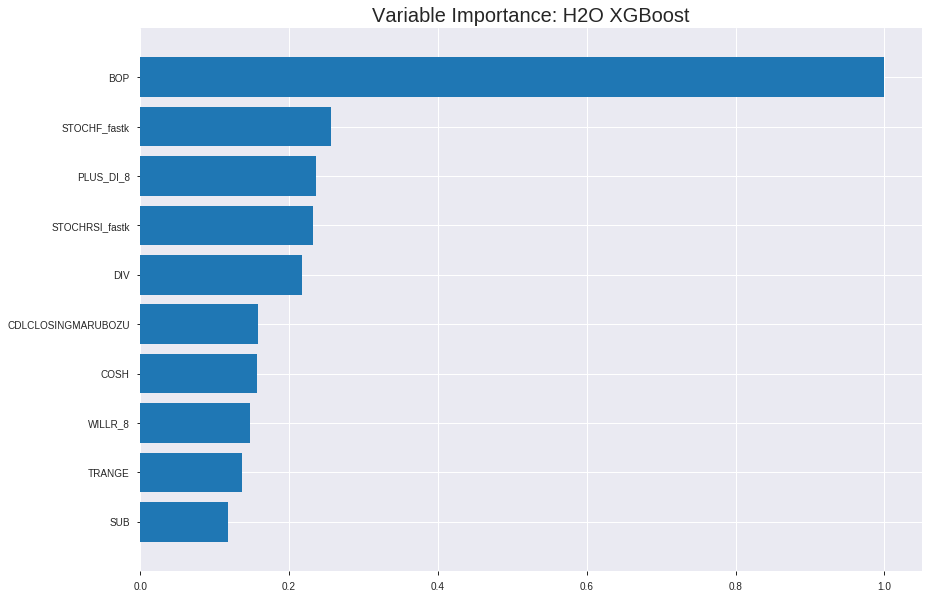

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_131513_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17490246739438536
RMSE: 0.418213423259447
LogLoss: 0.5221815710357055
Mean Per-Class Error: 0.26425415585845313
AUC: 0.8231933583671054
pr_auc: 0.8062587325505556
Gini: 0.6463867167342108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4211069196462631: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1320  952   0.419    (952.0/2272.0)
1      265   1782  0.1295   (265.0/2047.0)
Total  1585  2734  0.2818   (1217.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421107     0.745451  236
max f2                       0.28115      0.850204  294
max f0point5                 0.563454     0.738698  159
max accuracy                 0.527002     0.734661  181
max precision                0.953403     1         0
max recall                   0.0880215    1         381
max specificity              0.953403     1         0
max absolute_mcc             0.476852     0.472889  209
max min_per_class_accuracy   0.509529     0.729313  190
max mean_per_class_accuracy  0.493336     0.735746  200

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.935945           2.10992    2.10992            1                0.944566   1                           0.944566            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.911095           2.10992    2.10992            1                0.923279   1                           0.934045            0.0210064       0.0425012                  110.992   110.992
    3        0.0300996                   0.896519           2.06085    2.09369            0.976744         0.90401    0.992308                    0.924111            0.0205178       0.0630191                  106.085   109.369
    4        0.0400556                   0.874842           2.01178    2.07333            0.953488         0.885863   0.982659                    0.914604            0.0200293       0.0830484                  101.178   107.333
    5        0.0500116                   0.858426           2.06085    2.07084            0.976744         0.867196   0.981481                    0.905166            0.0205178       0.103566                   106.085   107.084
    6        0.100023                    0.754933           1.87548    1.97316            0.888889         0.806445   0.935185                    0.855805            0.0937958       0.197362                   87.5482   97.3163
    7        0.150035                    0.693779           1.79734    1.91455            0.851852         0.723952   0.907407                    0.811854            0.0898876       0.28725                    79.7337   91.4554
    8        0.200046                    0.652402           1.67035    1.8535             0.791667         0.673774   0.878472                    0.777334            0.0835369       0.370787                   67.0351   85.3503
    9        0.300069                    0.593142           1.39684    1.70128            0.662037         0.620294   0.806327                    0.724987            0.139717        0.510503                   39.6843   70.1283
    10       0.400093                    0.547645           1.28939    1.59831            0.611111         0.56972    0.757523                    0.68617             0.128969        0.639472                   28.9394   59.8311
    11       0.500116                    0.504126           1.04519    1.48769            0.49537          0.526147   0.705093                    0.654166            0.104543        0.744016                   4.51903   48.7687
    12       0.599907                    0.444061           0.939917   1.39657            0.445476         0.475353   0.661907                    0.624421            0.0937958       0.837811                   -6.00834  39.6568
    13       0.699931                    0.351302           0.820523   1.31425            0.388889         0.402084   0.622891                    0.592648            0.0820713       0.919883                   -17.9477  31.4249
    14       0.799954                    0.246407           0.449334   1.2061             0.212963         0.299594   0.571635                    0.556006            0.0449438       0.964827                   -55.0666  20.6103
    15       0.899977                    0.143267           0.28816    1.10408            0.136574         0.193063   0.523283                    0.515669            0.0288227       0.993649                   -71.184   10.4083
    16       1                           0.031855           0.0634929  1                  0.0300926        0.0989657  0.473952 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19782608071047697
RMSE: 0.4447764390235582
LogLoss: 0.5786839350405326
Mean Per-Class Error: 0.3015111190591404
AUC: 0.7688863583766384
pr_auc: 0.7649104814811253
Gini: 0.5377727167532769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35452701151371: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      276  320  0.5369   (320.0/596.0)
1      62   576  0.0972   (62.0/638.0)
Total  338  896  0.3096   (382.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354527     0.750978  274
max f2                       0.21478      0.85312   334
max f0point5                 0.506558     0.71134   189
max accuracy                 0.462929     0.700162  215
max precision                0.950064     1         0
max recall                   0.0998983    1         384
max specificity              0.950064     1         0
max absolute_mcc             0.378656     0.410103  263
max min_per_class_accuracy   0.486703     0.688088  202
max mean_per_class_accuracy  0.462929     0.698489  215

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.928681           1.78539   1.78539            0.923077         0.938082  0.923077                    0.938082            0.0188088       0.0188088                  78.5387   78.5387
    2        0.0202593                   0.90853            1.77299   1.77944            0.916667         0.915715  0.92                        0.927346            0.0172414       0.0360502                  77.2989   77.9436
    3        0.0299838                   0.861015           1.77299   1.77734            0.916667         0.890857  0.918919                    0.915511            0.0172414       0.0532915                  77.2989   77.7345
    4        0.0405186                   0.842437           1.78539   1.77944            0.923077         0.851205  0.92                        0.898792            0.0188088       0.0721003                  78.5387   77.9436
    5        0.0502431                   0.824605           1.61181   1.74699            0.833333         0.831567  0.903226                    0.88578             0.015674        0.0877743                  61.1808   74.6992
    6        0.100486                    0.7468             1.62221   1.6846             0.83871          0.785885  0.870968                    0.835833            0.0815047       0.169279                   62.2206   68.4599
    7        0.149919                    0.68083            1.52197   1.63098            0.786885         0.70927   0.843243                    0.794101            0.0752351       0.244514                   52.1969   63.0975
    8        0.200162                    0.641477           1.49742   1.59745            0.774194         0.659142  0.825911                    0.760225            0.0752351       0.319749                   49.7421   59.7452
    9        0.299838                    0.583905           1.3209    1.50552            0.682927         0.610421  0.778378                    0.710425            0.131661        0.451411                   32.0896   50.5516
    10       0.400324                    0.531641           1.26345   1.44475            0.653226         0.556495  0.746964                    0.671787            0.126959        0.57837                    26.3449   44.4754
    11       0.5                         0.487837           1.05357   1.36677            0.544715         0.510356  0.706645                    0.639605            0.105016        0.683386                   5.35719   36.6771
    12       0.599676                    0.441549           0.959222  1.29903            0.495935         0.465991  0.671622                    0.610748            0.0956113       0.778997                   -4.07778  29.903
    13       0.700162                    0.378537           1.01388   1.25811            0.524194         0.411713  0.650463                    0.582183            0.101881        0.880878                   1.38791   25.8105
    14       0.799838                    0.2706             0.566098  1.17187            0.292683         0.326644  0.605876                    0.550337            0.0564263       0.937304                   -43.3902  17.1868
    15       0.899514                    0.1852             0.377399  1.08383            0.195122         0.228136  0.56036                     0.514634            0.0376176       0.974922                   -62.2601  8.38318
    16       1                           0.0449944          0.24957   1                  0.129032         0.132327  0.517018                    0.476217          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:15:26  3.746 sec   0                  0.5              0.693147            0.5             0                  1                0.526048                         0.5                0.693147              0.5               0                    1                  0.482982
    2019-08-22 13:15:27  3.909 sec   5                  0.477933         0.649644            0.777982        0.758228           2.10992          0.321602                         0.48123            0.656059              0.763353          0.760081             1.79601            0.318476
    2019-08-22 13:15:27  4.026 sec   10                 0.464104         0.622295            0.782563        0.763608           2.10992          0.311878                         0.470344           0.634479              0.768851          0.761043             1.6366             0.313614
    2019-08-22 13:15:27  4.150 sec   15                 0.452906         0.599705            0.789709        0.77078            2.10992          0.325307                         0.461439           0.616501              0.770547          0.765819             1.78539            0.322528
    2019-08-22 13:15:27  4.281 sec   20                 0.44552          0.584091            0.793217        0.775058           2.10992          0.313962                         0.455817           0.604683              0.770385          0.764922             1.78539            0.321718
    2019-08-22 13:15:27  4.426 sec   25                 0.440086         0.572186            0.797           0.779014           2.10992          0.306552                         0.452304           0.597002              0.770939          0.765361             1.78539            0.318476
    2019-08-22 13:15:27  4.565 sec   30                 0.436135         0.56325             0.800324        0.783689           2.10992          0.303774                         0.449957           0.5918                0.772643          0.767438             1.78539            0.320908
    2019-08-22 13:15:27  4.706 sec   35                 0.433428         0.55667             0.801798        0.785205           2.10992          0.3047                           0.448255           0.587693              0.773147          0.768443             1.78539            0.309562
    2019-08-22 13:15:28  4.870 sec   40                 0.430516         0.550152            0.805204        0.78982            2.10992          0.305626                         0.446947           0.584627              0.773356          0.766001             1.78539            0.316856
    2019-08-22 13:15:28  5.035 sec   45                 0.428106         0.544666            0.808523        0.793126           2.10992          0.287798                         0.446141           0.582611              0.773122          0.765948             1.78539            0.311994
    2019-08-22 13:15:28  5.202 sec   50                 0.426128         0.54004             0.811009        0.794368           2.10992          0.287335                         0.445361           0.580629              0.772558          0.767061             1.78539            0.307942
    2019-08-22 13:15:28  5.362 sec   55                 0.424487         0.536252            0.813402        0.798653           2.10992          0.30169                          0.445345           0.580336              0.771988          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                3961.56298828125       1.0                    0.3393307337140761
STOCHF_fastk       1013.5106811523438     0.2558360637330323     0.086813039217051
PLUS_DI_8          935.1317749023438      0.23605121959907466    0.08009943354065652
STOCHRSI_fastk     919.226318359375       0.23203627484367914    0.07873703939098667
DIV                862.2302856445312      0.21764901585437507    0.07385500024201168
---                ---                    ---                    ---
CDLSHOOTINGSTAR    42.8076057434082       0.010805736490884513   0.0036667184917728085
CDLGRAVESTONEDOJI  38.59745407104492      0.009742986337771365   0.003306094702562177
CDLADVANCEBLOCK    9.137256622314453      0.002306477683011349   0.0007826587644713834
CDLMARUBOZU        8.24411392211914       0.002081025581697466   0.0007061559375151634
is_month_end       4.239392280578613      0.0010701312318191617  0.00036312841606354424


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7168284789644013)

('F1', 0.7032640949554896)

('auc', 0.7768473583489285)

('logloss', 0.5713614355344383)

('mean_per_class_error', 0.28537444095537157)

('rmse', 0.4401303144055879)

('mse', 0.19371469365876165)

xgboost prediction progress: |████████████████████████████████████████████| 100%


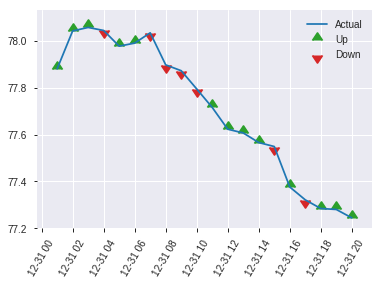


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19371469365876165
RMSE: 0.4401303144055879
LogLoss: 0.5713614355344383
Mean Per-Class Error: 0.28537444095537157
AUC: 0.7768473583489285
pr_auc: 0.7223182362910333
Gini: 0.553694716697857
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930119127035141: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  158  0.4661   (158.0/339.0)
1      42   237  0.1505   (42.0/279.0)
Total  223  395  0.3236   (200.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393012     0.703264  240
max f2                       0.247655     0.820481  319
max f0point5                 0.566999     0.694037  131
max accuracy                 0.505695     0.716828  176
max precision                0.947338     1         0
max recall                   0.107217     1         384
max specificity              0.947338     1         0
max absolute_mcc             0.505695     0.428451  176
max min_per_class_accuracy   0.48862      0.707965  184
max mean_per_class_accuracy  0.479995     0.714626  193

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 46.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.919889           1.89862   1.89862            0.857143         0.936237  0.857143                    0.936237            0.0215054       0.0215054                  89.8618   89.8618
    2        0.0210356                   0.890391           1.84588   1.87428            0.833333         0.909558  0.846154                    0.923924            0.0179211       0.0394265                  84.5878   87.4276
    3        0.0307443                   0.871122           1.84588   1.86531            0.833333         0.880053  0.842105                    0.91007             0.0179211       0.0573477                  84.5878   86.5308
    4        0.0404531                   0.854822           1.4767    1.77204            0.666667         0.863777  0.8                         0.898959            0.0143369       0.0716846                  47.6703   77.2043
    5        0.0501618                   0.832715           1.84588   1.78633            0.833333         0.846055  0.806452                    0.88872             0.0179211       0.0896057                  84.5878   78.6334
    6        0.100324                    0.720908           1.92924   1.85779            0.870968         0.784882  0.83871                     0.836801            0.0967742       0.18638                    92.924    85.7787
    7        0.150485                    0.662294           1.85779   1.85779            0.83871          0.692593  0.83871                     0.788731            0.09319         0.27957                    85.7787   85.7787
    8        0.200647                    0.625922           1.71488   1.82206            0.774194         0.644814  0.822581                    0.752752            0.0860215       0.365591                   71.488    82.206
    9        0.300971                    0.566882           1.42907   1.69106            0.645161         0.59392   0.763441                    0.699808            0.143369        0.508961                   42.9067   69.1063
    10       0.399676                    0.525907           1.05306   1.5335             0.47541          0.546968  0.692308                    0.662062            0.103943        0.612903                   5.30583   53.3499
    11       0.5                         0.481037           1.21471   1.46953            0.548387         0.505193  0.66343                     0.630587            0.121864        0.734767                   21.4707   46.9534
    12       0.600324                    0.418471           0.785987  1.3553             0.354839         0.453402  0.61186                     0.600976            0.078853        0.81362                    -21.4013  35.5302
    13       0.699029                    0.34755            0.798872  1.27673            0.360656         0.385321  0.576389                    0.570525            0.078853        0.892473                   -20.1128  27.6732
    14       0.799353                    0.261728           0.500173  1.17927            0.225806         0.298909  0.532389                    0.536436            0.0501792       0.942652                   -49.9827  17.927
    15       0.899676                    0.176404           0.32154   1.08362            0.145161         0.215874  0.489209                    0.50069             0.0322581       0.97491                    -67.846   8.36234
    16       1                           0.0355273          0.250087  1                  0.112903         0.126175  0.451456                    0.463117           

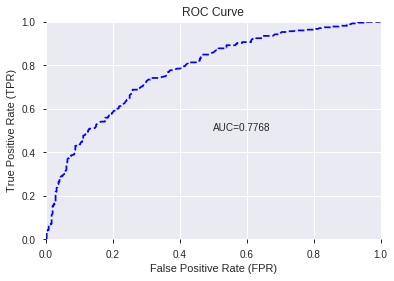

This function is available for GLM models only


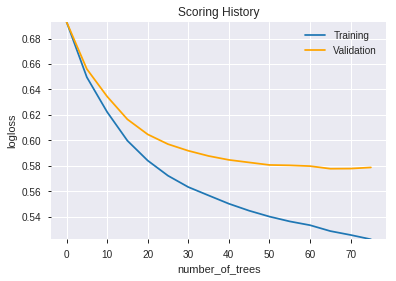

--2019-08-22 13:15:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_131513_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_131513_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'STOCHRSI_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'COSH',
 'WILLR_8',
 'TRANGE',
 'SUB',
 'EXP',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLENGULFING',
 'SINH',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_end']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 892] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


75

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDL3OUTSIDE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_131656_model_9  0.765355  0.585161              0.291163  0.446825  0.199653
1  DeepLearning_grid_1_AutoML_20190822_131656_model_6  0.759957  0.592268              0.332636  0.448737  0.201365
2  DeepLearning_grid_1_AutoML_20190822_131656_model_8  0.759349  0.587000              0.321359  0.447404  0.200171
3  DeepLearning_grid_1_AutoML_20190822_131656_model_5  0.758926  0.586682              0.317062  0.446668  0.199512
4  DeepLearning_grid_1_AutoML_20190822_131656_model_3  0.758450  0.620291              0.331161  0.449889  0.202400
5               DeepLearning_1_AutoML_20190822_131656  0.749580  0.609134              0.344324  0.458065  0.209824
6  DeepLearning_grid_1_AutoML_20190822_131656_model_4  0.749194  0.621053              0.300647  0.455549  0.207525
7  DeepLearning_grid_1_AutoML_20190822_131656_model_7  0.737183  0.665059              0.321486  0.465522  0.216711
8  DeepLearning_grid_1_AutoML_20190822_131656_model_2  0.724242  0.652879              0.344641  0.469154  0.220105
9  DeepLearning_grid_1_AutoML_20190822_131656_model_1  0.675728  0.961848              0.369001  0.527642  0.278406

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.059297
1                  BOP             0.712292           0.712292    0.042237
2          CDLLONGLINE             0.672692           0.672692    0.039888
3         CDLENGULFING             0.464018           0.464018    0.027515
4               TRANGE             0.403507           0.403507    0.023927
..                 ...                  ...                ...         ...
70               CMO_8             0.131009           0.131009    0.007768
71              RSI_14             0.129307           0.129307    0.007667
72               RSI_8             0.128993           0.128993    0.007649
73              CMO_12             0.127497           0.127497    0.007560
74              RSI_12             0.120904           0.120904    0.007169

[75 rows x 4 columns]

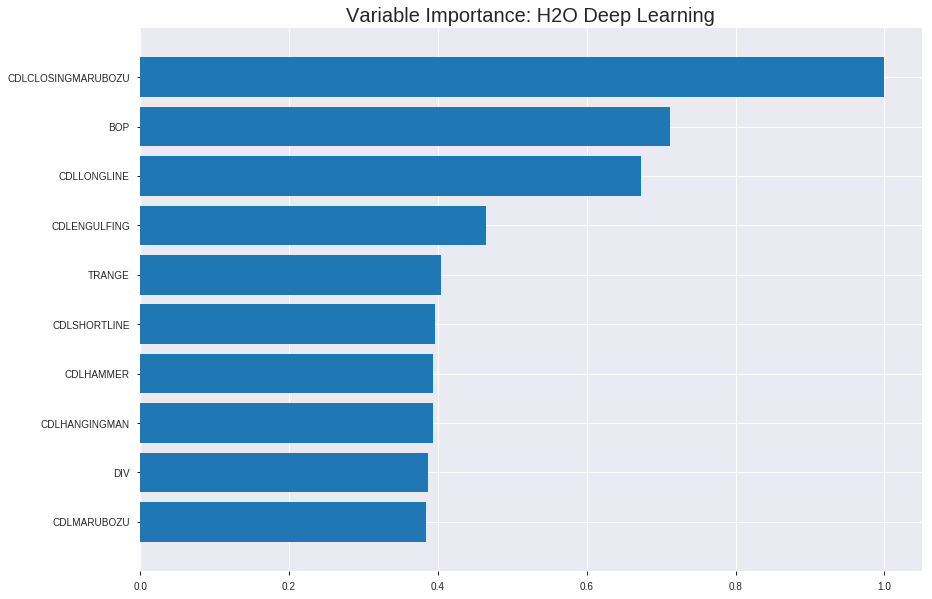

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_131656_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1941197114308514
RMSE: 0.44059018535465744
LogLoss: 0.5684171553656032
Mean Per-Class Error: 0.2954676028815787
AUC: 0.7753831397028974
pr_auc: 0.751140320467605
Gini: 0.5507662794057948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4473061463754235: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1212  1060  0.4665   (1060.0/2272.0)
1      303   1744  0.148    (303.0/2047.0)
Total  1515  2804  0.3156   (1363.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447306     0.719027  231
max f2                       0.147676     0.834091  349
max f0point5                 0.609067     0.693777  150
max accuracy                 0.589177     0.704793  162
max precision                0.98283      1         0
max recall                   0.0280273    1         394
max specificity              0.98283      1         0
max absolute_mcc             0.512114     0.41353   203
max min_per_class_accuracy   0.565887     0.698583  174
max mean_per_class_accuracy  0.512114     0.704532  203

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.924492           1.96606   1.96606            0.931818         0.940939   0.931818                    0.940939            0.0200293       0.0200293                  96.6059   96.6059
    2        0.0201436                   0.910903           2.10992   2.03716            1                0.917939   0.965517                    0.929571            0.0210064       0.0410357                  110.992   103.716
    3        0.0300996                   0.894617           1.91365   1.99631            0.906977         0.900918   0.946154                    0.920094            0.0190523       0.0600879                  91.3646   99.6306
    4        0.0400556                   0.873727           1.81551   1.95137            0.860465         0.883749   0.924855                    0.91106             0.0180752       0.0781632                  81.551    95.1368
    5        0.0500116                   0.857274           2.01178   1.96339            0.953488         0.864589   0.930556                    0.901809            0.0200293       0.0981925                  101.178   96.3395
    6        0.100023                    0.76176            1.78757   1.87548            0.847222         0.801837   0.888889                    0.851823            0.0893991       0.187592                   78.7569   87.5482
    7        0.150035                    0.721698           1.52383   1.75826            0.722222         0.740398   0.833333                    0.814681            0.0762091       0.263801                   52.3829   75.8264
    8        0.200046                    0.697985           1.52383   1.69966            0.722222         0.709138   0.805556                    0.788296            0.0762091       0.34001                    52.3829   69.9655
    9        0.300069                    0.649859           1.32847   1.57593            0.62963          0.673675   0.746914                    0.750089            0.132877        0.472887                   32.8466   57.5926
    10       0.400093                    0.607798           1.33823   1.5165             0.634259         0.629693   0.71875                     0.71999             0.133854        0.606742                   33.8234   51.6503
    11       0.500116                    0.557923           1.02565   1.41833            0.486111         0.584517   0.672222                    0.692895            0.102589        0.709331                   2.56541   41.8333
    12       0.599907                    0.497297           1.00845   1.35015            0.477958         0.529123   0.639907                    0.665652            0.100635        0.809966                   0.845219  35.0151
    13       0.699931                    0.37183            0.698422  1.25702            0.331019         0.440703   0.595766                    0.633506            0.0698583       0.879824                   -30.1578  25.7016
    14       0.799954                    0.251432           0.634929  1.17923            0.300926         0.309099   0.5589                      0.592944            0.0635076       0.943332                   -36.5071  17.9233
    15       0.899977                    0.14944            0.405378  1.09323            0.19213          0.199934   0.518137                    0.549265            0.0405471       0.983879                   -59.4622  9.32268
    16       1                           0.00652237         0.161174  1                  0.0763889        0.0962038  0.473952                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1947135415687794
RMSE: 0.4412635738068342
LogLoss: 0.574178088770356
Mean Per-Class Error: 0.2929561759693673
AUC: 0.7708824241021649
pr_auc: 0.7576987226280397
Gini: 0.5417648482043298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3594024385058144: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      276  320  0.5369   (320.0/596.0)
1      63   575  0.0987   (63.0/638.0)
Total  339  895  0.3104   (383.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359402     0.750163  261
max f2                       0.281774     0.856455  292
max f0point5                 0.581726     0.717855  159
max accuracy                 0.503507     0.709887  199
max precision                0.953542     1         0
max recall                   0.0561492    1         389
max specificity              0.953542     1         0
max absolute_mcc             0.503507     0.421865  199
max min_per_class_accuracy   0.563925     0.702194  167
max mean_per_class_accuracy  0.541988     0.707044  178

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.926977           1.78539   1.78539            0.923077         0.940483  0.923077                    0.940483            0.0188088       0.0188088                  78.5387   78.5387
    2        0.0202593                   0.909308           1.61181   1.70207            0.833333         0.916788  0.88                        0.92911             0.015674        0.0344828                  61.1808   70.2069
    3        0.0299838                   0.891014           1.28945   1.56825            0.666667         0.898548  0.810811                    0.919198            0.0125392       0.0470219                  28.9446   56.8245
    4        0.0405186                   0.873265           1.6366    1.58602            0.846154         0.883049  0.82                        0.909799            0.0172414       0.0642633                  63.6605   58.6019
    5        0.0502431                   0.856376           1.77299   1.62221            0.916667         0.865419  0.83871                     0.901209            0.0172414       0.0815047                  77.2989   62.2206
    6        0.100486                    0.763699           1.6846    1.6534             0.870968         0.803427  0.854839                    0.852318            0.0846395       0.166144                   68.4599   65.3403
    7        0.149919                    0.723315           1.58538   1.63098            0.819672         0.741454  0.843243                    0.815763            0.0783699       0.244514                   58.5385   63.0975
    8        0.200162                    0.691062           1.34144   1.5583             0.693548         0.705017  0.805668                    0.787964            0.0673981       0.311912                   34.144    55.8298
    9        0.299838                    0.646762           1.36807   1.49506            0.707317         0.668234  0.772973                    0.748162            0.136364        0.448276                   36.8071   49.5061
    10       0.400324                    0.609833           1.35704   1.46042            0.701613         0.627185  0.755061                    0.717795            0.136364        0.584639                   35.7038   46.0415
    11       0.5                         0.568355           1.1322    1.39498            0.585366         0.591907  0.721232                    0.692699            0.112853        0.697492                   13.2197   39.4984
    12       0.599676                    0.503308           1.0064    1.33039            0.520325         0.536811  0.687838                    0.666788            0.100313        0.797806                   0.639702  33.0395
    13       0.700162                    0.38628            0.795505  1.25363            0.41129          0.44789   0.648148                    0.635372            0.0799373       0.877743                   -20.4495  25.3628
    14       0.799838                    0.27571            0.707623  1.18559            0.365854         0.324901  0.612969                    0.596681            0.0705329       0.948276                   -29.2377  18.5585
    15       0.899514                    0.175569           0.235874  1.08035            0.121951         0.223977  0.558559                    0.555382            0.023511        0.971787                   -76.4126  8.03468
    16       1                           0.0175547          0.280767  1                  0.145161         0.115936  0.517018                    0.511223         


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:30:50  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:30:54  5 min 43.616 sec   296 obs/sec       0.212086  1             916        0.553497         1.04199             -0.228772      0.731729        0.700971           1.91811          0.370225                         0.577478           1.11128               -0.335472        0.745594          0.73759              1.78539            0.323339
    2019-08-22 13:31:34  6 min 23.788 sec   526 obs/sec       4.80088   23            20735      0.452779         0.596051            0.177734       0.761275        0.730675           1.96606          0.32276                          0.448886           0.59067               0.19307          0.769185          0.755613             1.6366             0.321718
    2019-08-22 13:32:13  7 min  3.015 sec   638 obs/sec       11.044    53            47699      0.450876         0.592285            0.18463        0.761177        0.732457           1.8222           0.328548                         0.455944           0.603009              0.167495         0.768988          0.750954             1.6366             0.32658
    2019-08-22 13:32:53  7 min 43.168 sec   715 obs/sec       18.3642   88            79315      0.44619          0.582346            0.201492       0.762577        0.735178           1.87015          0.323223                         0.443605           0.578422              0.211947         0.771855          0.757874             1.78539            0.314425
    2019-08-22 13:33:33  8 min 22.578 sec   775 obs/sec       26.2839   126           113520     0.445432         0.580384            0.204202       0.766494        0.739512           1.91811          0.326928                         0.446929           0.585556              0.200091         0.770871          0.752466             1.48782            0.311183
    2019-08-22 13:34:12  9 min  1.992 sec   826 obs/sec       34.7856   167           150239     0.445946         0.583296            0.202365       0.765747        0.738426           2.01401          0.319287                         0.442168           0.580469              0.217044         0.769558          0.754342             1.6366             0.317666
    2019-08-22 13:34:53  9 min 42.635 sec   869 obs/sec       43.9836   211           189965     0.442786         0.576472            0.213629       0.770546        0.74172            1.96606          0.319981                         0.446021           0.590792              0.203339         0.773568          0.756112             1.78539            0.307942
    2019-08-22 13:35:33  10 min 22.422 sec  901 obs/sec       53.1554   255           229578     0.44059          0.568417            0.221408       0.775383        0.75114            1.96606          0.315582                         0.441264           0.574178              0.220243         0.770882          0.757699             1.78539            0.310373

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.05929668965643071
BOP                 0.7122915387153625     0.7122915387153625   0.04223653031610635
CDLLONGLINE         0.6726915836334229     0.6726915836334229   0.039888384069203975
CDLENGULFING        0.46401768922805786    0.46401768922805786  0.027514712913250257
TRANGE              0.40350714325904846    0.40350714325904846  0.02392663784798472
---                 ---                    ---                  ---
CMO_8               0.13100872933864594    0.13100872933864594  0.007768383965877017
RSI_14              0.12930667400360107    0.12930667400360107  0.007667457718896789
RSI_8               0.12899339199066162    0.12899339199066162  0.007648881132600576
CMO_12              0.12749667465686798    0.12749667465686798  0.007560130749355214
RSI_12              0.12090439349412918    0.12090439349412918  0.007169230299120357


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7249190938511327)

('F1', 0.6985172981878088)

('auc', 0.765354563813028)

('logloss', 0.5851608070835553)

('mean_per_class_error', 0.2805531766422431)

('rmse', 0.4468254416007451)

('mse', 0.1996529752617009)

deeplearning prediction progress: |███████████████████████████████████████| 100%


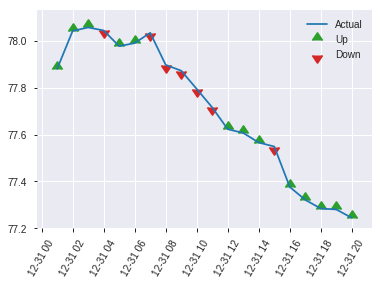


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1996529752617009
RMSE: 0.4468254416007451
LogLoss: 0.5851608070835553
Mean Per-Class Error: 0.2805531766422431
AUC: 0.765354563813028
pr_auc: 0.7120026590145372
Gini: 0.530709127626056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49813789155258836: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      223  116  0.3422   (116.0/339.0)
1      67   212  0.2401   (67.0/279.0)
Total  290  328  0.2961   (183.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498138     0.698517  196
max f2                       0.160044     0.823317  348
max f0point5                 0.600879     0.701831  135
max accuracy                 0.562337     0.724919  157
max precision                0.933392     1         0
max recall                   0.0756411    1         385
max specificity              0.933392     1         0
max absolute_mcc             0.558706     0.442188  160
max min_per_class_accuracy   0.524963     0.709677  180
max mean_per_class_accuracy  0.558706     0.719447  160

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 47.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.916736           1.58218   1.58218            0.714286         0.924149   0.714286                    0.924149            0.0179211       0.0179211                  58.2181   58.2181
    2        0.0210356                   0.900665           2.21505   1.87428            1                0.90927    0.846154                    0.917282            0.0215054       0.0394265                  121.505   87.4276
    3        0.0307443                   0.872476           1.84588   1.86531            0.833333         0.882855   0.842105                    0.90641             0.0179211       0.0573477                  84.5878   86.5308
    4        0.0404531                   0.854761           1.4767    1.77204            0.666667         0.86549    0.8                         0.896589            0.0143369       0.0716846                  47.6703   77.2043
    5        0.0501618                   0.822632           2.21505   1.85779            1                0.840445   0.83871                     0.885723            0.0215054       0.09319                    121.505   85.7787
    6        0.100324                    0.741072           1.78633   1.82206            0.806452         0.77538    0.822581                    0.830552            0.0896057       0.182796                   78.6334   82.206
    7        0.150485                    0.713638           1.78633   1.81015            0.806452         0.728797   0.817204                    0.796634            0.0896057       0.272401                   78.6334   81.0151
    8        0.200647                    0.688525           1.71488   1.78633            0.774194         0.700691   0.806452                    0.772648            0.0860215       0.358423                   71.488    78.6334
    9        0.300971                    0.638723           1.39334   1.65534            0.629032         0.663945   0.747312                    0.736414            0.139785        0.498208                   39.334    65.5336
    10       0.399676                    0.573677           1.37987   1.58731            0.622951         0.604223   0.716599                    0.703767            0.136201        0.634409                   37.987    58.7306
    11       0.5                         0.51313            0.893167  1.44803            0.403226         0.541368   0.653722                    0.671182            0.0896057       0.724014                   -10.6833  44.8029
    12       0.600324                    0.437488           0.64308   1.31351            0.290323         0.481871   0.592992                    0.639545            0.0645161       0.78853                    -35.692   31.3509
    13       0.699029                    0.330035           0.762559  1.23571            0.344262         0.375475   0.55787                     0.602258            0.0752688       0.863799                   -23.7441  23.5713
    14       0.799353                    0.241358           0.571627  1.15237            0.258065         0.283027   0.520243                    0.562192            0.0573477       0.921147                   -42.8373  15.2366
    15       0.899676                    0.151413           0.607353  1.09159            0.274194         0.191996   0.492806                    0.520912            0.0609319       0.982079                   -39.2647  9.15912
    16       1                           0.0170677          0.178633  1                  0.0806452        0.0964519  0.451456                    

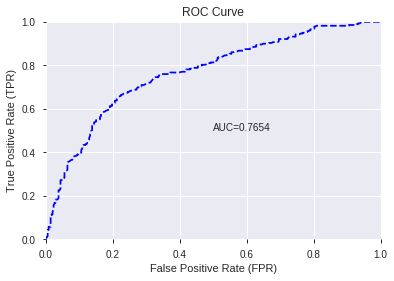

This function is available for GLM models only


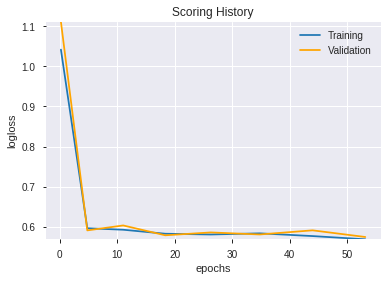

--2019-08-22 13:35:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.12
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_131656_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_131656_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'CDLENGULFING',
 'TRANGE',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'DIV',
 'CDLMARUBOZU',
 'SUB',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'CDL3OUTSIDE',
 'Volume',
 'ULTOSC',
 'MINUS_DM_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_14',
 'CCI_24',
 'ADOSC',
 'STOCHRSI_fastd',
 'WILLR_12',
 'MINUS_DI_14',
 'MINUS_DI_12',
 'WILLR_24',
 'WILLR_8',
 'RSI_30',
 'CCI_12',
 'CCI_20',
 'CCI_14',
 'MINUS_DI_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ROCP_24',
 'ROCR_12',
 'ROCR100_14',
 'ROCR100_12',
 'MOM_12',
 'WILLR_20',
 'RSI_24',
 'WILLR_30',
 'ROC_8',
 'CMO_30',
 'ROCR_8',
 'ROCP_12',
 'ROC_12',
 'CMO_24',
 'ROC_24',
 'MOM_24',
 'ROCR100_24',
 'MOM_8',
 'MOM_20',
 'ROC_14',
 'ROC_20',
 'ROCR_24',
 'ROCP_8',
 'MOM_14',
 'ROCR100_8',
 'ROCP_14',
 'ROCR100_20',
 'ROCR_20',
 'ROCR_14',
 'CMO_14',
 'ROCP_20',
 'RSI_20',
 'CMO_20',
 'CMO_8',
 'RSI_14',
 'RSI_8',
 'CMO_12',
 'RSI_12']

In [0]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_133645_model_1  0.774537  0.572639              0.298728  0.439122  0.192828

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.778863           1.000000    0.136404
1   CDLCLOSINGMARUBOZU             0.286925           0.368390    0.050250
2           MINUS_DM_8             0.252034           0.323593    0.044139
3         STOCHF_fastk             0.240330           0.308565    0.042089
4                CCI_8             0.232190           0.298113    0.040664
..                 ...                  ...                ...         ...
70    CDLDRAGONFLYDOJI             0.005954           0.007645    0.001043
71         CDL3OUTSIDE             0.004645           0.005964    0.000813
72         CDLLONGLINE             0.002457           0.003154    0.000430
73              Volume             0.002199           0.002823    0.000385
74              CCI_12             0.001909           0.002451    0.000334

[75 rows x 4 columns]

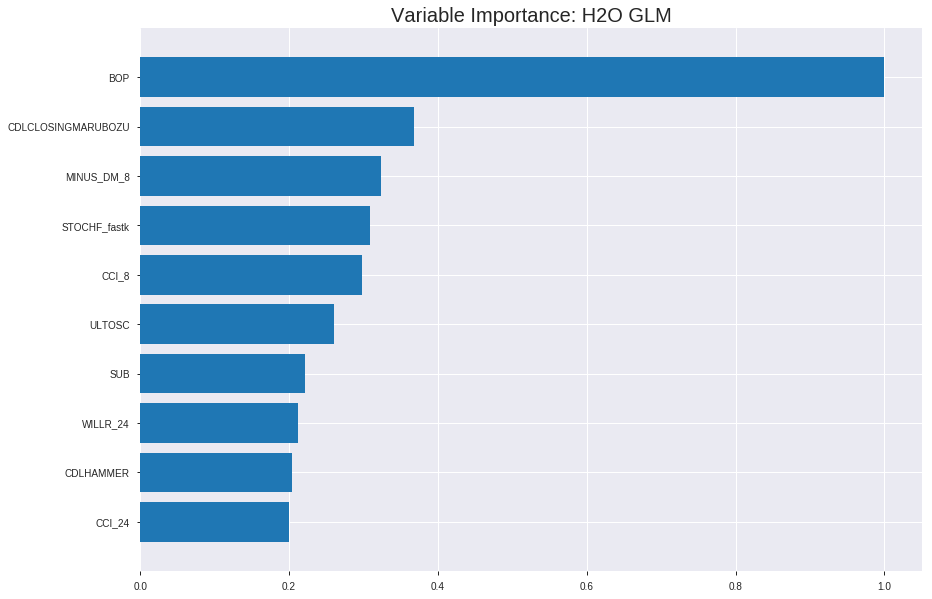

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_133645_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1947216745357211
RMSE: 0.4412727892536782
LogLoss: 0.5703313751133396
Null degrees of freedom: 4318
Residual degrees of freedom: 4243
Null deviance: 5975.678574739547
Residual deviance: 4926.522418229028
AIC: 5078.522418229028
AUC: 0.7693134103841417
pr_auc: 0.7470509092862504
Gini: 0.5386268207682834
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3322109289372276: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1050  1222  0.5379   (1222.0/2272.0)
1      231   1816  0.1128   (231.0/2047.0)
Total  1281  3038  0.3364   (1453.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.332211     0.714258  269
max f2                       0.0935462    0.829534  369
max f0point5                 0.507635     0.685282  187
max accuracy                 0.507635     0.70132   187
max precision                0.969926     1         0
max recall                   0.051284     1         388
max specificity              0.969926     1         0
max absolute_mcc             0.502371     0.400873  190
max min_per_class_accuracy   0.494095     0.698504  194
max mean_per_class_accuracy  0.502371     0.700529  190

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.903648           2.06196   2.06196            0.977273         0.917555   0.977273                    0.917555            0.0210064       0.0210064                  106.196   106.196
    2        0.0201436                   0.889911           2.01178   2.03716            0.953488         0.89682    0.965517                    0.907307            0.0200293       0.0410357                  101.178   103.716
    3        0.0300996                   0.876644           1.81551   1.96385            0.860465         0.883224   0.930769                    0.899341            0.0180752       0.0591109                  81.551    96.3846
    4        0.0400556                   0.863485           1.91365   1.95137            0.906977         0.869873   0.924855                    0.892017            0.0190523       0.0781632                  91.3646   95.1368
    5        0.0500116                   0.851248           1.91365   1.94386            0.906977         0.858065   0.921296                    0.885258            0.0190523       0.0972154                  91.3646   94.3859
    6        0.100023                    0.766327           1.83641   1.89013            0.87037          0.806841   0.895833                    0.84605             0.0918417       0.189057                   83.6409   89.0134
    7        0.150035                    0.716014           1.62151   1.80059            0.768519         0.739589   0.853395                    0.810563            0.0810943       0.270151                   62.151    80.0593
    8        0.200046                    0.681553           1.38708   1.69721            0.657407         0.697981   0.804398                    0.782417            0.0693698       0.339521                   38.7075   69.7213
    9        0.300069                    0.617417           1.30893   1.56779            0.62037          0.649038   0.743056                    0.737958            0.130923        0.470445                   30.893    56.7786
    10       0.400093                    0.557175           1.24544   1.4872             0.590278         0.588365   0.704861                    0.70056             0.124573        0.595017                   24.5437   48.7198
    11       0.500116                    0.486312           1.13799   1.41736            0.539352         0.521561   0.671759                    0.66476             0.113825        0.708842                   13.7988   41.7356
    12       0.599907                    0.416101           0.890963  1.32979            0.422274         0.452087   0.630259                    0.629383            0.0889106       0.797753                   -10.9037  32.9793
    13       0.699931                    0.334279           0.859596  1.2626             0.407407         0.376825   0.598412                    0.593291            0.0859795       0.883732                   -14.0404  26.26
    14       0.799954                    0.24779            0.512827  1.16885            0.243056         0.293215   0.55398                     0.555771            0.0512946       0.935027                   -48.7173  16.8851
    15       0.899977                    0.14803            0.415146  1.08508            0.196759         0.203025   0.514278                    0.516567            0.0415242       0.976551                   -58.4854  8.50846
    16       1                           0.0127496          0.234435  1                  0.111111         0.0905215  0.473952                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19499961883981928
RMSE: 0.44158761173726246
LogLoss: 0.5731205362792694
Null degrees of freedom: 1233
Residual degrees of freedom: 1158
Null deviance: 1718.4207619926892
Residual deviance: 1414.461483537237
AIC: 1566.461483537237
AUC: 0.7760816624939513
pr_auc: 0.7570094787311118
Gini: 0.5521633249879025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3850934765967343: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      340  256  0.4295   (256.0/596.0)
1      107  531  0.1677   (107.0/638.0)
Total  447  787  0.2942   (363.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385093     0.745263  246
max f2                       0.151321     0.855782  352
max f0point5                 0.510968     0.724882  182
max accuracy                 0.464402     0.712318  207
max precision                0.783012     0.866667  46
max recall                   0.0663123    1         384
max specificity              0.921636     0.998322  0
max absolute_mcc             0.464402     0.423521  207
max min_per_class_accuracy   0.487268     0.702194  196
max mean_per_class_accuracy  0.464402     0.711294  207

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 47.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.905643           1.48782   1.48782            0.769231         0.91258    0.769231                    0.91258             0.015674        0.015674                   48.7823   48.7823
    2        0.0202593                   0.890683           1.45063   1.46997            0.75             0.898267   0.76                        0.90571             0.0141066       0.0297806                  45.0627   46.9969
    3        0.0299838                   0.878351           1.61181   1.51597            0.833333         0.886347   0.783784                    0.89943             0.015674        0.0454545                  61.1808   51.5971
    4        0.0405186                   0.866965           1.78539   1.58602            0.923077         0.873311   0.82                        0.892639            0.0188088       0.0642633                  78.5387   58.6019
    5        0.0502431                   0.85115            1.61181   1.59101            0.833333         0.857478   0.822581                    0.885834            0.015674        0.0799373                  61.1808   59.101
    6        0.100486                    0.753557           1.7158    1.6534             0.887097         0.805068   0.854839                    0.845451            0.0862069       0.166144                   71.5795   65.3403
    7        0.149919                    0.709023           1.6488    1.65189            0.852459         0.729958   0.854054                    0.807369            0.0815047       0.247649                   64.88     65.1885
    8        0.200162                    0.678482           1.52862   1.62094            0.790323         0.692716   0.838057                    0.77859             0.0768025       0.324451                   52.8618   62.0943
    9        0.299838                    0.612414           1.35235   1.53165            0.699187         0.646932   0.791892                    0.734822            0.134796        0.459248                   35.2346   53.1653
    10       0.400324                    0.553497           1.23225   1.4565             0.637097         0.582945   0.753036                    0.696699            0.123824        0.583072                   23.2253   45.65
    11       0.5                         0.490047           1.1322    1.39185            0.585366         0.523497   0.719611                    0.662171            0.112853        0.695925                   13.2197   39.185
    12       0.599676                    0.41772            1.03785   1.33301            0.536585         0.454051   0.689189                    0.627578            0.103448        0.799373                   3.78469   33.3009
    13       0.700162                    0.338428           0.733113  1.24691            0.379032         0.376851   0.644676                    0.591594            0.0736677       0.873041                   -26.6887  24.6912
    14       0.799838                    0.265609           0.628998  1.16991            0.325203         0.302804   0.604863                    0.555605            0.0626959       0.935737                   -37.1002  16.9908
    15       0.899514                    0.161594           0.440299  1.08906            0.227642         0.219361   0.563063                    0.518346            0.0438871       0.979624                   -55.9701  8.90593
    16       1                           0.0151379          0.202776  1                  0.104839         0.0941572  0.517018                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:36:45  0.000 sec   2            .2E2      76            1.3613059304293225  1.3693835273300006
     2019-08-22 13:36:45  0.052 sec   4            .12E2     76            1.3520564377492506  1.35976378716719
     2019-08-22 13:36:45  0.107 sec   6            .76E1     76            1.3399386182710775  1.3471815022175828
     2019-08-22 13:36:45  0.160 sec   8            .47E1     76            1.3243601307865533  1.3310275349902063
     2019-08-22 13:36:46  0.212 sec   10           .29E1     76            1.3049879240542699  1.3109724317859508
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:36:46  0.991 sec   38           .37E-2    76            1.1395157907190905  1.146821549022384
     2019-08-22 13:36:46  1.045 sec   40           .23E-2    76            1.1387380026338503  1.1474981916219245
     2019-08-22 13:36:46  1.075 sec   41           .14E-2    76            1.138215342449374   1.1482233315023018
     2019-08-22 13:36:46  1.114 sec   42           .9E-3     76            1.137895878800369   1.1488452621317133
     2019-08-22 13:36:46  1.146 sec   43           .56E-3    76            1.1376463693527141  1.1494003068426368


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7184466019417476)

('F1', 0.705521472392638)

('auc', 0.7745371691988878)

('logloss', 0.57263930672952)

('mean_per_class_error', 0.2957940812636788)

('rmse', 0.43912171780582826)

('mse', 0.19282788304874146)

glm prediction progress: |████████████████████████████████████████████████| 100%


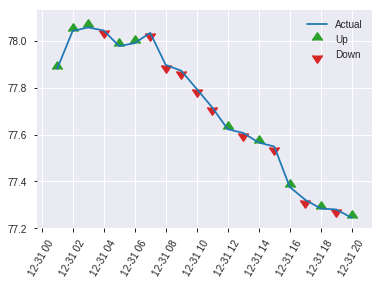


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19282788304874146
RMSE: 0.43912171780582826
LogLoss: 0.57263930672952
Null degrees of freedom: 617
Residual degrees of freedom: 542
Null deviance: 852.1522922482045
Residual deviance: 707.7821831176866
AIC: 859.7821831176866
AUC: 0.7745371691988878
pr_auc: 0.742988989848266
Gini: 0.5490743383977756
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3651755151873521: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      196  143  0.4218   (143.0/339.0)
1      49   230  0.1756   (49.0/279.0)
Total  245  373  0.3107   (192.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365176     0.705521  241
max f2                       0.0571901    0.811991  387
max f0point5                 0.571716     0.707591  134
max accuracy                 0.571716     0.718447  134
max precision                0.943381     1         0
max recall                   0.0571901    1         387
max specificity              0.943381     1         0
max absolute_mcc             0.571716     0.433058  134
max min_per_class_accuracy   0.464944     0.695341  193
max mean_per_class_accuracy  0.406695     0.704206  222

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 44.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.905676           2.21505   2.21505            1                0.92107    1                           0.92107             0.0250896       0.0250896                  121.505   121.505
    2        0.0210356                   0.884701           1.84588   2.04467            0.833333         0.889905   0.923077                    0.906686            0.0179211       0.0430108                  84.5878   104.467
    3        0.0307443                   0.868939           1.84588   1.98189            0.833333         0.875586   0.894737                    0.896865            0.0179211       0.0609319                  84.5878   98.189
    4        0.0404531                   0.85794            2.21505   2.03785            1                0.862575   0.92                        0.888635            0.0215054       0.0824373                  121.505   103.785
    5        0.0501618                   0.827839           1.4767    1.92924            0.666667         0.843018   0.870968                    0.879806            0.0143369       0.0967742                  47.6703   92.924
    6        0.100324                    0.736467           1.78633   1.85779            0.806452         0.781674   0.83871                     0.83074             0.0896057       0.18638                    78.6334   85.7787
    7        0.150485                    0.700566           1.92924   1.8816             0.870968         0.717558   0.849462                    0.793013            0.0967742       0.283154                   92.924    88.1605
    8        0.200647                    0.654263           2.07215   1.92924            0.935484         0.676549   0.870968                    0.763897            0.103943        0.387097                   107.215   92.924
    9        0.300971                    0.584772           1.25043   1.70297            0.564516         0.620238   0.768817                    0.716011            0.125448        0.512545                   25.0434   70.2971
    10       0.399676                    0.508817           1.01675   1.5335             0.459016         0.545343   0.692308                    0.673862            0.100358        0.612903                   1.6746    53.3499
    11       0.5                         0.447877           1.03607   1.43369            0.467742         0.477479   0.647249                    0.634458            0.103943        0.716846                   3.60735   43.3692
    12       0.600324                    0.36544            1.03607   1.36724            0.467742         0.405107   0.617251                    0.59613             0.103943        0.820789                   3.60735   36.7243
    13       0.699029                    0.300363           0.580998  1.25622            0.262295         0.329402   0.56713                     0.558467            0.0573477       0.878136                   -41.9002  25.6223
    14       0.799353                    0.244202           0.500173  1.16133            0.225806         0.273127   0.524291                    0.522655            0.0501792       0.928315                   -49.9827  16.1334
    15       0.899676                    0.124083           0.32154   1.06769            0.145161         0.193875   0.482014                    0.485993            0.0322581       0.960573                   -67.846   6.76878
    16       1                           0.0139652          0.392993  1                  0.177419         0.0754513  0.451456                    0.

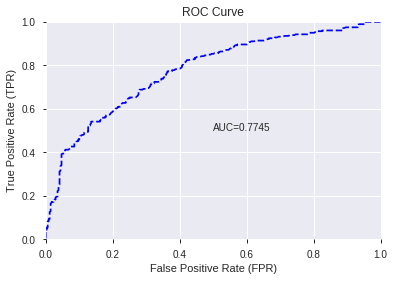

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


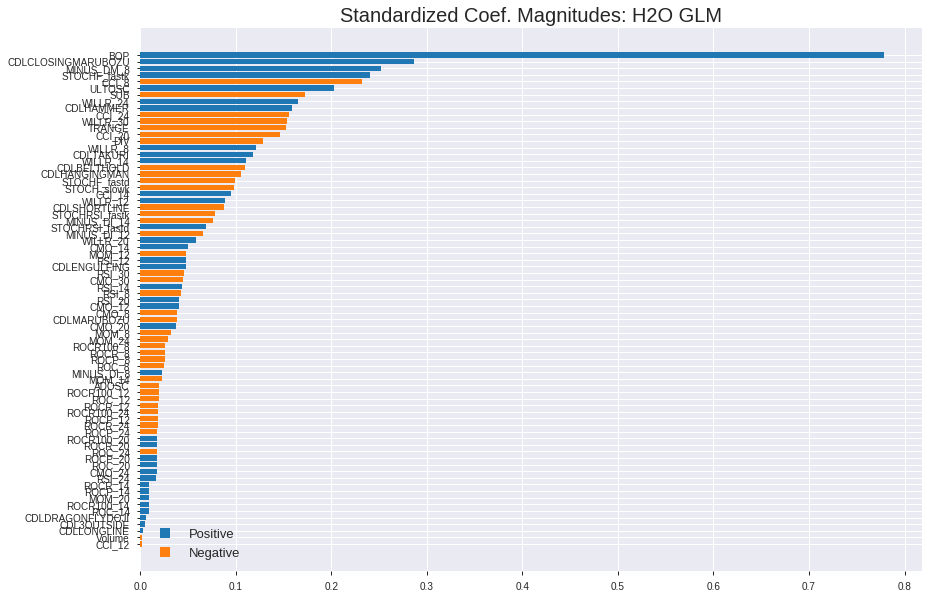

'log_likelihood'
--2019-08-22 13:36:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_133645_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_133645_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DM_8',
 'STOCHF_fastk',
 'CCI_8',
 'ULTOSC',
 'SUB',
 'WILLR_24',
 'CDLHAMMER',
 'CCI_24',
 'WILLR_30',
 'TRANGE',
 'CCI_20',
 'DIV',
 'WILLR_8',
 'CDLTAKURI',
 'WILLR_14',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_14',
 'WILLR_12',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'MINUS_DI_14',
 'STOCHRSI_fastd',
 'MINUS_DI_12',
 'WILLR_20',
 'CMO_14',
 'MOM_12',
 'RSI_12',
 'CDLENGULFING',
 'RSI_30',
 'CMO_30',
 'RSI_14',
 'RSI_8',
 'RSI_20',
 'CMO_12',
 'CMO_8',
 'CDLMARUBOZU',
 'CMO_20',
 'MOM_8',
 'MOM_24',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'MINUS_DI_8',
 'MOM_14',
 'ADOSC',
 'ROCR100_12',
 'ROC_12',
 'ROCR_12',
 'ROCR100_24',
 'ROCP_12',
 'ROCR_24',
 'ROCP_24',
 'ROCR100_20',
 'ROCR_20',
 'ROC_24',
 'ROCP_20',
 'ROC_20',
 'CMO_24',
 'RSI_24',
 'ROCR_14',
 'ROCP_14',
 'MOM_20',
 'ROCR100_14',
 'ROC_14',
 'CDLDRAGONFLYDOJI',
 'CDL3OUTSIDE',
 'CDLLONGLINE',
 'Volume',
 'CCI_12']

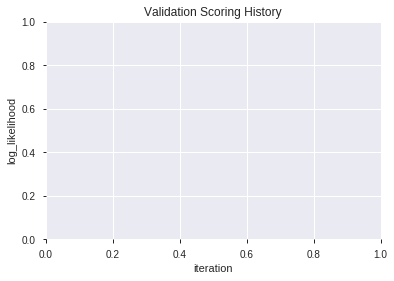

In [0]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_133756_model_6  0.782715  0.568020              0.300298  0.437388  0.191309
1  XGBoost_grid_1_AutoML_20190822_133756_model_5  0.775859  0.574151              0.282726  0.438816  0.192559
2  XGBoost_grid_1_AutoML_20190822_133756_model_2  0.775388  0.575579              0.307768  0.441118  0.194585
3               XGBoost_3_AutoML_20190822_133756  0.774590  0.574272              0.317458  0.440500  0.194041
4  XGBoost_grid_1_AutoML_20190822_133756_model_4  0.773543  0.574482              0.302725  0.440984  0.194467
5  XGBoost_grid_1_AutoML_20190822_133756_model_7  0.771857  0.572741              0.297364  0.439765  0.193394
6  XGBoost_grid_1_AutoML_20190822_133756_model_3  0.769208  0.576849              0.292622  0.442670  0.195957
7  XGBoost_grid_1_AutoML_20190822_133756_model_1  0.767860  0.578927              0.303470  0.443213  0.196438
8               XGBoost_1_AutoML_20190822_133756  0.766153  0.575457              0.291147  0.441908  0.195283
9               XGBoost_2_AutoML_20190822_133756  0.763171  0.581063              0.317997  0.443721  0.196888

variable  relative_importance  scaled_importance  percentage
0                  BOP          4275.342285           1.000000    0.254377
1         STOCHF_fastk           765.285278           0.179000    0.045533
2                  DIV           681.756165           0.159462    0.040563
3   CDLCLOSINGMARUBOZU           670.851929           0.156912    0.039915
4       STOCHRSI_fastk           646.923035           0.151315    0.038491
..                 ...                  ...                ...         ...
65             ROCR_24             5.034633           0.001178    0.000300
66             ROCR_14             4.341454           0.001015    0.000258
67          ROCR100_20             3.366398           0.000787    0.000200
68          ROCR100_24             2.942918           0.000688    0.000175
69         CDLMARUBOZU             2.765126           0.000647    0.000165

[70 rows x 4 columns]

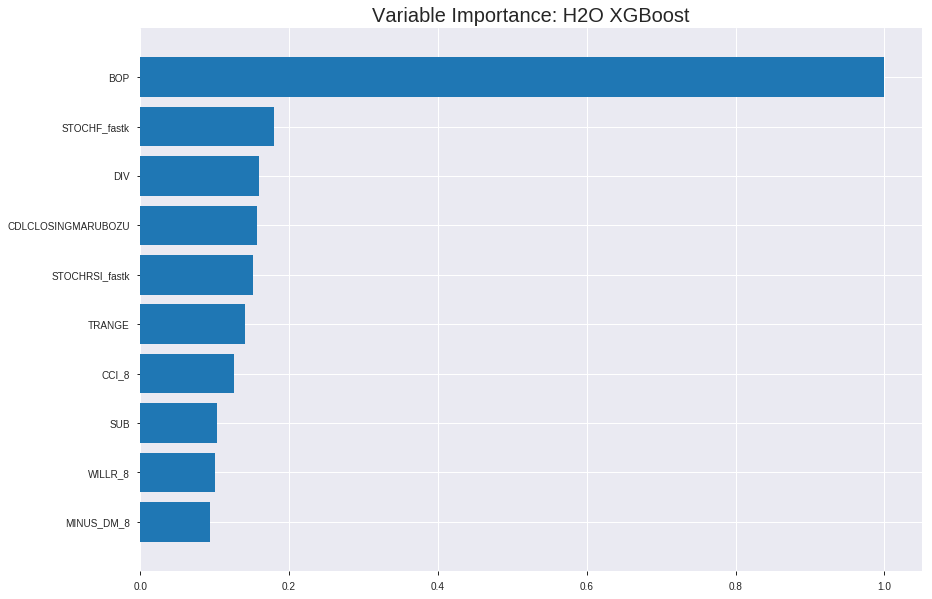

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_133756_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16231099809430968
RMSE: 0.402878391198026
LogLoss: 0.4938580198510306
Mean Per-Class Error: 0.23284902072424774
AUC: 0.8582427177869366
pr_auc: 0.8499494485245218
Gini: 0.7164854355738732
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44988977450590867: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1508  764   0.3363   (764.0/2272.0)
1      299   1748  0.1461   (299.0/2047.0)
Total  1807  2512  0.2461   (1063.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44989      0.766835  222
max f2                       0.245597     0.859052  312
max f0point5                 0.581194     0.775851  150
max accuracy                 0.528448     0.768233  179
max precision                0.962052     1         0
max recall                   0.128008     1         366
max specificity              0.962052     1         0
max absolute_mcc             0.548812     0.535328  168
max min_per_class_accuracy   0.508902     0.764085  190
max mean_per_class_accuracy  0.48831      0.767151  201

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.937426           2.10992    2.10992            1                0.947298  1                           0.947298            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.921735           2.10992    2.10992            1                0.929444  1                           0.938474            0.0210064       0.0425012                  110.992   110.992
    3        0.0300996                   0.897412           2.10992    2.10992            1                0.91102   1                           0.929393            0.0210064       0.0635076                  110.992   110.992
    4        0.0400556                   0.876292           2.06085    2.09772            0.976744         0.886449  0.99422                     0.918719            0.0205178       0.0840254                  106.085   109.772
    5        0.0500116                   0.854011           2.10992    2.10015            1                0.864574  0.99537                     0.90794             0.0210064       0.105032                   110.992   110.015
    6        0.100023                    0.759219           2.01224    2.05619            0.953704         0.801593  0.974537                    0.854767            0.100635        0.205667                   101.224   105.619
    7        0.150035                    0.701314           1.94386    2.01875            0.921296         0.728968  0.95679                     0.812834            0.0972154       0.302882                   94.3859   101.875
    8        0.200046                    0.659949           1.83641    1.97316            0.87037          0.681512  0.935185                    0.780003            0.0918417       0.394724                   83.6409   97.3163
    9        0.300069                    0.600929           1.48476    1.81036            0.703704         0.629195  0.858025                    0.729734            0.14851         0.543234                   48.4756   81.0361
    10       0.400093                    0.551787           1.30893    1.685              0.62037          0.576553  0.798611                    0.691439            0.130923        0.674157                   30.893    68.5003
    11       0.500116                    0.499475           1.04519    1.55704            0.49537          0.527028  0.737963                    0.658556            0.104543        0.778701                   4.51903   55.7041
    12       0.599907                    0.434253           0.851799   1.43973            0.403712         0.46817   0.682362                    0.626887            0.0850024       0.863703                   -14.8201  43.9727
    13       0.699931                    0.341085           0.674001   1.3303             0.319444         0.390568  0.6305                      0.593116            0.0674157       0.931119                   -32.5999  33.0302
    14       0.799954                    0.233757           0.454218   1.22076            0.215278         0.289021  0.578582                    0.555093            0.0454323       0.976551                   -54.5782  22.0759
    15       0.899977                    0.149067           0.205131   1.10788            0.0972222        0.188916  0.525084                    0.514396            0.0205178       0.997069                   -79.4869  10.7883
    16       1                           0.0347554          0.0293044  1                  0.0138889        0.102455  0.473952                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19436107810971026
RMSE: 0.44086401317153373
LogLoss: 0.5700416280703131
Mean Per-Class Error: 0.2897451137152596
AUC: 0.7787628074309397
pr_auc: 0.7732591593177397
Gini: 0.5575256148618795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.280796080827713: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      246  350  0.5872   (350.0/596.0)
1      48   590  0.0752   (48.0/638.0)
Total  294  940  0.3225   (398.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280796     0.747782  296
max f2                       0.154481     0.856987  356
max f0point5                 0.547142     0.722433  159
max accuracy                 0.439011     0.713128  221
max precision                0.963435     1         0
max recall                   0.101916     1         381
max specificity              0.963435     1         0
max absolute_mcc             0.437074     0.42765   222
max min_per_class_accuracy   0.494371     0.702194  191
max mean_per_class_accuracy  0.439011     0.710255  221

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 47.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.932625           1.93417   1.93417            1                0.948852  1                           0.948852            0.0203762       0.0203762                  93.4169   93.4169
    2        0.0202593                   0.912101           1.77299   1.8568             0.916667         0.919846  0.96                        0.934929            0.0172414       0.0376176                  77.2989   85.6803
    3        0.0299838                   0.892497           1.77299   1.82962            0.916667         0.90278   0.945946                    0.924503            0.0172414       0.0548589                  77.2989   82.962
    4        0.0405186                   0.872679           1.33904   1.70207            0.692308         0.879903  0.88                        0.912907            0.0141066       0.0689655                  33.904    70.2069
    5        0.0502431                   0.850886           1.61181   1.6846             0.833333         0.861469  0.870968                    0.902951            0.015674        0.0846395                  61.1808   68.4599
    6        0.100486                    0.752497           1.6846    1.6846             0.870968         0.802139  0.870968                    0.852545            0.0846395       0.169279                   68.4599   68.4599
    7        0.149919                    0.688209           1.61709   1.66234            0.836066         0.717988  0.859459                    0.808178            0.0799373       0.249216                   61.7092   66.234
    8        0.200162                    0.646833           1.46623   1.61311            0.758065         0.665652  0.834008                    0.772402            0.0736677       0.322884                   46.6225   61.3113
    9        0.299838                    0.596865           1.39952   1.54211            0.723577         0.620147  0.797297                    0.721787            0.139498        0.462382                   39.9521   54.2108
    10       0.400324                    0.549706           1.27905   1.47608            0.66129          0.57288   0.763158                    0.68441             0.128527        0.590909                   27.9047   47.6077
    11       0.5                         0.495936           1.0693    1.39498            0.552846         0.521618  0.721232                    0.651957            0.106583        0.697492                   6.92968   39.4984
    12       0.599676                    0.429681           1.02212   1.33301            0.528455         0.468477  0.689189                    0.62146             0.101881        0.799373                   2.2122    33.3009
    13       0.700162                    0.350704           0.733113  1.24691            0.379032         0.394622  0.644676                    0.588904            0.0736677       0.873041                   -26.6887  24.6912
    14       0.799838                    0.236185           0.676173  1.17579            0.349593         0.295358  0.607903                    0.552323            0.0673981       0.940439                   -32.3827  17.5787
    15       0.899514                    0.154045           0.440299  1.09429            0.227642         0.192143  0.565766                    0.512411            0.0438871       0.984326                   -55.9701  9.42868
    16       1                           0.0373199          0.155981  1                  0.0806452        0.112001  0.517018                    0.472175           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:38:28  21.342 sec  0                  0.5              0.693147            0.5             0                  1                0.526048                         0.5                0.693147              0.5               0                    1                  0.482982
    2019-08-22 13:38:29  21.553 sec  5                  0.477438         0.64869             0.787349        0.764642           2.10992          0.320676                         0.480262           0.654162              0.7628            0.752411             1.54734            0.307131
    2019-08-22 13:38:29  21.694 sec  10                 0.460915         0.61628             0.798746        0.780434           2.10992          0.318129                         0.467424           0.628776              0.768865          0.76415              1.78539            0.313614
    2019-08-22 13:38:29  21.822 sec  15                 0.449761         0.593791            0.805331        0.789519           2.10992          0.300533                         0.459493           0.612547              0.770417          0.761464             1.6366             0.314425
    2019-08-22 13:38:29  21.954 sec  20                 0.440524         0.574866            0.812523        0.799441           2.10992          0.302153                         0.452943           0.598914              0.775026          0.766168             1.78539            0.315235
    2019-08-22 13:38:29  22.085 sec  25                 0.434475         0.561838            0.816425        0.803656           2.10992          0.300533                         0.449014           0.590238              0.776095          0.768817             1.78539            0.313614
    2019-08-22 13:38:29  22.228 sec  30                 0.429426         0.550715            0.819813        0.807955           2.10992          0.295439                         0.446375           0.584134              0.776201          0.770243             1.78539            0.318476
    2019-08-22 13:38:29  22.360 sec  35                 0.424994         0.540924            0.825588        0.812668           2.10992          0.274601                         0.44498            0.580445              0.775345          0.769168             1.78539            0.316045
    2019-08-22 13:38:30  22.494 sec  40                 0.421578         0.533353            0.829244        0.818749           2.10992          0.276221                         0.443453           0.57695               0.778118          0.770182             1.78539            0.316045
    2019-08-22 13:38:30  22.630 sec  45                 0.41835          0.526273            0.833828        0.823215           2.10992          0.26997                          0.442826           0.575226              0.778042          0.770841             1.78539            0.311183
    2019-08-22 13:38:30  22.766 sec  50                 0.415566         0.520033            0.837785        0.827424           2.10992          0.269738                         0.442364           0.573984              0.777871          0.769849             1.78539            0.313614
    2019-08-22 13:38:30  22.902 sec  55                 0.412473         0.513684            0.843137        0.834359           2.10992          0.266034                         0.441061           0.571063              0.780318          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 4275.34228515625       1.0                    0.2543766183203811
STOCHF_fastk        765.2852783203125      0.17899976827056405    0.04553335573279793
DIV                 681.7561645507812      0.15946235858537003    0.040563495526338415
CDLCLOSINGMARUBOZU  670.8519287109375      0.15691186435296609    0.03991470942845386
STOCHRSI_fastk      646.9230346679688      0.15131491036730543    0.03849097520068673
---                 ---                    ---                    ---
ROCR_24             5.034632682800293      0.0011775975692707124  0.0002995532874133845
ROCR_14             4.341453552246094      0.0010154633857783453  0.00025831014210246005
ROCR100_20          3.3663978576660156     0.0007873984427759062  0.00020029575314406913
ROCR100_24          2.942918062210083      0.0006883467722403725  0.00017509932415425553
CDLMARUBOZU         2.7651262283325195     0.0006467613687757548  0.00016452096984943742


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7297734627831716)

('F1', 0.7102526002971769)

('auc', 0.7827153445195124)

('logloss', 0.5680202451276541)

('mean_per_class_error', 0.2701018174897707)

('rmse', 0.4373883618547787)

('mse', 0.19130857908600685)

xgboost prediction progress: |████████████████████████████████████████████| 100%


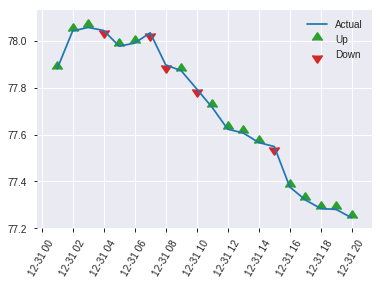


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19130857908600685
RMSE: 0.4373883618547787
LogLoss: 0.5680202451276541
Mean Per-Class Error: 0.2701018174897707
AUC: 0.7827153445195124
pr_auc: 0.7377447858938466
Gini: 0.5654306890390248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37216198444366455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      184  155  0.4572   (155.0/339.0)
1      40   239  0.1434   (40.0/279.0)
Total  224  394  0.3155   (195.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372162     0.710253  249
max f2                       0.124792     0.810731  371
max f0point5                 0.578065     0.716448  129
max accuracy                 0.476659     0.729773  188
max precision                0.95742      1         0
max recall                   0.0797104    1         390
max specificity              0.95742      1         0
max absolute_mcc             0.476659     0.45803   188
max min_per_class_accuracy   0.476659     0.728614  188
max mean_per_class_accuracy  0.476659     0.729898  188

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 44.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.920397           1.89862   1.89862            0.857143         0.942758  0.857143                    0.942758            0.0215054       0.0215054                  89.8618   89.8618
    2        0.0210356                   0.896279           1.84588   1.87428            0.833333         0.906212  0.846154                    0.92589             0.0179211       0.0394265                  84.5878   87.4276
    3        0.0307443                   0.86348            2.21505   1.98189            1                0.879354  0.894737                    0.911194            0.0215054       0.0609319                  121.505   98.189
    4        0.0404531                   0.832148           1.4767    1.86065            0.666667         0.845767  0.84                        0.895492            0.0143369       0.0752688                  47.6703   86.0645
    5        0.0501618                   0.81517            2.21505   1.92924            1                0.82284   0.870968                    0.88143             0.0215054       0.0967742                  121.505   92.924
    6        0.100324                    0.718383           1.78633   1.85779            0.806452         0.767678  0.83871                     0.824554            0.0896057       0.18638                    78.6334   85.7787
    7        0.150485                    0.664311           1.85779   1.85779            0.83871          0.688723  0.83871                     0.779277            0.09319         0.27957                    85.7787   85.7787
    8        0.200647                    0.638726           1.71488   1.82206            0.774194         0.651877  0.822581                    0.747427            0.0860215       0.365591                   71.488    82.206
    9        0.300971                    0.575114           1.57197   1.7387             0.709677         0.600653  0.784946                    0.698502            0.157706        0.523297                   57.1974   73.8698
    10       0.399676                    0.522424           1.05306   1.56937            0.47541          0.54554   0.708502                    0.660726            0.103943        0.62724                    5.30583   56.937
    11       0.5                         0.460395           1.14325   1.48387            0.516129         0.493443  0.669903                    0.627161            0.114695        0.741935                   14.3254   48.3871
    12       0.600324                    0.393204           0.714533  1.3553             0.322581         0.424346  0.61186                     0.593268            0.0716846       0.81362                    -28.5467  35.5302
    13       0.699029                    0.315281           0.726247  1.26648            0.327869         0.359548  0.571759                    0.560266            0.0716846       0.885305                   -27.3753  26.6477
    14       0.799353                    0.228983           0.42872   1.16133            0.193548         0.270774  0.524291                    0.523933            0.0430108       0.928315                   -57.128   16.1334
    15       0.899676                    0.152861           0.357267  1.07167            0.16129          0.188214  0.483813                    0.486497            0.0358423       0.964158                   -64.2733  7.16717
    16       1                           0.047477           0.357267  1                  0.16129          0.107424  0.451456                    0.448467            0

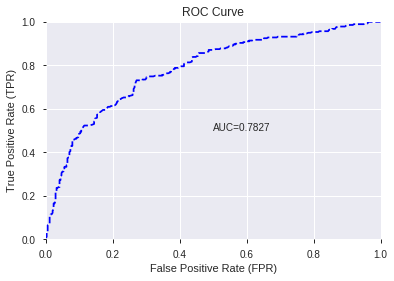

This function is available for GLM models only


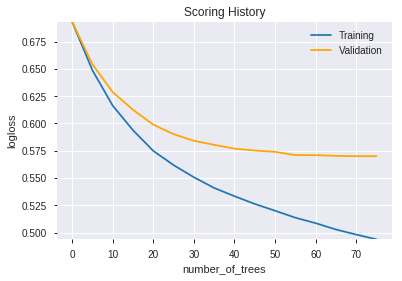

--2019-08-22 13:38:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_133756_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_133756_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'TRANGE',
 'CCI_8',
 'SUB',
 'WILLR_8',
 'MINUS_DM_8',
 'ADOSC',
 'Volume',
 'CCI_12',
 'MOM_12',
 'STOCHRSI_fastd',
 'ULTOSC',
 'MINUS_DI_8',
 'ROC_14',
 'CCI_14',
 'CDLHAMMER',
 'WILLR_14',
 'MOM_14',
 'CCI_20',
 'MOM_20',
 'CCI_24',
 'WILLR_30',
 'STOCH_slowk',
 'ROC_8',
 'MOM_8',
 'MINUS_DI_14',
 'MINUS_DI_12',
 'ROC_12',
 'WILLR_12',
 'CMO_20',
 'MOM_24',
 'ROC_24',
 'CMO_8',
 'ROC_20',
 'CMO_30',
 'WILLR_24',
 'CDLBELTHOLD',
 'CMO_12',
 'CMO_24',
 'CDLTAKURI',
 'STOCHF_fastd',
 'WILLR_20',
 'CDLDRAGONFLYDOJI',
 'CMO_14',
 'ROCP_20',
 'CDLHANGINGMAN',
 'RSI_12',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'RSI_30',
 'CDLENGULFING',
 'RSI_8',
 'RSI_20',
 'ROCP_8',
 'ROCP_14',
 'CDL3OUTSIDE',
 'RSI_24',
 'ROCP_12',
 'ROCR_12',
 'RSI_14',
 'ROCP_24',
 'ROCR_24',
 'ROCR_14',
 'ROCR100_20',
 'ROCR100_24',
 'CDLMARUBOZU']

In [0]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [0]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

55

['BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_8_8_5',
 'BOP',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'MACDFIX_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'ROCP_8',
 'ROCR_8',
 'WILLR_8',
 'aroondown_12',
 'MACDFIX_signal_12',
 'MFI_12',
 'PLUS_DI_12',
 'ROCP_12',
 'WILLR_12',
 'ADXR_14',
 'MFI_14',
 'MINUS_DI_14',
 'MOM_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'RSI_14',
 'ROCR100_20',
 'WILLR_20',
 'MACDFIX_hist_24',
 'PLUS_DI_24',
 'WILLR_24',
 'aroonup_30',
 'MFI_30',
 'WILLR_30',
 'APO',
 'MACD_hist',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'NATR_20',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'VAR_8',
 'CORREL_12',
 'STDDEV_12',
 'LINEARREG_ANGLE_14',
 'CORREL_24',
 'BETA_30']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_134443_model_9  0.764123  0.593879              0.311162  0.447402  0.200168
1  DeepLearning_grid_1_AutoML_20190822_134443_model_3  0.758503  0.610893              0.323374  0.450491  0.202942
2  DeepLearning_grid_1_AutoML_20190822_134443_model_6  0.756563  0.597525              0.329273  0.451271  0.203645
3  DeepLearning_grid_1_AutoML_20190822_134443_model_8  0.754322  0.607039              0.296000  0.454397  0.206477
4  DeepLearning_grid_1_AutoML_20190822_134443_model_5  0.752794  0.598523              0.319377  0.453692  0.205837
5               DeepLearning_1_AutoML_20190822_134443  0.752033  0.611449              0.290449  0.458342  0.210078
6  DeepLearning_grid_1_AutoML_20190822_134443_model_4  0.734635  0.625640              0.367399  0.458805  0.210502
7  DeepLearning_grid_1_AutoML_20190822_134443_model_7  0.727905  0.647389              0.351381  0.466531  0.217652
8  DeepLearning_grid_1_AutoML_20190822_134443_model_2  0.716037  0.640713              0.353078  0.465927  0.217088
9  DeepLearning_grid_1_AutoML_20190822_134443_model_1  0.671345  0.776868              0.402782  0.503498  0.253511

variable  relative_importance  scaled_importance  percentage
0       CDLCLOSINGMARUBOZU             1.000000           1.000000    0.089502
1                      BOP             0.636298           0.636298    0.056950
2                   TRANGE             0.509121           0.509121    0.045567
3                    VAR_8             0.251197           0.251197    0.022483
4                    CCI_8             0.235181           0.235181    0.021049
5                CORREL_12             0.230845           0.230845    0.020661
6                  ADXR_14             0.224145           0.224145    0.020061
7                   ULTOSC             0.221695           0.221695    0.019842
8                     DX_8             0.218913           0.218913    0.019593
9                CORREL_24             0.200186           0.200186    0.017917
10               PLUS_DI_8             0.196725           0.196725    0.017607
11                 BETA_30             0.194740           0.194740    0.017430
12               aroonup_8             0.191359           0.191359    0.017127
13              aroonup_30             0.189769           0.189769    0.016985
14  BBANDS_lowerband_8_5_4             0.189335           0.189335    0.016946
15          STOCHRSI_fastk             0.187275           0.187275    0.016762
16                WILLR_12             0.186840           0.186840    0.016723
17  BBANDS_upperband_8_8_5             0.185011           0.185011    0.016559
18                 NATR_20             0.184902           0.184902    0.016549
19                  MFI_12             0.183548           0.183548    0.016428
20               STDDEV_12             0.181828           0.181828    0.016274
21              AROONOSC_8             0.180798           0.180798    0.016182
22    HT_PHASOR_quadrature             0.179128           0.179128    0.016032
23            MACDEXT_hist             0.178847           0.178847    0.016007
24                  MFI_30             0.176805           0.176805    0.015824
25         MACDFIX_hist_24             0.175862           0.175862    0.015740
26                 WILLR_8             0.174562           0.174562    0.015624
27                  MOM_14             0.172309           0.172309    0.015422
28              MINUS_DM_8             0.171599           0.171599    0.015358
29      LINEARREG_ANGLE_14             0.165963           0.165963    0.014854
30              MINUS_DI_8             0.165613           0.165613    0.014823
31                  MFI_14             0.165117           0.165117    0.014778
32                  BETA_8             0.164297           0.164297    0.014705
33            aroondown_12             0.162816           0.162816    0.014572
34              PLUS_DI_12             0.161871           0.161871    0.014488
35                WILLR_24             0.160068           0.160068    0.014326
36              PLUS_DM_14             0.159889           0.159889    0.014310
37             MINUS_DI_14             0.159164           0.159164    0.014246
38          STOCHRSI_fastd             0.156617           0.156617    0.014018
39              PLUS_DI_14             0.156443           0.156443    0.014002
40                  RSI_14             0.154910           0.154910    0.013865
41       MACDFIX_signal_12             0.154813           0.154813    0.013856
42                WILLR_30             0.153825           0.153825    0.013768
43                     APO             0.153366           0.153366    0.013727
44             STOCH_slowk             0.151797           0.151797    0.013586
45                WILLR_20             0.147391           0.147391    0.013192
46               MACD_hist             0.146509           0.146509    0.013113
47              ROCR100_20             0.145655           0.145655    0.013036
48              PLUS_DI_24             0.145483           0.145483    0.013021
49               MACDFIX_8             0.145131           0.145131  

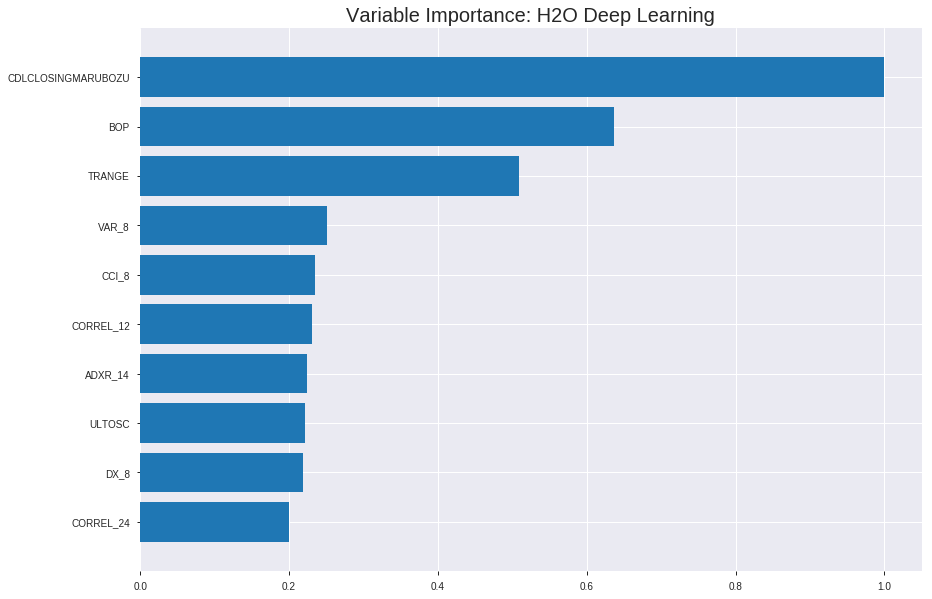

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_134443_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19295297247795648
RMSE: 0.4392641260994989
LogLoss: 0.5667145184687321
Mean Per-Class Error: 0.29749425043175515
AUC: 0.7736898768035669
pr_auc: 0.747633586623842
Gini: 0.5473797536071339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3440073741426393: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1059  1213  0.5339   (1213.0/2272.0)
1      193   1854  0.0943   (193.0/2047.0)
Total  1252  3067  0.3255   (1406.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344007     0.725068  260
max f2                       0.159105     0.831401  345
max f0point5                 0.557487     0.684344  153
max accuracy                 0.516957     0.699236  176
max precision                0.989829     1         0
max recall                   0.0683949    1         386
max specificity              0.989829     1         0
max absolute_mcc             0.451158     0.411952  211
max min_per_class_accuracy   0.525641     0.697183  171
max mean_per_class_accuracy  0.481695     0.702506  198

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.980967           2.06196   2.06196            0.977273         0.983886  0.977273                    0.983886            0.0210064       0.0210064                  106.196   106.196
    2        0.0201436                   0.978004           1.91365   1.98866            0.906977         0.979311  0.942529                    0.981625            0.0190523       0.0400586                  91.3646   98.8657
    3        0.0300996                   0.974994           2.01178   1.99631            0.953488         0.97677   0.946154                    0.980019            0.0200293       0.0600879                  101.178   99.6306
    4        0.0400556                   0.971188           1.96271   1.98796            0.930233         0.973365  0.942197                    0.978365            0.0195408       0.0796287                  96.2713   98.7956
    5        0.0500116                   0.964283           2.01178   1.9927             0.953488         0.968129  0.944444                    0.976327            0.0200293       0.099658                   101.178   99.2699
    6        0.100023                    0.761688           1.7485    1.8706             0.828704         0.806439  0.886574                    0.891383            0.087445        0.187103                   74.8496   87.0598
    7        0.150035                    0.723237           1.5629    1.76803            0.740741         0.740292  0.837963                    0.84102             0.0781632       0.265266                   56.2901   76.8032
    8        0.200046                    0.693671           1.40661   1.67768            0.666667         0.707748  0.795139                    0.807702            0.0703468       0.335613                   40.6611   67.7677
    9        0.300069                    0.636006           1.33335   1.5629             0.631944         0.66485   0.740741                    0.760085            0.133366        0.468979                   33.335    56.2901
    10       0.400093                    0.572818           1.25521   1.48598            0.594907         0.605563  0.704282                    0.721454            0.12555         0.594529                   25.5205   48.5977
    11       0.500116                    0.521821           1.15264   1.41931            0.546296         0.545916  0.672685                    0.686346            0.115291        0.709819                   15.264    41.931
    12       0.599907                    0.452836           1.01824   1.35259            0.482599         0.494514  0.641065                    0.654436            0.101612        0.811431                   1.8243    35.2594
    13       0.699931                    0.351651           0.84006   1.27935            0.398148         0.400858  0.606351                    0.618199            0.0840254       0.895457                   -15.994   27.9351
    14       0.799954                    0.262931           0.483523  1.17984            0.229167         0.305173  0.55919                     0.579059            0.0483635       0.94382                    -51.6477  17.9844
    15       0.899977                    0.158809           0.371189  1.08997            0.175926         0.213653  0.516594                    0.538448            0.0371275       0.980948                   -62.8811  8.997
    16       1                           0.0195009          0.190479  1                  0.0902778        0.102054  0.473952                    0.494799            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19961309348181333
RMSE: 0.44678081145211834
LogLoss: 0.5871425087893946
Mean Per-Class Error: 0.29405808840546177
AUC: 0.7660737203088511
pr_auc: 0.7542120663290393
Gini: 0.5321474406177022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3016201834841069: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      234  362  0.6074   (362.0/596.0)
1      51   587  0.0799   (51.0/638.0)
Total  285  949  0.3347   (413.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.30162      0.739761  291
max f2                       0.149093     0.853196  357
max f0point5                 0.534691     0.723918  165
max accuracy                 0.529589     0.704214  169
max precision                0.982779     1         0
max recall                   0.106953     1         379
max specificity              0.982779     1         0
max absolute_mcc             0.529589     0.413231  169
max min_per_class_accuracy   0.508104     0.696309  184
max mean_per_class_accuracy  0.529589     0.705942  169

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.97836            1.93417   1.93417            1                0.980712  1                           0.980712            0.0203762       0.0203762                  93.4169   93.4169
    2        0.0202593                   0.973958           1.61181   1.77944            0.833333         0.97604   0.92                        0.97847             0.015674        0.0360502                  61.1808   77.9436
    3        0.0299838                   0.97082            1.61181   1.72507            0.833333         0.972679  0.891892                    0.976592            0.015674        0.0517241                  61.1808   72.507
    4        0.0405186                   0.96819            1.48782   1.66339            0.769231         0.969895  0.86                        0.97485             0.015674        0.0673981                  48.7823   66.3386
    5        0.0502431                   0.963367           1.77299   1.6846             0.916667         0.966119  0.870968                    0.97316             0.0172414       0.0846395                  77.2989   68.4599
    6        0.100486                    0.729346           1.49742   1.59101            0.774194         0.795488  0.822581                    0.884324            0.0752351       0.159875                   49.7421   59.101
    7        0.149919                    0.687298           1.55368   1.5787             0.803279         0.705973  0.816216                    0.825516            0.0768025       0.236677                   55.3677   57.87
    8        0.200162                    0.660791           1.55981   1.57396            0.806452         0.674515  0.813765                    0.787613            0.0783699       0.315047                   55.9814   57.396
    9        0.299838                    0.608653           1.3838    1.51074            0.715447         0.635913  0.781081                    0.737183            0.137931        0.452978                   38.3796   51.0743
    10       0.400324                    0.553381           1.32584   1.46433            0.685484         0.579737  0.757085                    0.697662            0.133229        0.586207                   32.5842   46.4331
    11       0.5                         0.510179           1.0693    1.38558            0.552846         0.531754  0.71637                     0.664588            0.106583        0.69279                    6.92968   38.558
    12       0.599676                    0.4392             0.959222  1.31471            0.495935         0.478951  0.67973                     0.633732            0.0956113       0.788401                   -4.07778  31.4712
    13       0.700162                    0.346974           0.733113  1.23124            0.379032         0.396923  0.636574                    0.599746            0.0736677       0.862069                   -26.6887  23.1242
    14       0.799838                    0.2788             0.723348  1.16795            0.373984         0.312933  0.60385                     0.564003            0.0721003       0.934169                   -27.6652  16.7948
    15       0.899514                    0.1906             0.424574  1.08557            0.219512         0.24101   0.561261                    0.528212            0.0423197       0.976489                   -57.5426  8.55743
    16       1                           0.0319549          0.233972  1                  0.120968         0.119104  0.517018                    0.487102            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:56:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:56:21  5 min  5.935 sec  443 obs/sec       0.240333  1             1038       0.606558         1.21579             -0.475657      0.711901        0.663491           1.53449          0.375318                         0.589527           1.14287               -0.391781        0.724657          0.712109             1.48782            0.334684
    2019-08-22 13:56:53  5 min 38.491 sec  531 obs/sec       3.82774   16            16532      0.455453         0.601183            0.167991       0.75136         0.726923           2.06196          0.351007                         0.460729           0.612617              0.149932         0.759068          0.751509             1.6366             0.333874
    2019-08-22 13:57:32  6 min 16.943 sec  637 obs/sec       9.69785   41            41885      0.450372         0.588628            0.186451       0.750427        0.725857           2.01401          0.343598                         0.448988           0.589347              0.192703         0.753345          0.736391             1.6366             0.315235
    2019-08-22 13:58:10  6 min 55.376 sec  712 obs/sec       16.5763   70            71593      0.442842         0.572912            0.21343        0.765236        0.740602           2.06196          0.323455                         0.451353           0.593922              0.184176         0.765382          0.752381             1.78539            0.32577
    2019-08-22 13:58:47  7 min 32.525 sec  771 obs/sec       23.9007   101           103227     0.444253         0.576289            0.208409       0.771614        0.74408            1.96606          0.332021                         0.452325           0.595622              0.18066          0.759937          0.748154             1.93417            0.320908
    2019-08-22 13:59:26  8 min 11.624 sec  822 obs/sec       32.1762   136           138969     0.439264         0.566715            0.226088       0.77369         0.747634           2.06196          0.325538                         0.446781           0.587143              0.200622         0.766074          0.754212             1.93417            0.334684
    2019-08-22 14:00:05  8 min 50.460 sec  863 obs/sec       40.8097   173           176257     0.438838         0.565545            0.227588       0.775944        0.749373           2.06196          0.311878                         0.449747           0.593014              0.189974         0.750839          0.74086              1.78539            0.316045
    2019-08-22 14:00:09  8 min 54.380 sec  863 obs/sec       40.8097   173           176257     0.439264         0.566715            0.226088       0.77369         0.747634           2.06196          0.325538                         0.446781           0.587143              0.200622         0.766074          0.754212             1.93417            0.334684

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.08950221189236086
BOP                 0.6362982392311096     0.6362982392311096   0.0569500998343989
TRANGE              0.509120762348175      0.509120762348175    0.045567434350486664
VAR_8               0.25119683146476746    0.25119683146476746  0.02248267203644928
CCI_8               0.23518097400665283    0.23518097400665283  0.021049217368595257
---                 ---                    ---                  ---
ROCP_12             0.14424918591976166    0.14424918591976166  0.012910621203491065
STOCHF_fastd        0.14121493697166443    0.14121493697166443  0.012639049211204295
ROCR_8              0.1367338001728058     0.1367338001728058   0.012237977555914192
ROCP_8              0.1330050826072693     0.1330050826072693   0.011904249086276776
LINEARREG_ANGLE_8   0.13214293122291565    0.13214293122291565  0.011827084630391066


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7200647249190939)

('F1', 0.6951219512195121)

('auc', 0.7641228153646081)

('logloss', 0.5938788213059277)

('mean_per_class_error', 0.28529514384495824)

('rmse', 0.44740172845177667)

('mse', 0.20016830662163732)

deeplearning prediction progress: |███████████████████████████████████████| 100%


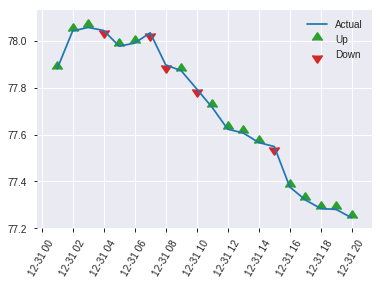


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20016830662163732
RMSE: 0.44740172845177667
LogLoss: 0.5938788213059277
Mean Per-Class Error: 0.28529514384495824
AUC: 0.7641228153646081
pr_auc: 0.7179698127922384
Gini: 0.5282456307292163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38361349123239924: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      190  149  0.4395   (149.0/339.0)
1      51   228  0.1828   (51.0/279.0)
Total  241  377  0.3236   (200.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383613     0.695122  237
max f2                       0.109229     0.81089   377
max f0point5                 0.532068     0.696414  146
max accuracy                 0.517578     0.720065  160
max precision                0.983452     1         0
max recall                   0.0845474    1         388
max specificity              0.983452     1         0
max absolute_mcc             0.517578     0.432412  160
max min_per_class_accuracy   0.486895     0.696165  180
max mean_per_class_accuracy  0.517578     0.714705  160

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.976237           2.21505   2.21505            1                0.978233  1                           0.978233            0.0250896       0.0250896                  121.505   121.505
    2        0.0210356                   0.971382           2.21505   2.21505            1                0.973244  1                           0.97593             0.0215054       0.046595                   121.505   121.505
    3        0.0307443                   0.96699            1.10753   1.86531            0.5              0.968537  0.842105                    0.973595            0.0107527       0.0573477                  10.7527   86.5308
    4        0.0404531                   0.957117           1.4767    1.77204            0.666667         0.963908  0.8                         0.971271            0.0143369       0.0716846                  47.6703   77.2043
    5        0.0501618                   0.794178           1.84588   1.78633            0.833333         0.929173  0.806452                    0.963123            0.0179211       0.0896057                  84.5878   78.6334
    6        0.100324                    0.704655           1.92924   1.85779            0.870968         0.743996  0.83871                     0.85356             0.0967742       0.18638                    92.924    85.7787
    7        0.150485                    0.67193            1.64343   1.78633            0.741935         0.683948  0.806452                    0.797022            0.0824373       0.268817                   64.3427   78.6334
    8        0.200647                    0.634146           1.50052   1.71488            0.677419         0.65168   0.774194                    0.760687            0.0752688       0.344086                   50.052    71.488
    9        0.300971                    0.559354           1.6077    1.67915            0.725806         0.595407  0.758065                    0.705594            0.16129         0.505376                   60.77     67.9154
    10       0.399676                    0.522343           1.19831   1.5604             0.540984         0.539957  0.704453                    0.664687            0.11828         0.623656                   19.8308   56.0402
    11       0.5                         0.472475           0.928894  1.43369            0.419355         0.502753  0.647249                    0.632196            0.09319         0.716846                   -7.11065  43.3692
    12       0.600324                    0.39479            0.893167  1.34336            0.403226         0.437909  0.606469                    0.599727            0.0896057       0.806452                   -10.6833  34.3361
    13       0.699029                    0.3281             0.653622  1.24597            0.295082         0.357156  0.5625                      0.565475            0.0645161       0.870968                   -34.6378  24.5968
    14       0.799353                    0.26289            0.5359    1.15685            0.241935         0.295896  0.522267                    0.531641            0.0537634       0.924731                   -46.41    15.685
    15       0.899676                    0.156681           0.42872   1.07566            0.193548         0.217653  0.485612                    0.496628            0.0430108       0.967742                   -57.128   7.56556
    16       1                           0.0353501          0.32154   1                  0.145161         0.10868   0.451456                    0.457708           

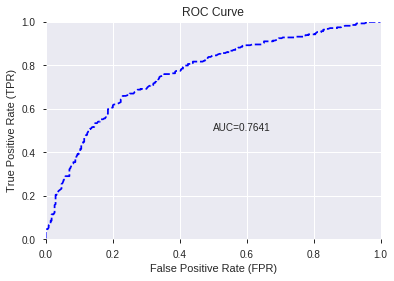

This function is available for GLM models only


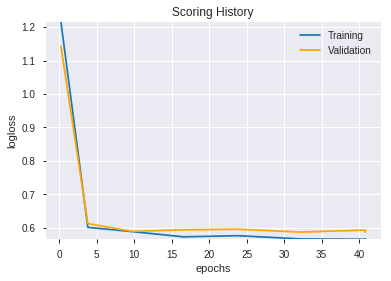

--2019-08-22 14:00:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_134443_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_134443_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'TRANGE',
 'VAR_8',
 'CCI_8',
 'CORREL_12',
 'ADXR_14',
 'ULTOSC',
 'DX_8',
 'CORREL_24',
 'PLUS_DI_8',
 'BETA_30',
 'aroonup_8',
 'aroonup_30',
 'BBANDS_lowerband_8_5_4',
 'STOCHRSI_fastk',
 'WILLR_12',
 'BBANDS_upperband_8_8_5',
 'NATR_20',
 'MFI_12',
 'STDDEV_12',
 'AROONOSC_8',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'MFI_30',
 'MACDFIX_hist_24',
 'WILLR_8',
 'MOM_14',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_14',
 'MINUS_DI_8',
 'MFI_14',
 'BETA_8',
 'aroondown_12',
 'PLUS_DI_12',
 'WILLR_24',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'STOCHRSI_fastd',
 'PLUS_DI_14',
 'RSI_14',
 'MACDFIX_signal_12',
 'WILLR_30',
 'APO',
 'STOCH_slowk',
 'WILLR_20',
 'MACD_hist',
 'ROCR100_20',
 'PLUS_DI_24',
 'MACDFIX_8',
 'ROCP_12',
 'STOCHF_fastd',
 'ROCR_8',
 'ROCP_8',
 'LINEARREG_ANGLE_8']

In [0]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_140122_model_1  0.76583  0.580879               0.29516  0.443321  0.196533

variable  relative_importance  scaled_importance  percentage
0                      BOP             0.691946           1.000000    0.102539
1                   TRANGE             0.478839           0.692018    0.070959
2                   RSI_14             0.355607           0.513923    0.052697
3                PLUS_DI_8             0.346128           0.500224    0.051293
4                   ULTOSC             0.280235           0.404995    0.041528
5       CDLCLOSINGMARUBOZU             0.279337           0.403697    0.041395
6                    CCI_8             0.263806           0.381253    0.039093
7                  WILLR_8             0.227539           0.328840    0.033719
8                 WILLR_12             0.220612           0.318828    0.032693
9                 WILLR_30             0.217221           0.313928    0.032190
10      LINEARREG_ANGLE_14             0.199812           0.288768    0.029610
11       LINEARREG_ANGLE_8             0.192939           0.278835    0.028592
12              ROCR100_20             0.192849           0.278706    0.028578
13              MINUS_DI_8             0.185072           0.267467    0.027426
14                  MOM_14             0.171302           0.247566    0.025385
15               MACDFIX_8             0.164282           0.237421    0.024345
16              MINUS_DM_8             0.161640           0.233602    0.023953
17             MINUS_DI_14             0.152152           0.219890    0.022547
18                WILLR_24             0.151831           0.219426    0.022500
19       MACDFIX_signal_12             0.149421           0.215943    0.022143
20          STOCHRSI_fastd             0.126466           0.182768    0.018741
21                     APO             0.120985           0.174848    0.017929
22          STOCHRSI_fastk             0.114851           0.165983    0.017020
23              AROONOSC_8             0.101815           0.147143    0.015088
24            aroondown_12             0.097342           0.140679    0.014425
25               CORREL_12             0.093391           0.134969    0.013840
26                 ADXR_14             0.083143           0.120158    0.012321
27                  MFI_12             0.076990           0.111266    0.011409
28                  MFI_30             0.076060           0.109922    0.011271
29              PLUS_DI_24             0.071523           0.103365    0.010599
30  BBANDS_lowerband_8_5_4             0.070296           0.101591    0.010417
31              PLUS_DM_14             0.056362           0.081454    0.008352
32             STOCH_slowk             0.049835           0.072021    0.007385
33            STOCHF_fastd             0.049696           0.071820    0.007364
34                    DX_8             0.048903           0.070675    0.007247
35               MACD_hist             0.047996           0.069363    0.007112
36              PLUS_DI_14             0.047267           0.068311    0.007005
37                   VAR_8             0.047245           0.068279    0.007001
38         MACDFIX_hist_24             0.040367           0.058338    0.005982
39               aroonup_8             0.039786           0.057498    0.005896
40                  MFI_14             0.033529           0.048456    0.004969
41                WILLR_20             0.028589           0.041316    0.004237
42  BBANDS_upperband_8_8_5             0.027824           0.040211    0.004123
43                 ROCP_12             0.025270           0.036521    0.003745
44               STDDEV_12             0.020835           0.030111    0.003088
45                 NATR_20             0.019245           0.027813    0.002852
46               CORREL_24             0.012171           0.017590    0.001804
47              aroonup_30             0.008394           0.012131    0.001244
48            MACDEXT_hist             0.007257           0.010488    0.001075
49    HT_PHASOR_quadrature             0.006572           0.009498  

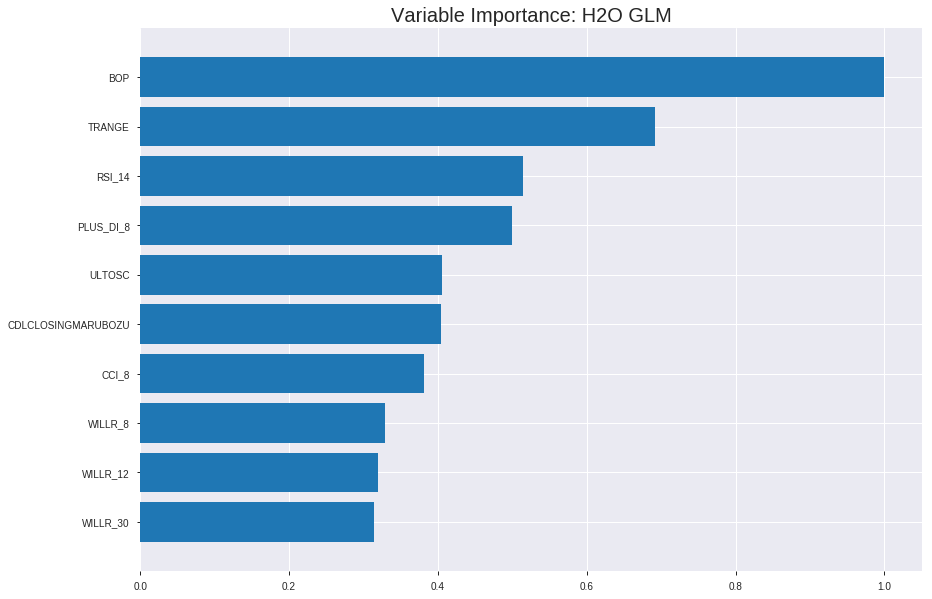

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_140122_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1961324558000553
RMSE: 0.44286844073613474
LogLoss: 0.573413301495596
Null degrees of freedom: 4318
Residual degrees of freedom: 4263
Null deviance: 5975.678574739547
Residual deviance: 4953.144098318959
AIC: 5065.144098318959
AUC: 0.7655136209292884
pr_auc: 0.7376667907137227
Gini: 0.5310272418585769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35503755521557034: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1102  1170  0.515    (1170.0/2272.0)
1      251   1796  0.1226   (251.0/2047.0)
Total  1353  2966  0.329    (1421.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355038     0.716537  256
max f2                       0.144394     0.831819  348
max f0point5                 0.537598     0.682909  169
max accuracy                 0.478923     0.698078  196
max precision                0.96185      1         0
max recall                   0.049327     1         385
max specificity              0.96185      1         0
max absolute_mcc             0.478923     0.39852   196
max min_per_class_accuracy   0.494133     0.695652  188
max mean_per_class_accuracy  0.478923     0.699434  196

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.906394           2.06196   2.06196            0.977273         0.921941   0.977273                    0.921941            0.0210064       0.0210064                  106.196   106.196
    2        0.0201436                   0.887298           1.96271   2.01291            0.930233         0.895837   0.954023                    0.909039            0.0195408       0.0405471                  96.2713   101.291
    3        0.0300996                   0.869268           2.01178   2.01254            0.953488         0.877661   0.953846                    0.89866             0.0200293       0.0605765                  101.178   101.254
    4        0.0400556                   0.850168           1.76644   1.95137            0.837209         0.860992   0.924855                    0.889298            0.0175867       0.0781632                  76.6442   95.1368
    5        0.0500116                   0.83292            1.81551   1.92432            0.860465         0.84034    0.912037                    0.879551            0.0180752       0.0962384                  81.551    92.4322
    6        0.100023                    0.757705           1.7485    1.83641            0.828704         0.788799   0.87037                     0.834175            0.087445        0.183683                   74.8496   83.6409
    7        0.150035                    0.7182             1.48476   1.71919            0.703704         0.736429   0.814815                    0.801593            0.074255        0.257938                   48.4756   71.9192
    8        0.200046                    0.683676           1.52383   1.67035            0.722222         0.700222   0.791667                    0.776251            0.0762091       0.334148                   52.3829   67.0351
    9        0.300069                    0.619687           1.28939   1.54337            0.611111         0.652637   0.731481                    0.735046            0.128969        0.463117                   28.9394   54.3365
    10       0.400093                    0.552903           1.29428   1.48109            0.613426         0.586546   0.701968                    0.697921            0.129458        0.592574                   29.4278   48.1093
    11       0.500116                    0.487246           1.14776   1.41443            0.543981         0.51983    0.67037                     0.662303            0.114802        0.707377                   14.7756   41.4426
    12       0.599907                    0.42022            0.939917  1.33549            0.445476         0.454014   0.63296                     0.627655            0.0937958       0.801172                   -6.00834  33.5494
    13       0.699931                    0.343971           0.830291  1.2633             0.393519         0.382424   0.598743                    0.59261             0.0830484       0.884221                   -16.9709  26.3298
    14       0.799954                    0.253199           0.561668  1.17557            0.266204         0.29784    0.557164                    0.555754            0.0561798       0.940401                   -43.8332  17.5569
    15       0.899977                    0.153398           0.395609  1.08888            0.1875           0.205289   0.516079                    0.516803            0.0395701       0.979971                   -60.4391  8.88843
    16       1                           0.00745378         0.200247  1                  0.0949074        0.0883954  0.473952                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19800015950882888
RMSE: 0.4449720884604212
LogLoss: 0.5793116558673822
Null degrees of freedom: 1233
Residual degrees of freedom: 1178
Null deviance: 1718.4207619926892
Residual deviance: 1429.7411666806993
AIC: 1541.7411666806993
AUC: 0.7714044518314364
pr_auc: 0.7593538089536181
Gini: 0.5428089036628727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41692276038044906: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      379  217  0.3641   (217.0/596.0)
1      133  505  0.2085   (133.0/638.0)
Total  512  722  0.2836   (350.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416923     0.742647  232
max f2                       0.12708      0.855477  359
max f0point5                 0.495251     0.722912  187
max accuracy                 0.416923     0.71637   232
max precision                0.94179      1         0
max recall                   0.0584541    1         385
max specificity              0.94179      1         0
max absolute_mcc             0.416923     0.433518  232
max min_per_class_accuracy   0.466937     0.701342  204
max mean_per_class_accuracy  0.416923     0.713721  232

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 46.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.907034           1.93417   1.93417            1                0.921055   1                           0.921055            0.0203762       0.0203762                  93.4169   93.4169
    2        0.0202593                   0.884486           1.45063   1.70207            0.75             0.895072   0.88                        0.908583            0.0141066       0.0344828                  45.0627   70.2069
    3        0.0299838                   0.870181           1.28945   1.56825            0.666667         0.877241   0.810811                    0.898418            0.0125392       0.0470219                  28.9446   56.8245
    4        0.0405186                   0.844277           1.93417   1.66339            1                0.855685   0.86                        0.887308            0.0203762       0.0673981                  93.4169   66.3386
    5        0.0502431                   0.82169            1.77299   1.6846             0.916667         0.833841   0.870968                    0.876959            0.0172414       0.0846395                  77.2989   68.4599
    6        0.100486                    0.74032            1.52862   1.60661            0.790323         0.774964   0.830645                    0.825962            0.0768025       0.161442                   52.8618   60.6608
    7        0.149919                    0.692675           1.6488    1.62052            0.852459         0.714901   0.837838                    0.789342            0.0815047       0.242947                   64.88     62.052
    8        0.200162                    0.66134            1.43503   1.57396            0.741935         0.676885   0.813765                    0.761114            0.0721003       0.315047                   43.5029   57.396
    9        0.299838                    0.604608           1.43097   1.52643            0.739837         0.633456   0.789189                    0.718676            0.142633        0.45768                    43.0971   52.6425
    10       0.400324                    0.538131           1.26345   1.46042            0.653226         0.572244   0.755061                    0.68192             0.126959        0.584639                   26.3449   46.0415
    11       0.5                         0.471229           1.08502   1.38558            0.560976         0.501581   0.71637                     0.645969            0.10815         0.69279                    8.50218   38.558
    12       0.599676                    0.396947           1.0693    1.33301            0.552846         0.438911   0.689189                    0.611553            0.106583        0.799373                   6.92968   33.3009
    13       0.700162                    0.328391           0.686318  1.2402             0.354839         0.365625   0.641204                    0.576258            0.0689655       0.868339                   -31.3682  24.0197
    14       0.799838                    0.25179            0.691898  1.17187            0.357724         0.289541   0.605876                    0.540527            0.0689655       0.937304                   -30.8102  17.1868
    15       0.899514                    0.149076           0.408849  1.08732            0.211382         0.202274   0.562162                    0.503045            0.0407524       0.978056                   -59.1151  8.73168
    16       1                           0.0112279          0.218374  1                  0.112903         0.0873525  0.517018                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 14:01:22  0.000 sec   2            .2E2      56            1.3707448192128637  1.3790779291654638
     2019-08-22 14:01:22  0.056 sec   4            .12E2     56            1.364346444994866   1.372414312310321
     2019-08-22 14:01:22  0.094 sec   6            .76E1     56            1.355368198845981   1.3631162065109101
     2019-08-22 14:01:22  0.129 sec   8            .47E1     56            1.3431481379140695  1.3505552359398842
     2019-08-22 14:01:22  0.163 sec   10           .29E1     56            1.3270731232248338  1.3341400503243304
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 14:01:23  0.715 sec   40           .23E-2    56            1.1456800899883688  1.1587920830211742
     2019-08-22 14:01:23  0.750 sec   42           .14E-2    56            1.1447497888881015  1.1590292612329043
     2019-08-22 14:01:23  0.770 sec   43           .9E-3     56            1.144172621237479   1.1591616440153647
     2019-08-22 14:01:23  0.790 sec   44           .56E-3    56            1.1437644679650658  1.1595991348125423
     2019-08-22 14:01:23  0.810 sec   45           .35E-3    56            1.1435064459517543  1.1599721789831061


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7135922330097088)

('F1', 0.6998394863563403)

('auc', 0.7658303464755079)

('logloss', 0.5808788388449876)

('mean_per_class_error', 0.29106797348304636)

('rmse', 0.4433206963860426)

('mse', 0.1965332398442058)

glm prediction progress: |████████████████████████████████████████████████| 100%


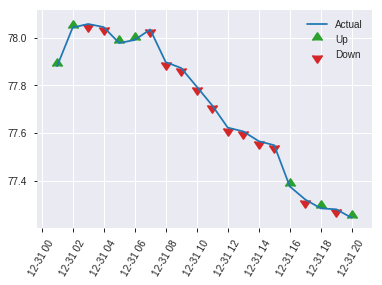


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1965332398442058
RMSE: 0.4433206963860426
LogLoss: 0.5808788388449876
Null degrees of freedom: 617
Residual degrees of freedom: 562
Null deviance: 852.1522922482045
Residual deviance: 717.9662448124046
AIC: 829.9662448124046
AUC: 0.7658303464755079
pr_auc: 0.7223858758889657
Gini: 0.5316606929510157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3775875123414907: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      213  126  0.3717   (126.0/339.0)
1      61   218  0.2186   (61.0/279.0)
Total  274  344  0.3026   (187.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377588     0.699839  230
max f2                       0.18452      0.812385  335
max f0point5                 0.49162      0.688434  169
max accuracy                 0.49162      0.713592  169
max precision                0.924918     1         0
max recall                   0.0472917    1         388
max specificity              0.924918     1         0
max absolute_mcc             0.487869     0.418398  172
max min_per_class_accuracy   0.441773     0.705015  200
max mean_per_class_accuracy  0.427908     0.708932  208

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 42.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.889706           2.21505   2.21505            1                0.903123   1                           0.903123            0.0250896       0.0250896                  121.505   121.505
    2        0.0210356                   0.859499           1.4767    1.87428            0.666667         0.869843   0.846154                    0.887763            0.0143369       0.0394265                  47.6703   87.4276
    3        0.0307443                   0.831086           2.21505   1.98189            1                0.841477   0.894737                    0.873146            0.0215054       0.0609319                  121.505   98.189
    4        0.0404531                   0.812301           1.4767    1.86065            0.666667         0.822594   0.84                        0.861014            0.0143369       0.0752688                  47.6703   86.0645
    5        0.0501618                   0.786643           2.21505   1.92924            1                0.797821   0.870968                    0.848783            0.0215054       0.0967742                  121.505   92.924
    6        0.100324                    0.721815           1.78633   1.85779            0.806452         0.750133   0.83871                     0.799458            0.0896057       0.18638                    78.6334   85.7787
    7        0.150485                    0.672619           1.71488   1.81015            0.774194         0.694806   0.817204                    0.764574            0.0860215       0.272401                   71.488    81.0151
    8        0.200647                    0.63823            1.57197   1.75061            0.709677         0.655654   0.790323                    0.737344            0.078853        0.351254                   57.1974   75.0607
    9        0.300971                    0.560634           1.42907   1.64343            0.645161         0.598885   0.741935                    0.691191            0.143369        0.494624                   42.9067   64.3427
    10       0.399676                    0.492058           1.30724   1.5604             0.590164         0.524558   0.704453                    0.650039            0.129032        0.623656                   30.7245   56.0402
    11       0.5                         0.426842           1.03607   1.4552             0.467742         0.459719   0.656958                    0.611851            0.103943        0.727599                   3.60735   45.5197
    12       0.600324                    0.344961           0.85744   1.3553             0.387097         0.38352    0.61186                     0.573694            0.0860215       0.81362                    -14.256   35.5302
    13       0.699029                    0.280125           0.544685  1.24084            0.245902         0.311635   0.560185                    0.53669             0.0537634       0.867384                   -45.5315  24.084
    14       0.799353                    0.210872           0.571627  1.15685            0.258065         0.246817   0.522267                    0.500309            0.0573477       0.924731                   -42.8373  15.685
    15       0.899676                    0.113267           0.357267  1.06769            0.16129          0.165979   0.482014                    0.463028            0.0358423       0.960573                   -64.2733  6.76878
    16       1                           0.00586226         0.392993  1                  0.177419         0.0668428  0.451456                    0.4

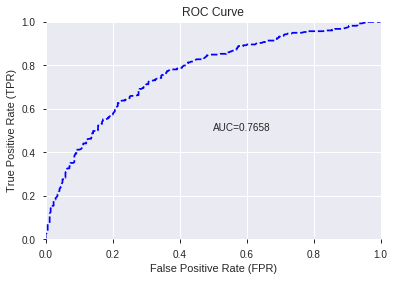

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


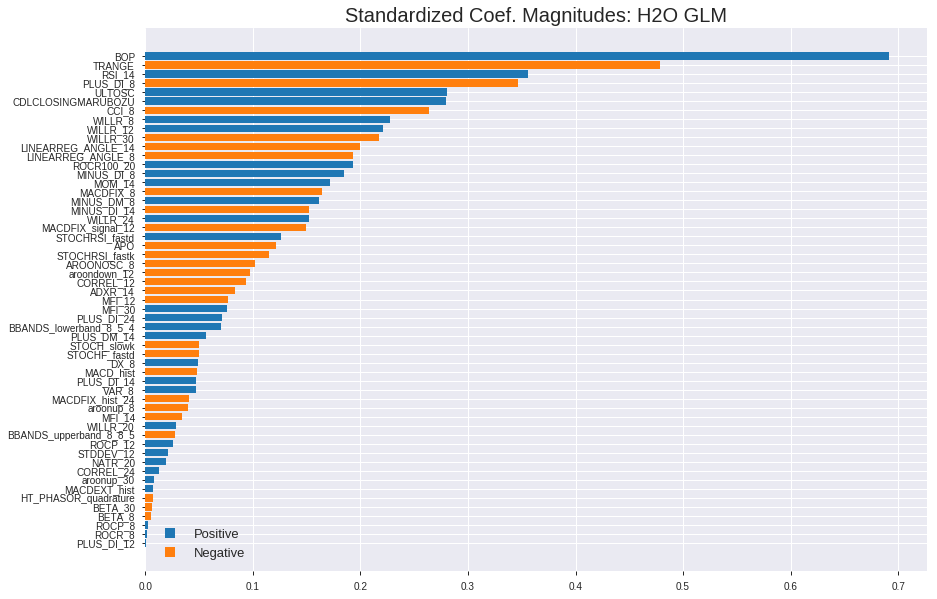

'log_likelihood'
--2019-08-22 14:01:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_140122_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_140122_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'RSI_14',
 'PLUS_DI_8',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'WILLR_8',
 'WILLR_12',
 'WILLR_30',
 'LINEARREG_ANGLE_14',
 'LINEARREG_ANGLE_8',
 'ROCR100_20',
 'MINUS_DI_8',
 'MOM_14',
 'MACDFIX_8',
 'MINUS_DM_8',
 'MINUS_DI_14',
 'WILLR_24',
 'MACDFIX_signal_12',
 'STOCHRSI_fastd',
 'APO',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroondown_12',
 'CORREL_12',
 'ADXR_14',
 'MFI_12',
 'MFI_30',
 'PLUS_DI_24',
 'BBANDS_lowerband_8_5_4',
 'PLUS_DM_14',
 'STOCH_slowk',
 'STOCHF_fastd',
 'DX_8',
 'MACD_hist',
 'PLUS_DI_14',
 'VAR_8',
 'MACDFIX_hist_24',
 'aroonup_8',
 'MFI_14',
 'WILLR_20',
 'BBANDS_upperband_8_8_5',
 'ROCP_12',
 'STDDEV_12',
 'NATR_20',
 'CORREL_24',
 'aroonup_30',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'BETA_8',
 'ROCP_8',
 'ROCR_8',
 'PLUS_DI_12']

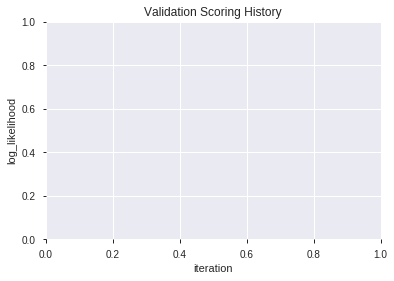

In [0]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_140232_model_6  0.772364  0.580743              0.290624  0.443715  0.196883
1  XGBoost_grid_1_AutoML_20190822_140232_model_4  0.770969  0.577518              0.296413  0.442733  0.196012
2  XGBoost_grid_1_AutoML_20190822_140232_model_3  0.770488  0.578161              0.310305  0.442835  0.196103
3  XGBoost_grid_1_AutoML_20190822_140232_model_2  0.769404  0.581256              0.304406  0.443995  0.197132
4               XGBoost_3_AutoML_20190822_140232  0.768870  0.580770              0.294731  0.444201  0.197314
5               XGBoost_1_AutoML_20190822_140232  0.766666  0.580503              0.291782  0.443546  0.196733
6               XGBoost_2_AutoML_20190822_140232  0.760433  0.584799              0.310305  0.446160  0.199058
7  XGBoost_grid_1_AutoML_20190822_140232_model_1  0.756214  0.591811              0.293574  0.449201  0.201781
8  XGBoost_grid_1_AutoML_20190822_140232_model_7  0.750103  0.589373              0.326323  0.449115  0.201704
9  XGBoost_grid_1_AutoML_20190822_140232_model_5  0.748713  0.596040              0.339693  0.451017  0.203416

variable  relative_importance  scaled_importance  percentage
0                      BOP          4708.853516           1.000000    0.271422
1                   TRANGE          1313.625732           0.278969    0.075719
2       CDLCLOSINGMARUBOZU           708.511658           0.150464    0.040839
3                  WILLR_8           497.965729           0.105751    0.028703
4                    CCI_8           401.775055           0.085323    0.023159
5                CORREL_12           373.106537           0.079235    0.021506
6     HT_PHASOR_quadrature           366.402252           0.077811    0.021120
7                PLUS_DI_8           356.252228           0.075656    0.020535
8                  ADXR_14           347.047058           0.073701    0.020004
9                  BETA_30           346.727539           0.073633    0.019986
10      LINEARREG_ANGLE_14           337.152039           0.071600    0.019434
11              MINUS_DI_8           305.932098           0.064970    0.017634
12                   VAR_8           297.452881           0.063169    0.017145
13                  ULTOSC           267.684387           0.056847    0.015430
14                WILLR_12           266.330688           0.056560    0.015352
15                  ROCP_8           262.841461           0.055819    0.015150
16                 NATR_20           255.516998           0.054263    0.014728
17                  MOM_14           255.454529           0.054250    0.014725
18  BBANDS_upperband_8_8_5           253.420593           0.053818    0.014607
19                  BETA_8           251.909286           0.053497    0.014520
20            MACDEXT_hist           238.937546           0.050742    0.013773
21          STOCHRSI_fastk           226.874359           0.048180    0.013077
22                  MFI_12           226.625580           0.048128    0.013063
23               CORREL_24           223.262146           0.047413    0.012869
24              MINUS_DM_8           215.958405           0.045862    0.012448
25                  MFI_14           213.318069           0.045301    0.012296
26                  MFI_30           213.211426           0.045279    0.012290
27       LINEARREG_ANGLE_8           209.613846           0.044515    0.012082
28       MACDFIX_signal_12           197.631500           0.041970    0.011392
29  BBANDS_lowerband_8_5_4           194.968719           0.041405    0.011238
30              AROONOSC_8           187.773071           0.039877    0.010823
31              PLUS_DM_14           185.281509           0.039347    0.010680
32         MACDFIX_hist_24           182.365265           0.038728    0.010512
33               STDDEV_12           174.157364           0.036985    0.010039
34          STOCHRSI_fastd           171.539474           0.036429    0.009888
35               MACDFIX_8           169.506073           0.035997    0.009770
36                WILLR_24           167.881714           0.035652    0.009677
37             MINUS_DI_14           159.825882           0.033942    0.009213
38               aroonup_8           151.659210           0.032207    0.008742
39             STOCH_slowk           151.417297           0.032156    0.008728
40               MACD_hist           148.291534           0.031492    0.008548
41              aroonup_30           133.729431           0.028400    0.007708
42                 ROCP_12           117.198578           0.024889    0.006755
43                    DX_8           113.523361           0.024108    0.006544
44              ROCR100_20           110.528297           0.023472    0.006371
45              PLUS_DI_24           108.465515           0.023034    0.006252
46                WILLR_20           106.993805           0.022722    0.006167
47                     APO            96.508484           0.020495    0.005563
48              PLUS_DI_12            91.990105           0.019536    0.005302
49                WILLR_30            70.775871           0.015030  

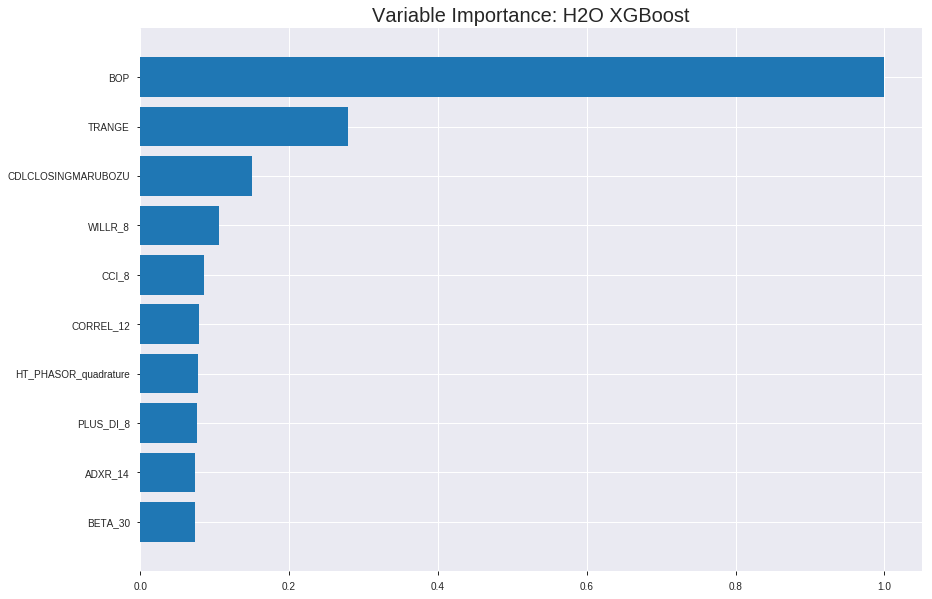

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_140232_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15897697816891523
RMSE: 0.39871917206088203
LogLoss: 0.48713740249834975
Mean Per-Class Error: 0.21588704184068752
AUC: 0.8726157783289872
pr_auc: 0.8651182076557677
Gini: 0.7452315566579744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48918357491493225: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1658  614   0.2702   (614.0/2272.0)
1      352   1695  0.172    (352.0/2047.0)
Total  2010  2309  0.2237   (966.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489184     0.778237  207
max f2                       0.300606     0.868287  290
max f0point5                 0.569579     0.794004  161
max accuracy                 0.546908     0.785367  175
max precision                0.956222     1         0
max recall                   0.137241     1         362
max specificity              0.956222     1         0
max absolute_mcc             0.546908     0.57059   175
max min_per_class_accuracy   0.515409     0.78125   193
max mean_per_class_accuracy  0.52365      0.784113  188

Gains/Lift Table: Avg response rate: 47.40 %, avg score: 47.40 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.919759           2.10992     2.10992            1                0.935072  1                           0.935072            0.0214949       0.0214949                  110.992   110.992
    2        0.0201436                   0.904414           2.10992     2.10992            1                0.911292  1                           0.923319            0.0210064       0.0425012                  110.992   110.992
    3        0.0300996                   0.886678           2.10992     2.10992            1                0.896817  1                           0.914553            0.0210064       0.0635076                  110.992   110.992
    4        0.0400556                   0.867485           2.10992     2.10992            1                0.879244  1                           0.905777            0.0210064       0.0845139                  110.992   110.992
    5        0.0500116                   0.847416           2.10992     2.10992            1                0.857219  1                           0.89611             0.0210064       0.10552                    110.992   110.992
    6        0.100023                    0.737981           2.022       2.06596            0.958333         0.783008  0.979167                    0.839559            0.101124        0.206644                   102.2     106.596
    7        0.150035                    0.688278           1.95363     2.02852            0.925926         0.711852  0.96142                     0.79699             0.097704        0.304348                   95.3627   102.852
    8        0.200046                    0.652179           1.81687     1.97561            0.861111         0.669528  0.936343                    0.765125            0.0908647       0.395213                   81.6873   97.5605
    9        0.300069                    0.603445           1.61663     1.85595            0.766204         0.627493  0.87963                     0.719247            0.1617          0.556913                   61.6626   85.5945
    10       0.400093                    0.556369           1.33823     1.72652            0.634259         0.579995  0.818287                    0.684434            0.133854        0.690767                   33.8234   72.6518
    11       0.500116                    0.507802           1.06473     1.59416            0.50463          0.531423  0.755556                    0.653832            0.106497        0.797264                   6.47266   59.4159
    12       0.599907                    0.449967           0.783264    1.45927            0.37123          0.480248  0.691625                    0.624957            0.0781632       0.875427                   -21.6736  45.9271
    13       0.699931                    0.352142           0.678885    1.34775            0.321759         0.404175  0.638769                    0.593406            0.0679043       0.943332                   -32.1115  34.775
    14       0.799954                    0.236689           0.385841    1.22748            0.18287          0.291941  0.581766                    0.555712            0.0385931       0.981925                   -61.4159  22.7477
    15       0.899977                    0.146076           0.170942    1.11005            0.0810185        0.189032  0.526113                    0.51496             0.0170982       0.999023                   -82.9058  11.0054
    16       1                           0.0456805          0.00976813  1                  0.00462963       0.105359  0.473952  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.197835501280445
RMSE: 0.44478702912792434
LogLoss: 0.5784400926946003
Mean Per-Class Error: 0.29345322000378693
AUC: 0.7690507247901369
pr_auc: 0.7601934735842195
Gini: 0.5381014495802738
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3459453384081523: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      282  314  0.5268   (314.0/596.0)
1      71   567  0.1113   (71.0/638.0)
Total  353  881  0.312    (385.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345945     0.746544  273
max f2                       0.187544     0.858642  340
max f0point5                 0.491351     0.713838  200
max accuracy                 0.469623     0.708266  212
max precision                0.95015      1         0
max recall                   0.112404     1         381
max specificity              0.95015      1         0
max absolute_mcc             0.469623     0.415615  212
max min_per_class_accuracy   0.500275     0.697987  195
max mean_per_class_accuracy  0.469623     0.706547  212

Gains/Lift Table: Avg response rate: 51.70 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.919031           1.93417   1.93417            1                0.931976  1                           0.931976            0.0203762       0.0203762                  93.4169   93.4169
    2        0.0202593                   0.90009            1.61181   1.77944            0.833333         0.91084   0.92                        0.921831            0.015674        0.0360502                  61.1808   77.9436
    3        0.0299838                   0.88618            1.77299   1.77734            0.916667         0.894143  0.918919                    0.912851            0.0172414       0.0532915                  77.2989   77.7345
    4        0.0405186                   0.861049           1.48782   1.70207            0.769231         0.872801  0.88                        0.902438            0.015674        0.0689655                  48.7823   70.2069
    5        0.0502431                   0.834529           1.77299   1.7158             0.916667         0.846202  0.887097                    0.891554            0.0172414       0.0862069                  77.2989   71.5795
    6        0.100486                    0.735477           1.6534    1.6846             0.854839         0.77858   0.870968                    0.835067            0.0830721       0.169279                   65.3403   68.4599
    7        0.149919                    0.670254           1.52197   1.63098            0.786885         0.700102  0.843243                    0.790565            0.0752351       0.244514                   52.1969   63.0975
    8        0.200162                    0.641811           1.27905   1.54264            0.66129          0.655795  0.797571                    0.756736            0.0642633       0.308777                   27.9047   54.2637
    9        0.299838                    0.587147           1.43097   1.50552            0.739837         0.614887  0.778378                    0.709581            0.142633        0.451411                   43.0971   50.5516
    10       0.400324                    0.54948            1.32584   1.46042            0.685484         0.568411  0.755061                    0.674146            0.133229        0.584639                   32.5842   46.0415
    11       0.5                         0.502934           1.05357   1.37931            0.544715         0.526877  0.713128                    0.644787            0.105016        0.689655                   5.35719   37.931
    12       0.599676                    0.444617           0.974947  1.3121             0.504065         0.473316  0.678378                    0.616286            0.0971787       0.786834                   -2.50529  31.2099
    13       0.700162                    0.361894           0.889094  1.25139            0.459677         0.406897  0.646991                    0.586235            0.0893417       0.876176                   -11.0906  25.139
    14       0.799838                    0.246486           0.613273  1.17187            0.317073         0.305337  0.605876                    0.551229            0.0611285       0.937304                   -38.6727  17.1868
    15       0.899514                    0.163834           0.440299  1.0908             0.227642         0.201362  0.563964                    0.51246             0.0438871       0.981191                   -55.9701  9.08018
    16       1                           0.0481027          0.187178  1                  0.0967742        0.127157  0.517018                    0.473742           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 14:03:03  20.487 sec  0                  0.5              0.693147            0.5             0                  1                0.526048                         0.5                0.693147              0.5               0                    1                  0.482982
    2019-08-22 14:03:03  20.660 sec  5                  0.476804         0.647467            0.791232        0.738799           2.10992          0.319055                         0.481225           0.656052              0.758606          0.752184             1.74699            0.329011
    2019-08-22 14:03:03  20.761 sec  10                 0.460604         0.615658            0.801811        0.777413           2.10992          0.302616                         0.468313           0.630524              0.768272          0.760087             1.65786            0.307942
    2019-08-22 14:03:03  20.872 sec  15                 0.448556         0.591511            0.809887        0.789017           2.10992          0.297291                         0.459727           0.613159              0.769222          0.762839             1.93417            0.299838
    2019-08-22 14:03:03  20.985 sec  20                 0.440444         0.574397            0.812321        0.793419           2.10992          0.295902                         0.454974           0.602958              0.76747           0.759194             1.78539            0.299028
    2019-08-22 14:03:04  21.098 sec  25                 0.433705         0.560069            0.818411        0.799484           2.10992          0.297986                         0.451412           0.595103              0.768853          0.762219             1.78539            0.324149
    2019-08-22 14:03:04  21.231 sec  30                 0.428465         0.548694            0.824623        0.809238           2.10992          0.287798                         0.449227           0.590134              0.769282          0.762181             1.78539            0.324149
    2019-08-22 14:03:04  21.367 sec  35                 0.423982         0.538735            0.830209        0.814841           2.10992          0.287335                         0.447157           0.585181              0.77075           0.765237             1.78539            0.324149
    2019-08-22 14:03:04  21.486 sec  40                 0.419638         0.529613            0.837282        0.824335           2.10992          0.269044                         0.446369           0.583038              0.769792          0.764041             1.93417            0.307942
    2019-08-22 14:03:04  21.604 sec  45                 0.41533          0.520564            0.843909        0.831154           2.10992          0.255383                         0.445656           0.581238              0.769911          0.764168             1.93417            0.312804
    2019-08-22 14:03:04  21.725 sec  50                 0.411177         0.512064            0.851976        0.839262           2.10992          0.256309                         0.445578           0.580869              0.7683            0.762208             1.93417            0.310373
    2019-08-22 14:03:04  21.854 sec  55                 0.408318         0.505988            0.85621         0.845653           2.10992          0.247279                         0.445697           0.580793              0.766822          0

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 4708.853515625         1.0                   0.27142233544259997
TRANGE              1313.625732421875      0.27896933469324947   0.0757185083393101
CDLCLOSINGMARUBOZU  708.5116577148438      0.15046372866852792   0.04083921663461353
WILLR_8             497.9657287597656      0.1057509491657379    0.028703169597836253
CCI_8               401.7750549316406      0.08532332840647168   0.02315865706382048
---                 ---                    ---                   ---
RSI_14              63.4878044128418       0.013482645871691581  0.0036594912304400585
PLUS_DI_14          63.34748458862305      0.013452846723395051  0.0036514030760152138
aroondown_12        33.83977127075195      0.007186414093890208  0.0019505532968212961
ROCR_8              28.578035354614258     0.006069000715309177  0.0016472623479520266
STOCHF_fastd        25.77747344970703      0.005474256815203906  0.001485835569595214


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7200647249190939)

('F1', 0.7068145800316957)

('auc', 0.7723644283735634)

('logloss', 0.5807434133144064)

('mean_per_class_error', 0.2786341865702413)

('rmse', 0.4437153581271956)

('mse', 0.19688331903794545)

xgboost prediction progress: |████████████████████████████████████████████| 100%


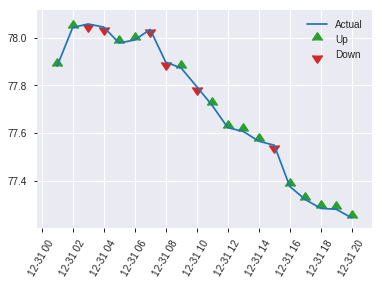


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19688331903794545
RMSE: 0.4437153581271956
LogLoss: 0.5807434133144064
Mean Per-Class Error: 0.2786341865702413
AUC: 0.7723644283735634
pr_auc: 0.717858369682412
Gini: 0.5447288567471269
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43933597207069397: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      210  129  0.3805   (129.0/339.0)
1      56   223  0.2007   (56.0/279.0)
Total  266  352  0.2994   (185.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439336     0.706815  217
max f2                       0.106072     0.809552  384
max f0point5                 0.546382     0.692641  144
max accuracy                 0.490356     0.720065  185
max precision                0.805255     0.896552  26
max recall                   0.0847936    1         393
max specificity              0.935248     0.99705   0
max absolute_mcc             0.488873     0.440698  186
max min_per_class_accuracy   0.494521     0.713864  183
max mean_per_class_accuracy  0.488873     0.721366  186

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.89435            1.58218   1.58218            0.714286         0.910815  0.714286                    0.910815            0.0179211       0.0179211                  58.2181   58.2181
    2        0.0210356                   0.874553           2.21505   1.87428            1                0.885703  0.846154                    0.899225            0.0215054       0.0394265                  121.505   87.4276
    3        0.0307443                   0.840798           1.84588   1.86531            0.833333         0.858219  0.842105                    0.886276            0.0179211       0.0573477                  84.5878   86.5308
    4        0.0404531                   0.82216            2.21505   1.94925            1                0.830894  0.88                        0.872984            0.0215054       0.078853                   121.505   94.9247
    5        0.0501618                   0.79443            1.84588   1.92924            0.833333         0.808464  0.870968                    0.860496            0.0179211       0.0967742                  84.5878   92.924
    6        0.100324                    0.689822           1.71488   1.82206            0.774194         0.730282  0.822581                    0.795389            0.0860215       0.182796                   71.488    82.206
    7        0.150485                    0.645952           1.78633   1.81015            0.806452         0.665615  0.817204                    0.752131            0.0896057       0.272401                   78.6334   81.0151
    8        0.200647                    0.609458           1.71488   1.78633            0.774194         0.629193  0.806452                    0.721397            0.0860215       0.358423                   71.488    78.6334
    9        0.300971                    0.563721           1.35761   1.64343            0.612903         0.586935  0.741935                    0.676576            0.136201        0.494624                   35.7614   64.3427
    10       0.399676                    0.528791           1.23462   1.54247            0.557377         0.547112  0.696356                    0.644603            0.121864        0.616487                   23.462    54.2467
    11       0.5                         0.48445            1.21471   1.4767             0.548387         0.505359  0.666667                    0.616664            0.121864        0.738351                   21.4707   47.6703
    12       0.600324                    0.420422           0.714533  1.34933            0.322581         0.452389  0.609164                    0.589211            0.0716846       0.810036                   -28.5467  34.9332
    13       0.699029                    0.34757            0.726247  1.26135            0.327869         0.385732  0.569444                    0.560479            0.0716846       0.88172                    -27.3753  26.135
    14       0.799353                    0.254359           0.42872   1.15685            0.193548         0.303744  0.522267                    0.528257            0.0430108       0.924731                   -57.128   15.685
    15       0.899676                    0.161353           0.392993  1.07167            0.177419         0.201793  0.483813                    0.491853            0.0394265       0.964158                   -60.7007  7.16717
    16       1                           0.0578341          0.357267  1                  0.16129          0.120995  0.451456                    0.454647            0

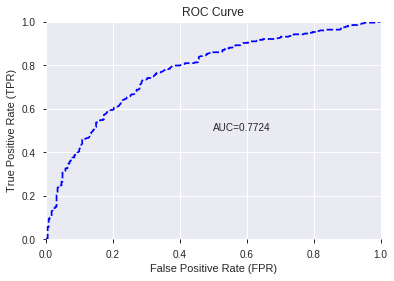

This function is available for GLM models only


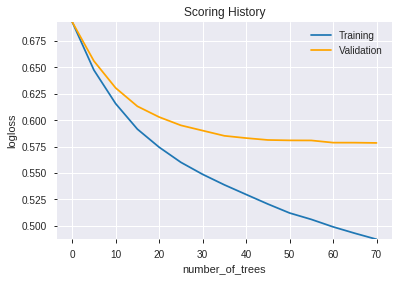

--2019-08-22 14:03:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_140232_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_140232_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b04a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'CCI_8',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'PLUS_DI_8',
 'ADXR_14',
 'BETA_30',
 'LINEARREG_ANGLE_14',
 'MINUS_DI_8',
 'VAR_8',
 'ULTOSC',
 'WILLR_12',
 'ROCP_8',
 'NATR_20',
 'MOM_14',
 'BBANDS_upperband_8_8_5',
 'BETA_8',
 'MACDEXT_hist',
 'STOCHRSI_fastk',
 'MFI_12',
 'CORREL_24',
 'MINUS_DM_8',
 'MFI_14',
 'MFI_30',
 'LINEARREG_ANGLE_8',
 'MACDFIX_signal_12',
 'BBANDS_lowerband_8_5_4',
 'AROONOSC_8',
 'PLUS_DM_14',
 'MACDFIX_hist_24',
 'STDDEV_12',
 'STOCHRSI_fastd',
 'MACDFIX_8',
 'WILLR_24',
 'MINUS_DI_14',
 'aroonup_8',
 'STOCH_slowk',
 'MACD_hist',
 'aroonup_30',
 'ROCP_12',
 'DX_8',
 'ROCR100_20',
 'PLUS_DI_24',
 'WILLR_20',
 'APO',
 'PLUS_DI_12',
 'WILLR_30',
 'RSI_14',
 'PLUS_DI_14',
 'aroondown_12',
 'ROCR_8',
 'STOCHF_fastd']

In [0]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [0]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.725
GLM             0.718
XGBoost         0.730
dtype: float64

DeepLearning    GLM  XGBoost
All          0.720  0.710    0.725
DLF          0.707  0.710    0.717
Fwe          0.725  0.718    0.730
RFE          0.720  0.714    0.720
XGBF         0.714  0.710    0.717





F1


DeepLearning    0.700
GLM             0.706
XGBoost         0.710
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.695    0.704
DLF          0.693  0.697    0.703
Fwe          0.699  0.706    0.710
RFE          0.695  0.700    0.707
XGBF         0.700  0.697    0.703





auc


DeepLearning    0.773
GLM             0.775
XGBoost         0.783
dtype: float64

DeepLearning    GLM  XGBoost
All          0.759  0.765    0.781
DLF          0.766  0.769    0.777
Fwe          0.765  0.775    0.783
RFE          0.764  0.766    0.772
XGBF         0.773  0.769    0.777





logloss


DeepLearning    0.637
GLM             0.592
XGBoost         0.581
dtype: float64

DeepLearning    GLM  XGBoost
All          0.637  0.592    0.573
DLF          0.588  0.573    0.571
Fwe          0.585  0.573    0.568
RFE          0.594  0.581    0.581
XGBF         0.598  0.573    0.571





mean_per_class_error


DeepLearning    0.296
GLM             0.297
XGBoost         0.285
dtype: float64

DeepLearning    GLM  XGBoost
All          0.291  0.297    0.283
DLF          0.296  0.296    0.285
Fwe          0.281  0.296    0.270
RFE          0.285  0.291    0.279
XGBF         0.291  0.296    0.285





rmse


DeepLearning    0.460
GLM             0.451
XGBoost         0.444
dtype: float64

DeepLearning    GLM  XGBoost
All          0.460  0.451    0.440
DLF          0.449  0.441    0.440
Fwe          0.447  0.439    0.437
RFE          0.447  0.443    0.444
XGBF         0.450  0.441    0.440





mse


DeepLearning    0.212
GLM             0.203
XGBoost         0.197
dtype: float64

DeepLearning    GLM  XGBoost
All          0.212  0.203    0.194
DLF          0.202  0.194    0.194
Fwe          0.200  0.193    0.191
RFE          0.200  0.197    0.197
XGBF         0.203  0.194    0.194

{'F1':       DeepLearning    GLM  XGBoost
 All          0.686    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.697      NaN
 DLF            NaN    NaN    0.703
 All            NaN  0.695      NaN
 All            NaN    NaN    0.704
 XGBF         0.700    NaN      NaN
 XGBF           NaN  0.697      NaN
 XGBF           NaN    NaN    0.703
 Fwe          0.699    NaN      NaN
 Fwe            NaN  0.706      NaN
 Fwe            NaN    NaN    0.710
 RFE          0.695    NaN      NaN
 RFE            NaN  0.700      NaN
 RFE            NaN    NaN    0.707,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.720    NaN      NaN
 DLF          0.707    NaN      NaN
 DLF            NaN  0.710      NaN
 DLF            NaN    NaN    0.717
 All            NaN  0.710      NaN
 All            NaN    NaN    0.725
 XGBF         0.714    NaN      NaN
 XGBF           NaN  0.710      NaN
 XGBF           NaN    NaN    0.717
 Fwe          0.725    NaN      NaN
 Fwe     